## BBM 409 - Programming Assignment 3

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

###  Insert personal information (name, surname, student id)

Gökdeniz Kuruca 2230356129

## 1. Implementing a CNN from Scratch (40 points)

### 1.1. Introduction

#### Task Overview

This project investigates the problem of vegetable image classification by approaching it from two complementary directions. The task involves identifying one of 15 vegetable categories from a dataset of 4500 images, each captured under varying lighting conditions, backgrounds, and angles. Last but not least goal is not only to build accurate models but also to understand how different learning strategies behave on the same classification task.

In the first part, a Convolutional Neural Network is implemented from scratch using PyTorch to directly tackle the vegetable classification problem. The model is designed with five convolutional layers, non-linear activation functions (ReLU), pooling layers, and a fully connected output layer tailored to the 15 class structure of the dataset. The workflow includes loading and preprocessing the vegetable images, applying data augmentation to improve generalization, optimizing the model’s parameters, monitoring validation accuracy, and selecting the best performing checkpoint. After training, the custom CNN is tested on the Kaggle evaluation set to measure how well a handcrafted architecture can classify vegetable types under real conditions.

Later in the second part of the project explores transfer learning by applying pre-trained ResNet-18 and MobileNet models to the same vegetable classification task. These networks have been trained on ImageNet, which allows them to recognize generic visual features like edges, textures, and shapes. By fine-tuning either selected layers or the entire model on the vegetable dataset, the project investigates how inherited visual knowledge accelerates learning and improves classification accuracy. Fine-tuning strategies such as updating only the final fully connected layer or unfreezing deeper convolutional blocks enable an analysis of the trade-offs between computational cost, training speed, and overall performance.

By comparing the from-scratch CNN with these fine-tuned pretrained architectures, the project demonstrates how much of the vegetable classification problem can be solved purely through training a basic model and how much can be enhanced by leveraging prior visual knowledge. This combined analysis highlights both the foundational mechanisms of CNNs and the practical strengths of modern transfer learning approaches for real-world image classification tasks.

---

#### Main Components of a CNN Architecture

A CNN architecture is designed to capture spatial patterns in images. Below are the essential components of a CNN and their roles in image classification.

![CNN](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Typical_cnn.png/800px-Typical_cnn.png)

##### Convolutional Layers
Convolutional layers extract local features from input images by sliding small filters across the image.  
Lower layers learn basic patterns such as edges and corners, while deeper layers capture more complex structures like shapes and textures.  
This hierarchical feature extraction is the core strength of CNNs.

##### Activation Functions
Activation functions, commonly ReLU (Rectified Linear Unit), introduce non-linearity to the network.  
Without non-linearity, the model would be limited to learning only linear transformations.

##### Pooling Layers
Pooling layers reduce the spatial dimensions of feature maps.  
They lower computational cost and help the model become more robust to small translations.  
Max pooling highlights the strongest activations, while average pooling retains general structure.

##### Fully Connected Layers
After convolution and pooling, feature maps are flattened and passed into fully connected (FC) layers.  
These layers act as the decision-making part of the network, producing class probabilities based on the extracted features.

##### Loss Function
This project uses Cross-Entropy Loss, a standard choice for multi-class classification.  
It measures the difference between predicted probabilities and ground-truth labels.

##### Optimizer
The optimizer updates the model’s weights during training.  
Adam provides fast and stable convergence, while SGD offers controlled learning with strong generalization properties.

##### Why CNNs for Image Classification?
CNNs excel in image classification because they naturally model spatial dependencies. Pixels gain meaning from their neighbors, and convolution filters effectively capture this structure. Parameter sharing allows CNNs to be far more efficient than fully connected networks, enabling them to scale to high-resolution images. For these reasons, CNNs are the foundation of modern computer vision systems.

---

#### Dataset Description

The dataset used in this project consists of 4500 RGB images representing 15 different vegetable classes. It is a balanced dataset, with each class containing a similar number of samples. The images were collected under varying lighting conditions, camera angles, and backgrounds, making the dataset diverse and suitable for evaluating generalization. The dataset is divided into three subsets: a 3000 image training set used for learning model parameters and applying augmentations; a 750 image validation set used to monitor model performance and select the best checkpoint; and a 750 image test set used for final evaluation, which is also utilized by the Kaggle competition for scoring.

For the training set, a series of data augmentations were applied to improve generalization and make the model robust to variations in the images. Specifically, the images were randomly resized and cropped to 256×256 pixels, randomly flipped horizontally, rotated up to 15 degrees, and had random adjustments in brightness, contrast, and saturation. Additionally, a random erasing technique was applied with a 40% probability to simulate occlusions or missing parts in the images. After these augmentations, the images were converted to tensors and normalized using ImageNet mean and standard deviation values, ensuring compatibility with both the custom CNN and pretrained architectures such as ResNet and MobileNet.

---


### 1.2. Data Loading and Preprocessing (3 points)

In [ ]:
# Import libs
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import pandas as pd
import os

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import models

from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

from enum import Enum

In [ ]:
# Define constants
BATCH_SIZE = 32
N_EPOCH = 100
PATH = os.path.join(os.path.curdir,"data")

In [ ]:
# Define data transformers
data_transform = transforms.Compose([
  transforms.Resize((256,256)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

train_data_transforms = transforms.Compose([
  transforms.RandomResizedCrop(256),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(15),
  transforms.ColorJitter(brightness=0.2,
                        contrast=0.2,
                        saturation=0.2),
  transforms.ToTensor(),
  transforms.RandomErasing(p=0.4),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [ ]:
# Create data paths
train_path = os.path.join(PATH,"train")
val_path = os.path.join(PATH,"val")
test_path = os.path.join(PATH,"test")

In [ ]:
# Create datasets
train_dataset = datasets.ImageFolder(train_path,train_data_transforms)
val_dataset = datasets.ImageFolder(val_path,data_transform)
test_dataset = datasets.ImageFolder(test_path,data_transform)

In [ ]:
# Data class stats
n_class = len(train_dataset.classes)

n_sample_train = len(train_dataset.samples)
n_sample_val = len(val_dataset.samples)
n_sample_test = len(test_dataset.samples)

print("Total class:",n_class)
print("Total sample train:",n_sample_train)
print("Total sample val:",n_sample_val)
print("Total sample test:",n_sample_test)

Total class: 15
Total sample train: 3000
Total sample val: 750
Total sample test: 750


In [ ]:
# Create loaders
train_loader = DataLoader(train_dataset,batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset,batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset,batch_size = BATCH_SIZE, shuffle = False)

### 1.3. Define your CNN architecture (7 points)

The architecture follows a progression that starts with broad low level feature extraction and gradually transitions into deeper high level representation learning. Early layers operate on relatively raw pixel information while later layers capture more abstract shapes and complex structural cues in the vegetable images which creates a top down flow from simple to complex visual understanding and ensures that each stage builds on increasingly refined representations. The overall design balances simplicity and representational power by increasing the capacity of the model in a controlled and gradual manner since the task requires capturing both basic edge information and deeper structural patterns. This approach aligns with common principles in modern CNN design and keeps the computational cost manageable while allowing the network to learn richer features at each successive depth.

The inchannel and outchannel values were increased in a controlled and gradual manner. Early layers use fewer channels because these layers focus on extracting simple edges and low level textures. Using an unnecessarily large number of channels at this stage would increase computational load and create too many parameters without improving feature quality. Deeper layers require more channels because they represent more complex visual patterns. Studies in the literature show that expanding the feature space with depth enhances the expressive capacity of CNN models.

The kernel size in the architecture was set to 3x3 because this configuration offers a strong balance between expressive capacity and computational efficiency. This design choice is widely supported in modern deep learning research. For example, the ResNet architecture introduced by He et al. (2016) relies almost entirely on stacked 3x3 convolutions. Their results show that such small kernels achieve high representational power while keeping the parameter count manageable. Larger kernels increase computational cost without providing proportional gains in performance. Smaller kernels fail to capture enough contextual visual information across the image. This makes the 3x3 kernel a practical default that aligns well with both theoretical insights and empirical results in state of the art models.

The padding value was set to 1 to preserve the spatial dimensions of the feature maps when using a 3x3 kernel. Maintaining spatial resolution across layers helps prevent the feature maps from shrinking too quickly which could weaken the representational capacity of deeper layers. By keeping the output size consistent the network retains more positional and structural detail throughout its depth enabling stronger discrimination between visually similar classes.

ReLU was chosen as the activation function because it provides a computationally efficient nonlinearity and avoids the vanishing gradient problem that commonly affects deeper networks. By zeroing out negative values it removes unnecessary computation and accelerates the learning process while still allowing the model to learn complex decision boundaries. Research consistently shows that ReLU based architectures converge faster and train more stably compared to sigmoid or tanh which tend to saturate and slow down optimization. These properties make ReLU a strong fit for this architecture since the network must reliably extract simple edge information in early layers and increasingly abstract features in deeper layers without suffering from gradient decay or excessive computational cost which keeps the representation flow coherent across the entire depth of the model.

#### Reference

[1] He K Zhang X Ren S Sun J 2016 Deep residual learning for image recognition *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition* [PDF](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)

[2] Nair V Hinton G E 2010 Rectified linear units improve restricted Boltzmann machines *Proceedings of the 27th International Conference on Machine Learning* [PDF](https://www.cs.toronto.edu/~hinton/absps/reluICML.pdf)



In [ ]:
class BaseCNN(nn.Module):
  """
  A straightforward convolutional neural network that extracts features
  from an input image through multiple convolution and pooling stages,
  then produces class logits using fully connected layers.

  Parameters
    n_class (int): Number of output classes

  Attributes
    conv1..conv5 (nn.Conv2d): Sequential convolution layers
    pool1..pool5 (nn.MaxPool2d): Max pooling after each convolution block
    fc1 (nn.Linear): Fully connected layer after flattening
    fc2 (nn.Linear): Output layer producing class logits
  """
  def __init__(self,n_class):
    super(BaseCNN, self).__init__()

    # Block 1: input channels 3 -> 32
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Block 2: 32 -> 64
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Block 3: 64 -> 128
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Block 4: 128 -> 256
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.relu4 = nn.ReLU()
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Block 5: 256 -> 512
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.relu5 = nn.ReLU()
    self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Fully connected stages after flattening
    self.fc1 = nn.Linear(512*8*8, 1024)
    self.relu6 = nn.ReLU()

    self.fc2 = nn.Linear(1024, n_class)

  def forward(self, x):
    """
    Process the input through a stack of convolution, activation,
    and pooling blocks, then map extracted features to class logits.

    Parameters
      x (torch.Tensor): Input tensor of shape (batch, 3, H, W)

    Returns
      torch.Tensor: Logits of shape (batch, n_class)
    """
    
    x = self.pool1(self.relu1(self.conv1(x)))
    x = self.pool2(self.relu2(self.conv2(x)))
    x = self.pool3(self.relu3(self.conv3(x)))
    x = self.pool4(self.relu4(self.conv4(x)))
    x = self.pool5(self.relu5(self.conv5(x)))

    x = x.view(x.size(0),-1)
    x = self.relu6(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
# Create model and load to device
model = BaseCNN(n_class = n_class)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Device:",device)

Device: cuda


### 1.4 Prepare the model for training (3 points)

The model uses the cross entropy loss function because it provides a direct and well behaved measure of the difference between predicted class probabilities and the true labels. Cross entropy encourages the model to assign high probability to the correct class and penalizes confident mistakes more strongly which stabilizes learning in multi class classification tasks. Its gradient properties are smooth and consistent which makes it a natural match for softmax based outputs and ensures that the model receives clear corrective signals throughout training.

Adam was selected as the primary optimizer because it adapts learning rates per parameter and accelerates convergence especially during early training. SGD with momentum is known to generalize well yet it usually converges slowly when starting from random initialization. A hybrid approach in which the model trains with Adam first and is later fine tuned with SGD was considered because this strategy is often effective in large scale vision models. However empirical tests showed that the model trained with Adam alone already achieved strong results and switching to SGD did not meaningfully improve accuracy. Since the goal was to maintain efficiency and avoid unnecessary steps Adam was kept as the sole optimizer.

The cosine annealing learning rate schedule was chosen because it is highly effective when training models from scratch. Its smooth decay pattern supports broad exploration early in training and stable refinement near convergence. Reduce on Plateau was not selected because that scheduler performs best in fine tune scenarios where the model is already near a good solution and requires adaptive local adjustments. In contrast the scratch training conditions of this project benefited more from the predictable and stable learning dynamics of the cosine schedule.

#### References

[1] Loshchilov I Hutter F 2016 SGDR stochastic gradient descent with warm restarts *arXiv preprint arXiv:1608.03983* [PDF](https://arxiv.org/abs/1608.03983)

[2] Kingma D P Ba J 2015 Adam a method for stochastic optimization *International Conference on Learning Representations* [PDF](https://arxiv.org/abs/1412.6980)

[3] Sutskever I Martens J Dahl G Hinton G 2013 On the importance of initialization and momentum in deep learning *International Conference on Machine Learning* [PDF](https://proceedings.mlr.press/v28/sutskever13.html)

[4] Goyal P Dollár P Girshick R Noordhuis P Wesolowski L Kyrola A Tulloch A Jia Y He K 2017 Accurate large minibatch SGD training ImageNet in 1 hour *arXiv preprint arXiv:1706.02677* [PDF](https://arxiv.org/abs/1706.02677)


In [ ]:
# Create optimizer, loss function and lr scheduler
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = CosineAnnealingLR(
    optimizer, 
    T_max=N_EPOCH,
    eta_min=1e-6
)

criterion = nn.CrossEntropyLoss()

### 1.5 Train and Validate the CNN model (10 points)

In [ ]:
def find_metrics(all_labels, all_preds):
  """
  Compute and display evaluation metrics for classification predictions.

  Parameters
    all_labels (array-like): Ground truth class labels
    all_preds (array-like): Predicted class labels

  Returns
    tuple: (accuracy, precision, recall, f1)
      accuracy (float): Overall correct prediction ratio
      precision (float): Macro-averaged precision score
      recall (float): Macro-averaged recall score
      f1 (float): Macro-averaged F1 score
  """
  acc = accuracy_score(all_labels, all_preds)
  precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
  recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
  f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

  print(f"Accuracy Score: {acc:.4f}")
  print(f"Precision Score: {precision:.4f}")
  print(f"Recall Score: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")

  return acc, precision, recall, f1

In [ ]:
def model_train_val(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stop, name, epochs=30):
  """
  Train and validate a neural network model while tracking metrics,
  applying learning rate scheduling, and performing early stopping.

  Parameters
    model (nn.Module): Model to be trained
    train_loader (DataLoader): Training data loader
    val_loader (DataLoader): Validation data loader
    criterion: Loss function applied to model predictions
    optimizer: Optimization algorithm for weight updates
    scheduler: Learning rate scheduler instance
    early_stop (int): Number of epochs to wait without improvement before stopping
    name (str): Filename prefix for saving the best model
    epochs (int): Maximum training epochs (default 30)

  Returns
    dict: Collected statistics
      train_losses (list of float): Loss per epoch on training set
      train_accuracies (list of float): Accuracy per epoch on training set
      val_losses (list of float): Loss per epoch on validation set
      val_accuracies (list of float): Accuracy per epoch on validation set
      best_val_accuracy (float): Best validation accuracy achieved
      best_preds (list): Predictions at the best epoch
      best_labels (list): True labels at the best epoch
      total_epoch (int): Total epochs run before finishing
  """

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  best_preds = []
  best_labels = []
  best_val_accuracy = 0
  patience = 0

  # Start train and validate loop
  for epoch in range(epochs):
    print("-------------------")
    print(f"Epoch {epoch+1}/{epochs}")
    print("\nTrain started...")

    model.train()
    all_preds = []
    all_labels = []
    train_loss = 0

    # Train phase
    for (inputs,labels) in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()

      # Fine tune handler
      with torch.set_grad_enabled(True):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

      # Backpropagation
      loss.backward()
      optimizer.step()
      
      train_loss += loss.item() * inputs.size(0)
      
      # Make preds
      _, preds = torch.max(outputs, 1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

    # Calculate epoch metrics
    epoch_train_loss = train_loss / len(train_loader.dataset)
    print(f"Train Loss: {epoch_train_loss:.4f}")
    print("Train Scores:")
    epoch_train_accuracy, _, _, _ = find_metrics(all_labels, all_preds)

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    print("\nValidation started...")
    model.eval()

    all_preds = []
    all_labels = []
    val_loss = 0

    # Validation phase
    for (inputs,labels) in tqdm(val_loader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs) 

      # Calculate loss
      loss = criterion(outputs, labels)
      val_loss += loss.item() * inputs.size(0)

      # Make preds
      _, preds = torch.max(outputs, 1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

    # Calculate epoch metrics
    epoch_val_loss = val_loss / len(val_loader.dataset)
    print(f"Validation Loss: {epoch_val_loss:.4f}")
    print("Validation Scores:")
    epoch_val_accuracy, _, _, _ = find_metrics(all_labels, all_preds)

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    # Lr scheduler control 
    if isinstance(scheduler, ReduceLROnPlateau):
      scheduler.step(epoch_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
      scheduler.step()

    # Choose best model 
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        torch.save(model.state_dict(), f"{name}_best_model.pth")
        best_preds = all_preds
        best_labels = all_labels
        patience = 0
        print(f"New best model saved. Validation accuracy: {epoch_val_accuracy:.4f}")
    else:
      patience += 1

    # Early stop
    if patience >= early_stop:
      print(f"Early stop in {epoch+1} epoch.")
      print(f"Last best model accuracy: {best_val_accuracy:.4f}")
      break
    
  return {
    "train_losses": train_losses,
    "train_accuracies": train_accuracies,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "best_val_accuracy": best_val_accuracy,
    "best_preds": best_preds,
    "best_labels": best_labels,
    "total_epoch":epoch+1
  }

In [ ]:
# Train and save model
result_dict_base = model_train_val(model, train_loader, val_loader, criterion, optimizer, scheduler, 15, "base_cnn", N_EPOCH)

-------------------
Epoch 1/100

Train started...


Training Epoch 1: 100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Train Loss: 2.3475
Train Scores:
Accuracy Score: 0.1753
Precision Score: 0.1740
Recall Score: 0.1753
F1 Score: 0.1594

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.61it/s]


Validation Loss: 1.9891
Validation Scores:
Accuracy Score: 0.2307
Precision Score: 0.2347
Recall Score: 0.2307
F1 Score: 0.1632
New best model saved. Validation accuracy: 0.2307
-------------------
Epoch 2/100

Train started...


Training Epoch 2: 100%|██████████| 94/94 [00:47<00:00,  1.99it/s]


Train Loss: 1.9457
Train Scores:
Accuracy Score: 0.3120
Precision Score: 0.2991
Recall Score: 0.3120
F1 Score: 0.2957

Validation started...


100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


Validation Loss: 1.7276
Validation Scores:
Accuracy Score: 0.4160
Precision Score: 0.5319
Recall Score: 0.4160
F1 Score: 0.4163
New best model saved. Validation accuracy: 0.4160
-------------------
Epoch 3/100

Train started...


Training Epoch 3: 100%|██████████| 94/94 [01:01<00:00,  1.54it/s]


Train Loss: 1.7077
Train Scores:
Accuracy Score: 0.4147
Precision Score: 0.4120
Recall Score: 0.4147
F1 Score: 0.4017

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.85it/s]


Validation Loss: 1.2700
Validation Scores:
Accuracy Score: 0.5853
Precision Score: 0.5987
Recall Score: 0.5853
F1 Score: 0.5601
New best model saved. Validation accuracy: 0.5853
-------------------
Epoch 4/100

Train started...


Training Epoch 4: 100%|██████████| 94/94 [00:35<00:00,  2.65it/s]


Train Loss: 1.5114
Train Scores:
Accuracy Score: 0.4823
Precision Score: 0.4812
Recall Score: 0.4823
F1 Score: 0.4759

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.85it/s]


Validation Loss: 1.1804
Validation Scores:
Accuracy Score: 0.5840
Precision Score: 0.6439
Recall Score: 0.5840
F1 Score: 0.5679
-------------------
Epoch 5/100

Train started...


Training Epoch 5: 100%|██████████| 94/94 [00:25<00:00,  3.64it/s]


Train Loss: 1.3841
Train Scores:
Accuracy Score: 0.5277
Precision Score: 0.5280
Recall Score: 0.5277
F1 Score: 0.5232

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.20it/s]


Validation Loss: 1.1180
Validation Scores:
Accuracy Score: 0.6387
Precision Score: 0.6937
Recall Score: 0.6387
F1 Score: 0.6297
New best model saved. Validation accuracy: 0.6387
-------------------
Epoch 6/100

Train started...


Training Epoch 6: 100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Train Loss: 1.2270
Train Scores:
Accuracy Score: 0.5827
Precision Score: 0.5881
Recall Score: 0.5827
F1 Score: 0.5823

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.14it/s]


Validation Loss: 1.0037
Validation Scores:
Accuracy Score: 0.6880
Precision Score: 0.7237
Recall Score: 0.6880
F1 Score: 0.6863
New best model saved. Validation accuracy: 0.6880
-------------------
Epoch 7/100

Train started...


Training Epoch 7: 100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Train Loss: 1.1413
Train Scores:
Accuracy Score: 0.6123
Precision Score: 0.6166
Recall Score: 0.6123
F1 Score: 0.6130

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.29it/s]


Validation Loss: 0.8422
Validation Scores:
Accuracy Score: 0.7373
Precision Score: 0.7552
Recall Score: 0.7373
F1 Score: 0.7389
New best model saved. Validation accuracy: 0.7373
-------------------
Epoch 8/100

Train started...


Training Epoch 8: 100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Train Loss: 1.0742
Train Scores:
Accuracy Score: 0.6343
Precision Score: 0.6392
Recall Score: 0.6343
F1 Score: 0.6344

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.71it/s]


Validation Loss: 0.6037
Validation Scores:
Accuracy Score: 0.8040
Precision Score: 0.8142
Recall Score: 0.8040
F1 Score: 0.7992
New best model saved. Validation accuracy: 0.8040
-------------------
Epoch 9/100

Train started...


Training Epoch 9: 100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Train Loss: 0.9638
Train Scores:
Accuracy Score: 0.6780
Precision Score: 0.6820
Recall Score: 0.6780
F1 Score: 0.6774

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.15it/s]


Validation Loss: 0.6014
Validation Scores:
Accuracy Score: 0.8027
Precision Score: 0.8155
Recall Score: 0.8027
F1 Score: 0.8020
-------------------
Epoch 10/100

Train started...


Training Epoch 10: 100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Train Loss: 0.8813
Train Scores:
Accuracy Score: 0.7077
Precision Score: 0.7120
Recall Score: 0.7077
F1 Score: 0.7085

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.70it/s]


Validation Loss: 0.5125
Validation Scores:
Accuracy Score: 0.8333
Precision Score: 0.8525
Recall Score: 0.8333
F1 Score: 0.8320
New best model saved. Validation accuracy: 0.8333
-------------------
Epoch 11/100

Train started...


Training Epoch 11: 100%|██████████| 94/94 [00:58<00:00,  1.60it/s]


Train Loss: 0.8331
Train Scores:
Accuracy Score: 0.7310
Precision Score: 0.7353
Recall Score: 0.7310
F1 Score: 0.7317

Validation started...


100%|██████████| 24/24 [00:06<00:00,  3.56it/s]


Validation Loss: 0.4807
Validation Scores:
Accuracy Score: 0.8533
Precision Score: 0.8659
Recall Score: 0.8533
F1 Score: 0.8539
New best model saved. Validation accuracy: 0.8533
-------------------
Epoch 12/100

Train started...


Training Epoch 12: 100%|██████████| 94/94 [00:28<00:00,  3.35it/s]


Train Loss: 0.7935
Train Scores:
Accuracy Score: 0.7323
Precision Score: 0.7375
Recall Score: 0.7323
F1 Score: 0.7332

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.13it/s]


Validation Loss: 0.4928
Validation Scores:
Accuracy Score: 0.8360
Precision Score: 0.8550
Recall Score: 0.8360
F1 Score: 0.8378
-------------------
Epoch 13/100

Train started...


Training Epoch 13: 100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Train Loss: 0.7518
Train Scores:
Accuracy Score: 0.7557
Precision Score: 0.7577
Recall Score: 0.7557
F1 Score: 0.7558

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.43it/s]


Validation Loss: 0.5300
Validation Scores:
Accuracy Score: 0.8493
Precision Score: 0.8668
Recall Score: 0.8493
F1 Score: 0.8493
-------------------
Epoch 14/100

Train started...


Training Epoch 14: 100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Train Loss: 0.7546
Train Scores:
Accuracy Score: 0.7527
Precision Score: 0.7562
Recall Score: 0.7527
F1 Score: 0.7535

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.89it/s]


Validation Loss: 0.4491
Validation Scores:
Accuracy Score: 0.8587
Precision Score: 0.8733
Recall Score: 0.8587
F1 Score: 0.8588
New best model saved. Validation accuracy: 0.8587
-------------------
Epoch 15/100

Train started...


Training Epoch 15: 100%|██████████| 94/94 [00:33<00:00,  2.79it/s]


Train Loss: 0.7012
Train Scores:
Accuracy Score: 0.7620
Precision Score: 0.7660
Recall Score: 0.7620
F1 Score: 0.7623

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.03it/s]


Validation Loss: 0.3672
Validation Scores:
Accuracy Score: 0.8960
Precision Score: 0.9005
Recall Score: 0.8960
F1 Score: 0.8959
New best model saved. Validation accuracy: 0.8960
-------------------
Epoch 16/100

Train started...


Training Epoch 16: 100%|██████████| 94/94 [00:51<00:00,  1.82it/s]


Train Loss: 0.6409
Train Scores:
Accuracy Score: 0.7840
Precision Score: 0.7867
Recall Score: 0.7840
F1 Score: 0.7846

Validation started...


100%|██████████| 24/24 [00:05<00:00,  4.32it/s]


Validation Loss: 0.4245
Validation Scores:
Accuracy Score: 0.8680
Precision Score: 0.8838
Recall Score: 0.8680
F1 Score: 0.8651
-------------------
Epoch 17/100

Train started...


Training Epoch 17: 100%|██████████| 94/94 [00:48<00:00,  1.94it/s]


Train Loss: 0.6197
Train Scores:
Accuracy Score: 0.7990
Precision Score: 0.8010
Recall Score: 0.7990
F1 Score: 0.7992

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.65it/s]


Validation Loss: 0.2464
Validation Scores:
Accuracy Score: 0.9267
Precision Score: 0.9312
Recall Score: 0.9267
F1 Score: 0.9266
New best model saved. Validation accuracy: 0.9267
-------------------
Epoch 18/100

Train started...


Training Epoch 18: 100%|██████████| 94/94 [00:57<00:00,  1.62it/s]


Train Loss: 0.5915
Train Scores:
Accuracy Score: 0.7980
Precision Score: 0.8005
Recall Score: 0.7980
F1 Score: 0.7987

Validation started...


100%|██████████| 24/24 [00:04<00:00,  5.74it/s]


Validation Loss: 0.3996
Validation Scores:
Accuracy Score: 0.8853
Precision Score: 0.8996
Recall Score: 0.8853
F1 Score: 0.8847
-------------------
Epoch 19/100

Train started...


Training Epoch 19: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


Train Loss: 0.5823
Train Scores:
Accuracy Score: 0.8117
Precision Score: 0.8149
Recall Score: 0.8117
F1 Score: 0.8123

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.26it/s]


Validation Loss: 0.3717
Validation Scores:
Accuracy Score: 0.8987
Precision Score: 0.9085
Recall Score: 0.8987
F1 Score: 0.8978
-------------------
Epoch 20/100

Train started...


Training Epoch 20: 100%|██████████| 94/94 [00:51<00:00,  1.82it/s]


Train Loss: 0.5714
Train Scores:
Accuracy Score: 0.8130
Precision Score: 0.8153
Recall Score: 0.8130
F1 Score: 0.8134

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.96it/s]


Validation Loss: 0.3462
Validation Scores:
Accuracy Score: 0.8933
Precision Score: 0.9066
Recall Score: 0.8933
F1 Score: 0.8906
-------------------
Epoch 21/100

Train started...


Training Epoch 21: 100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Train Loss: 0.5435
Train Scores:
Accuracy Score: 0.8190
Precision Score: 0.8220
Recall Score: 0.8190
F1 Score: 0.8195

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.94it/s]


Validation Loss: 0.2957
Validation Scores:
Accuracy Score: 0.9133
Precision Score: 0.9195
Recall Score: 0.9133
F1 Score: 0.9125
-------------------
Epoch 22/100

Train started...


Training Epoch 22: 100%|██████████| 94/94 [00:40<00:00,  2.35it/s]


Train Loss: 0.4989
Train Scores:
Accuracy Score: 0.8373
Precision Score: 0.8389
Recall Score: 0.8373
F1 Score: 0.8375

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Validation Loss: 0.2711
Validation Scores:
Accuracy Score: 0.9280
Precision Score: 0.9336
Recall Score: 0.9280
F1 Score: 0.9277
New best model saved. Validation accuracy: 0.9280
-------------------
Epoch 23/100

Train started...


Training Epoch 23: 100%|██████████| 94/94 [00:58<00:00,  1.60it/s]


Train Loss: 0.5312
Train Scores:
Accuracy Score: 0.8307
Precision Score: 0.8330
Recall Score: 0.8307
F1 Score: 0.8311

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.07it/s]


Validation Loss: 0.2870
Validation Scores:
Accuracy Score: 0.9227
Precision Score: 0.9256
Recall Score: 0.9227
F1 Score: 0.9229
-------------------
Epoch 24/100

Train started...


Training Epoch 24: 100%|██████████| 94/94 [00:58<00:00,  1.62it/s]


Train Loss: 0.5421
Train Scores:
Accuracy Score: 0.8157
Precision Score: 0.8176
Recall Score: 0.8157
F1 Score: 0.8160

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.10it/s]


Validation Loss: 0.3009
Validation Scores:
Accuracy Score: 0.9147
Precision Score: 0.9264
Recall Score: 0.9147
F1 Score: 0.9148
-------------------
Epoch 25/100

Train started...


Training Epoch 25: 100%|██████████| 94/94 [00:58<00:00,  1.62it/s]


Train Loss: 0.4472
Train Scores:
Accuracy Score: 0.8590
Precision Score: 0.8599
Recall Score: 0.8590
F1 Score: 0.8590

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.98it/s]


Validation Loss: 0.2974
Validation Scores:
Accuracy Score: 0.9173
Precision Score: 0.9243
Recall Score: 0.9173
F1 Score: 0.9179
-------------------
Epoch 26/100

Train started...


Training Epoch 26: 100%|██████████| 94/94 [00:58<00:00,  1.62it/s]


Train Loss: 0.4836
Train Scores:
Accuracy Score: 0.8440
Precision Score: 0.8459
Recall Score: 0.8440
F1 Score: 0.8445

Validation started...


100%|██████████| 24/24 [00:05<00:00,  4.19it/s]


Validation Loss: 0.2708
Validation Scores:
Accuracy Score: 0.9187
Precision Score: 0.9243
Recall Score: 0.9187
F1 Score: 0.9181
-------------------
Epoch 27/100

Train started...


Training Epoch 27: 100%|██████████| 94/94 [00:42<00:00,  2.21it/s]


Train Loss: 0.4159
Train Scores:
Accuracy Score: 0.8670
Precision Score: 0.8683
Recall Score: 0.8670
F1 Score: 0.8671

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.90it/s]


Validation Loss: 0.2145
Validation Scores:
Accuracy Score: 0.9427
Precision Score: 0.9451
Recall Score: 0.9427
F1 Score: 0.9428
New best model saved. Validation accuracy: 0.9427
-------------------
Epoch 28/100

Train started...


Training Epoch 28: 100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Train Loss: 0.4099
Train Scores:
Accuracy Score: 0.8660
Precision Score: 0.8674
Recall Score: 0.8660
F1 Score: 0.8664

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.14it/s]


Validation Loss: 0.3048
Validation Scores:
Accuracy Score: 0.9187
Precision Score: 0.9267
Recall Score: 0.9187
F1 Score: 0.9196
-------------------
Epoch 29/100

Train started...


Training Epoch 29: 100%|██████████| 94/94 [00:55<00:00,  1.68it/s]


Train Loss: 0.4108
Train Scores:
Accuracy Score: 0.8697
Precision Score: 0.8706
Recall Score: 0.8697
F1 Score: 0.8698

Validation started...


100%|██████████| 24/24 [00:06<00:00,  3.60it/s]


Validation Loss: 0.2329
Validation Scores:
Accuracy Score: 0.9427
Precision Score: 0.9457
Recall Score: 0.9427
F1 Score: 0.9427
-------------------
Epoch 30/100

Train started...


Training Epoch 30: 100%|██████████| 94/94 [00:38<00:00,  2.44it/s]


Train Loss: 0.4343
Train Scores:
Accuracy Score: 0.8637
Precision Score: 0.8655
Recall Score: 0.8637
F1 Score: 0.8640

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.24it/s]


Validation Loss: 0.1776
Validation Scores:
Accuracy Score: 0.9520
Precision Score: 0.9546
Recall Score: 0.9520
F1 Score: 0.9518
New best model saved. Validation accuracy: 0.9520
-------------------
Epoch 31/100

Train started...


Training Epoch 31: 100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Train Loss: 0.3667
Train Scores:
Accuracy Score: 0.8807
Precision Score: 0.8817
Recall Score: 0.8807
F1 Score: 0.8809

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.82it/s]


Validation Loss: 0.2751
Validation Scores:
Accuracy Score: 0.9147
Precision Score: 0.9222
Recall Score: 0.9147
F1 Score: 0.9149
-------------------
Epoch 32/100

Train started...


Training Epoch 32: 100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Train Loss: 0.3664
Train Scores:
Accuracy Score: 0.8847
Precision Score: 0.8859
Recall Score: 0.8847
F1 Score: 0.8850

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.04it/s]


Validation Loss: 0.2296
Validation Scores:
Accuracy Score: 0.9347
Precision Score: 0.9399
Recall Score: 0.9347
F1 Score: 0.9353
-------------------
Epoch 33/100

Train started...


Training Epoch 33: 100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Train Loss: 0.3604
Train Scores:
Accuracy Score: 0.8863
Precision Score: 0.8871
Recall Score: 0.8863
F1 Score: 0.8864

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.12it/s]


Validation Loss: 0.2395
Validation Scores:
Accuracy Score: 0.9413
Precision Score: 0.9481
Recall Score: 0.9413
F1 Score: 0.9424
-------------------
Epoch 34/100

Train started...


Training Epoch 34: 100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Train Loss: 0.3025
Train Scores:
Accuracy Score: 0.8967
Precision Score: 0.8975
Recall Score: 0.8967
F1 Score: 0.8968

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.82it/s]


Validation Loss: 0.3003
Validation Scores:
Accuracy Score: 0.9227
Precision Score: 0.9322
Recall Score: 0.9227
F1 Score: 0.9237
-------------------
Epoch 35/100

Train started...


Training Epoch 35: 100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Train Loss: 0.3971
Train Scores:
Accuracy Score: 0.8813
Precision Score: 0.8822
Recall Score: 0.8813
F1 Score: 0.8815

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.18it/s]


Validation Loss: 0.1665
Validation Scores:
Accuracy Score: 0.9520
Precision Score: 0.9546
Recall Score: 0.9520
F1 Score: 0.9521
-------------------
Epoch 36/100

Train started...


Training Epoch 36: 100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Train Loss: 0.3496
Train Scores:
Accuracy Score: 0.8863
Precision Score: 0.8869
Recall Score: 0.8863
F1 Score: 0.8864

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.91it/s]


Validation Loss: 0.1898
Validation Scores:
Accuracy Score: 0.9453
Precision Score: 0.9511
Recall Score: 0.9453
F1 Score: 0.9459
-------------------
Epoch 37/100

Train started...


Training Epoch 37: 100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Train Loss: 0.3003
Train Scores:
Accuracy Score: 0.9047
Precision Score: 0.9052
Recall Score: 0.9047
F1 Score: 0.9048

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.99it/s]


Validation Loss: 0.1939
Validation Scores:
Accuracy Score: 0.9427
Precision Score: 0.9464
Recall Score: 0.9427
F1 Score: 0.9427
-------------------
Epoch 38/100

Train started...


Training Epoch 38: 100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Train Loss: 0.3474
Train Scores:
Accuracy Score: 0.8873
Precision Score: 0.8880
Recall Score: 0.8873
F1 Score: 0.8874

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.95it/s]


Validation Loss: 0.1948
Validation Scores:
Accuracy Score: 0.9427
Precision Score: 0.9466
Recall Score: 0.9427
F1 Score: 0.9427
-------------------
Epoch 39/100

Train started...


Training Epoch 39: 100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Train Loss: 0.2701
Train Scores:
Accuracy Score: 0.9120
Precision Score: 0.9124
Recall Score: 0.9120
F1 Score: 0.9121

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.65it/s]


Validation Loss: 0.1304
Validation Scores:
Accuracy Score: 0.9627
Precision Score: 0.9647
Recall Score: 0.9627
F1 Score: 0.9626
New best model saved. Validation accuracy: 0.9627
-------------------
Epoch 40/100

Train started...


Training Epoch 40: 100%|██████████| 94/94 [00:27<00:00,  3.40it/s]


Train Loss: 0.3118
Train Scores:
Accuracy Score: 0.9000
Precision Score: 0.9006
Recall Score: 0.9000
F1 Score: 0.9001

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.79it/s]


Validation Loss: 0.1449
Validation Scores:
Accuracy Score: 0.9600
Precision Score: 0.9622
Recall Score: 0.9600
F1 Score: 0.9601
-------------------
Epoch 41/100

Train started...


Training Epoch 41: 100%|██████████| 94/94 [00:25<00:00,  3.66it/s]


Train Loss: 0.2891
Train Scores:
Accuracy Score: 0.9077
Precision Score: 0.9081
Recall Score: 0.9077
F1 Score: 0.9077

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.21it/s]


Validation Loss: 0.2193
Validation Scores:
Accuracy Score: 0.9320
Precision Score: 0.9356
Recall Score: 0.9320
F1 Score: 0.9322
-------------------
Epoch 42/100

Train started...


Training Epoch 42: 100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Train Loss: 0.3446
Train Scores:
Accuracy Score: 0.8923
Precision Score: 0.8927
Recall Score: 0.8923
F1 Score: 0.8923

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.05it/s]


Validation Loss: 0.1633
Validation Scores:
Accuracy Score: 0.9533
Precision Score: 0.9565
Recall Score: 0.9533
F1 Score: 0.9534
-------------------
Epoch 43/100

Train started...


Training Epoch 43: 100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Train Loss: 0.2904
Train Scores:
Accuracy Score: 0.9030
Precision Score: 0.9040
Recall Score: 0.9030
F1 Score: 0.9033

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.20it/s]


Validation Loss: 0.1322
Validation Scores:
Accuracy Score: 0.9667
Precision Score: 0.9684
Recall Score: 0.9667
F1 Score: 0.9667
New best model saved. Validation accuracy: 0.9667
-------------------
Epoch 44/100

Train started...


Training Epoch 44: 100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Train Loss: 0.2672
Train Scores:
Accuracy Score: 0.9123
Precision Score: 0.9128
Recall Score: 0.9123
F1 Score: 0.9124

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.16it/s]


Validation Loss: 0.1543
Validation Scores:
Accuracy Score: 0.9613
Precision Score: 0.9641
Recall Score: 0.9613
F1 Score: 0.9614
-------------------
Epoch 45/100

Train started...


Training Epoch 45: 100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Train Loss: 0.2533
Train Scores:
Accuracy Score: 0.9167
Precision Score: 0.9176
Recall Score: 0.9167
F1 Score: 0.9168

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.87it/s]


Validation Loss: 0.2010
Validation Scores:
Accuracy Score: 0.9507
Precision Score: 0.9531
Recall Score: 0.9507
F1 Score: 0.9503
-------------------
Epoch 46/100

Train started...


Training Epoch 46: 100%|██████████| 94/94 [00:26<00:00,  3.60it/s]


Train Loss: 0.2278
Train Scores:
Accuracy Score: 0.9247
Precision Score: 0.9248
Recall Score: 0.9247
F1 Score: 0.9247

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.89it/s]


Validation Loss: 0.1625
Validation Scores:
Accuracy Score: 0.9573
Precision Score: 0.9587
Recall Score: 0.9573
F1 Score: 0.9570
-------------------
Epoch 47/100

Train started...


Training Epoch 47: 100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Train Loss: 0.2669
Train Scores:
Accuracy Score: 0.9160
Precision Score: 0.9166
Recall Score: 0.9160
F1 Score: 0.9160

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.97it/s]


Validation Loss: 0.1495
Validation Scores:
Accuracy Score: 0.9707
Precision Score: 0.9717
Recall Score: 0.9707
F1 Score: 0.9707
New best model saved. Validation accuracy: 0.9707
-------------------
Epoch 48/100

Train started...


Training Epoch 48: 100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Train Loss: 0.2504
Train Scores:
Accuracy Score: 0.9203
Precision Score: 0.9206
Recall Score: 0.9203
F1 Score: 0.9203

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.54it/s]


Validation Loss: 0.1642
Validation Scores:
Accuracy Score: 0.9653
Precision Score: 0.9667
Recall Score: 0.9653
F1 Score: 0.9651
-------------------
Epoch 49/100

Train started...


Training Epoch 49: 100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Train Loss: 0.2282
Train Scores:
Accuracy Score: 0.9240
Precision Score: 0.9245
Recall Score: 0.9240
F1 Score: 0.9241

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.84it/s]


Validation Loss: 0.1447
Validation Scores:
Accuracy Score: 0.9693
Precision Score: 0.9711
Recall Score: 0.9693
F1 Score: 0.9690
-------------------
Epoch 50/100

Train started...


Training Epoch 50: 100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Train Loss: 0.2209
Train Scores:
Accuracy Score: 0.9247
Precision Score: 0.9253
Recall Score: 0.9247
F1 Score: 0.9248

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.01it/s]


Validation Loss: 0.1504
Validation Scores:
Accuracy Score: 0.9680
Precision Score: 0.9695
Recall Score: 0.9680
F1 Score: 0.9679
-------------------
Epoch 51/100

Train started...


Training Epoch 51: 100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Train Loss: 0.2397
Train Scores:
Accuracy Score: 0.9217
Precision Score: 0.9222
Recall Score: 0.9217
F1 Score: 0.9217

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.51it/s]


Validation Loss: 0.1338
Validation Scores:
Accuracy Score: 0.9707
Precision Score: 0.9715
Recall Score: 0.9707
F1 Score: 0.9704
-------------------
Epoch 52/100

Train started...


Training Epoch 52: 100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Train Loss: 0.2204
Train Scores:
Accuracy Score: 0.9343
Precision Score: 0.9347
Recall Score: 0.9343
F1 Score: 0.9344

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.16it/s]


Validation Loss: 0.1340
Validation Scores:
Accuracy Score: 0.9640
Precision Score: 0.9651
Recall Score: 0.9640
F1 Score: 0.9639
-------------------
Epoch 53/100

Train started...


Training Epoch 53: 100%|██████████| 94/94 [00:25<00:00,  3.71it/s]


Train Loss: 0.2198
Train Scores:
Accuracy Score: 0.9300
Precision Score: 0.9303
Recall Score: 0.9300
F1 Score: 0.9300

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.12it/s]


Validation Loss: 0.1559
Validation Scores:
Accuracy Score: 0.9493
Precision Score: 0.9511
Recall Score: 0.9493
F1 Score: 0.9494
-------------------
Epoch 54/100

Train started...


Training Epoch 54: 100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Train Loss: 0.2088
Train Scores:
Accuracy Score: 0.9300
Precision Score: 0.9307
Recall Score: 0.9300
F1 Score: 0.9302

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.65it/s]


Validation Loss: 0.1343
Validation Scores:
Accuracy Score: 0.9613
Precision Score: 0.9624
Recall Score: 0.9613
F1 Score: 0.9610
-------------------
Epoch 55/100

Train started...


Training Epoch 55: 100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Train Loss: 0.1819
Train Scores:
Accuracy Score: 0.9410
Precision Score: 0.9415
Recall Score: 0.9410
F1 Score: 0.9410

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.83it/s]


Validation Loss: 0.1100
Validation Scores:
Accuracy Score: 0.9720
Precision Score: 0.9722
Recall Score: 0.9720
F1 Score: 0.9719
New best model saved. Validation accuracy: 0.9720
-------------------
Epoch 56/100

Train started...


Training Epoch 56: 100%|██████████| 94/94 [00:27<00:00,  3.41it/s]


Train Loss: 0.1913
Train Scores:
Accuracy Score: 0.9443
Precision Score: 0.9448
Recall Score: 0.9443
F1 Score: 0.9444

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.16it/s]


Validation Loss: 0.1510
Validation Scores:
Accuracy Score: 0.9653
Precision Score: 0.9662
Recall Score: 0.9653
F1 Score: 0.9652
-------------------
Epoch 57/100

Train started...


Training Epoch 57: 100%|██████████| 94/94 [00:27<00:00,  3.40it/s]


Train Loss: 0.1918
Train Scores:
Accuracy Score: 0.9403
Precision Score: 0.9406
Recall Score: 0.9403
F1 Score: 0.9404

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.85it/s]


Validation Loss: 0.1642
Validation Scores:
Accuracy Score: 0.9600
Precision Score: 0.9611
Recall Score: 0.9600
F1 Score: 0.9597
-------------------
Epoch 58/100

Train started...


Training Epoch 58: 100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Train Loss: 0.1777
Train Scores:
Accuracy Score: 0.9483
Precision Score: 0.9486
Recall Score: 0.9483
F1 Score: 0.9484

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.73it/s]


Validation Loss: 0.1623
Validation Scores:
Accuracy Score: 0.9467
Precision Score: 0.9499
Recall Score: 0.9467
F1 Score: 0.9467
-------------------
Epoch 59/100

Train started...


Training Epoch 59: 100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Train Loss: 0.1758
Train Scores:
Accuracy Score: 0.9457
Precision Score: 0.9464
Recall Score: 0.9457
F1 Score: 0.9457

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.88it/s]


Validation Loss: 0.1537
Validation Scores:
Accuracy Score: 0.9653
Precision Score: 0.9682
Recall Score: 0.9653
F1 Score: 0.9655
-------------------
Epoch 60/100

Train started...


Training Epoch 60: 100%|██████████| 94/94 [00:26<00:00,  3.48it/s]


Train Loss: 0.1744
Train Scores:
Accuracy Score: 0.9423
Precision Score: 0.9425
Recall Score: 0.9423
F1 Score: 0.9423

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.49it/s]


Validation Loss: 0.1004
Validation Scores:
Accuracy Score: 0.9760
Precision Score: 0.9769
Recall Score: 0.9760
F1 Score: 0.9759
New best model saved. Validation accuracy: 0.9760
-------------------
Epoch 61/100

Train started...


Training Epoch 61: 100%|██████████| 94/94 [00:26<00:00,  3.59it/s]


Train Loss: 0.1777
Train Scores:
Accuracy Score: 0.9410
Precision Score: 0.9413
Recall Score: 0.9410
F1 Score: 0.9410

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.76it/s]


Validation Loss: 0.1580
Validation Scores:
Accuracy Score: 0.9680
Precision Score: 0.9700
Recall Score: 0.9680
F1 Score: 0.9682
-------------------
Epoch 62/100

Train started...


Training Epoch 62: 100%|██████████| 94/94 [00:27<00:00,  3.40it/s]


Train Loss: 0.1913
Train Scores:
Accuracy Score: 0.9393
Precision Score: 0.9396
Recall Score: 0.9393
F1 Score: 0.9394

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.70it/s]


Validation Loss: 0.1285
Validation Scores:
Accuracy Score: 0.9747
Precision Score: 0.9754
Recall Score: 0.9747
F1 Score: 0.9747
-------------------
Epoch 63/100

Train started...


Training Epoch 63: 100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Train Loss: 0.1493
Train Scores:
Accuracy Score: 0.9537
Precision Score: 0.9540
Recall Score: 0.9537
F1 Score: 0.9537

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.30it/s]


Validation Loss: 0.1440
Validation Scores:
Accuracy Score: 0.9720
Precision Score: 0.9726
Recall Score: 0.9720
F1 Score: 0.9718
-------------------
Epoch 64/100

Train started...


Training Epoch 64: 100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Train Loss: 0.1483
Train Scores:
Accuracy Score: 0.9573
Precision Score: 0.9576
Recall Score: 0.9573
F1 Score: 0.9574

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.35it/s]


Validation Loss: 0.1110
Validation Scores:
Accuracy Score: 0.9760
Precision Score: 0.9766
Recall Score: 0.9760
F1 Score: 0.9760
-------------------
Epoch 65/100

Train started...


Training Epoch 65: 100%|██████████| 94/94 [00:25<00:00,  3.65it/s]


Train Loss: 0.1717
Train Scores:
Accuracy Score: 0.9513
Precision Score: 0.9516
Recall Score: 0.9513
F1 Score: 0.9514

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.24it/s]


Validation Loss: 0.1315
Validation Scores:
Accuracy Score: 0.9680
Precision Score: 0.9693
Recall Score: 0.9680
F1 Score: 0.9678
-------------------
Epoch 66/100

Train started...


Training Epoch 66: 100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Train Loss: 0.1431
Train Scores:
Accuracy Score: 0.9533
Precision Score: 0.9535
Recall Score: 0.9533
F1 Score: 0.9533

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.00it/s]


Validation Loss: 0.1287
Validation Scores:
Accuracy Score: 0.9707
Precision Score: 0.9729
Recall Score: 0.9707
F1 Score: 0.9709
-------------------
Epoch 67/100

Train started...


Training Epoch 67: 100%|██████████| 94/94 [00:25<00:00,  3.73it/s]


Train Loss: 0.1698
Train Scores:
Accuracy Score: 0.9497
Precision Score: 0.9501
Recall Score: 0.9497
F1 Score: 0.9498

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.97it/s]


Validation Loss: 0.1276
Validation Scores:
Accuracy Score: 0.9720
Precision Score: 0.9733
Recall Score: 0.9720
F1 Score: 0.9720
-------------------
Epoch 68/100

Train started...


Training Epoch 68: 100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Train Loss: 0.1659
Train Scores:
Accuracy Score: 0.9483
Precision Score: 0.9485
Recall Score: 0.9483
F1 Score: 0.9483

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.10it/s]


Validation Loss: 0.1164
Validation Scores:
Accuracy Score: 0.9773
Precision Score: 0.9784
Recall Score: 0.9773
F1 Score: 0.9773
New best model saved. Validation accuracy: 0.9773
-------------------
Epoch 69/100

Train started...


Training Epoch 69: 100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Train Loss: 0.1541
Train Scores:
Accuracy Score: 0.9527
Precision Score: 0.9530
Recall Score: 0.9527
F1 Score: 0.9527

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.98it/s]


Validation Loss: 0.1091
Validation Scores:
Accuracy Score: 0.9773
Precision Score: 0.9778
Recall Score: 0.9773
F1 Score: 0.9772
-------------------
Epoch 70/100

Train started...


Training Epoch 70: 100%|██████████| 94/94 [00:26<00:00,  3.54it/s]


Train Loss: 0.1615
Train Scores:
Accuracy Score: 0.9503
Precision Score: 0.9506
Recall Score: 0.9503
F1 Score: 0.9503

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.82it/s]


Validation Loss: 0.1237
Validation Scores:
Accuracy Score: 0.9733
Precision Score: 0.9744
Recall Score: 0.9733
F1 Score: 0.9733
-------------------
Epoch 71/100

Train started...


Training Epoch 71: 100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Train Loss: 0.1513
Train Scores:
Accuracy Score: 0.9543
Precision Score: 0.9545
Recall Score: 0.9543
F1 Score: 0.9543

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.60it/s]


Validation Loss: 0.1145
Validation Scores:
Accuracy Score: 0.9773
Precision Score: 0.9780
Recall Score: 0.9773
F1 Score: 0.9772
-------------------
Epoch 72/100

Train started...


Training Epoch 72: 100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Train Loss: 0.1319
Train Scores:
Accuracy Score: 0.9547
Precision Score: 0.9549
Recall Score: 0.9547
F1 Score: 0.9547

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.51it/s]


Validation Loss: 0.0973
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9812
Recall Score: 0.9800
F1 Score: 0.9800
New best model saved. Validation accuracy: 0.9800
-------------------
Epoch 73/100

Train started...


Training Epoch 73: 100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Train Loss: 0.1424
Train Scores:
Accuracy Score: 0.9543
Precision Score: 0.9546
Recall Score: 0.9543
F1 Score: 0.9544

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.66it/s]


Validation Loss: 0.0909
Validation Scores:
Accuracy Score: 0.9760
Precision Score: 0.9766
Recall Score: 0.9760
F1 Score: 0.9758
-------------------
Epoch 74/100

Train started...


Training Epoch 74: 100%|██████████| 94/94 [00:24<00:00,  3.76it/s]


Train Loss: 0.1425
Train Scores:
Accuracy Score: 0.9560
Precision Score: 0.9563
Recall Score: 0.9560
F1 Score: 0.9560

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.66it/s]


Validation Loss: 0.1027
Validation Scores:
Accuracy Score: 0.9760
Precision Score: 0.9767
Recall Score: 0.9760
F1 Score: 0.9759
-------------------
Epoch 75/100

Train started...


Training Epoch 75: 100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Train Loss: 0.1306
Train Scores:
Accuracy Score: 0.9580
Precision Score: 0.9581
Recall Score: 0.9580
F1 Score: 0.9580

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.24it/s]


Validation Loss: 0.1154
Validation Scores:
Accuracy Score: 0.9693
Precision Score: 0.9705
Recall Score: 0.9693
F1 Score: 0.9693
-------------------
Epoch 76/100

Train started...


Training Epoch 76: 100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Train Loss: 0.1419
Train Scores:
Accuracy Score: 0.9547
Precision Score: 0.9550
Recall Score: 0.9547
F1 Score: 0.9547

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.91it/s]


Validation Loss: 0.1095
Validation Scores:
Accuracy Score: 0.9787
Precision Score: 0.9795
Recall Score: 0.9787
F1 Score: 0.9786
-------------------
Epoch 77/100

Train started...


Training Epoch 77: 100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Train Loss: 0.1089
Train Scores:
Accuracy Score: 0.9660
Precision Score: 0.9662
Recall Score: 0.9660
F1 Score: 0.9660

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.11it/s]


Validation Loss: 0.1074
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9809
Recall Score: 0.9800
F1 Score: 0.9799
-------------------
Epoch 78/100

Train started...


Training Epoch 78: 100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Train Loss: 0.1259
Train Scores:
Accuracy Score: 0.9593
Precision Score: 0.9594
Recall Score: 0.9593
F1 Score: 0.9593

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.14it/s]


Validation Loss: 0.1036
Validation Scores:
Accuracy Score: 0.9747
Precision Score: 0.9754
Recall Score: 0.9747
F1 Score: 0.9746
-------------------
Epoch 79/100

Train started...


Training Epoch 79: 100%|██████████| 94/94 [00:25<00:00,  3.68it/s]


Train Loss: 0.1037
Train Scores:
Accuracy Score: 0.9700
Precision Score: 0.9701
Recall Score: 0.9700
F1 Score: 0.9700

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.16it/s]


Validation Loss: 0.1157
Validation Scores:
Accuracy Score: 0.9760
Precision Score: 0.9768
Recall Score: 0.9760
F1 Score: 0.9759
-------------------
Epoch 80/100

Train started...


Training Epoch 80: 100%|██████████| 94/94 [00:39<00:00,  2.38it/s]


Train Loss: 0.1138
Train Scores:
Accuracy Score: 0.9637
Precision Score: 0.9639
Recall Score: 0.9637
F1 Score: 0.9637

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.21it/s]


Validation Loss: 0.1057
Validation Scores:
Accuracy Score: 0.9773
Precision Score: 0.9783
Recall Score: 0.9773
F1 Score: 0.9773
-------------------
Epoch 81/100

Train started...


Training Epoch 81: 100%|██████████| 94/94 [00:58<00:00,  1.60it/s]


Train Loss: 0.1106
Train Scores:
Accuracy Score: 0.9637
Precision Score: 0.9639
Recall Score: 0.9637
F1 Score: 0.9637

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.04it/s]


Validation Loss: 0.1053
Validation Scores:
Accuracy Score: 0.9787
Precision Score: 0.9795
Recall Score: 0.9787
F1 Score: 0.9786
-------------------
Epoch 82/100

Train started...


Training Epoch 82: 100%|██████████| 94/94 [00:59<00:00,  1.57it/s]


Train Loss: 0.1083
Train Scores:
Accuracy Score: 0.9627
Precision Score: 0.9629
Recall Score: 0.9627
F1 Score: 0.9627

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.29it/s]


Validation Loss: 0.1120
Validation Scores:
Accuracy Score: 0.9760
Precision Score: 0.9766
Recall Score: 0.9760
F1 Score: 0.9759
-------------------
Epoch 83/100

Train started...


Training Epoch 83: 100%|██████████| 94/94 [00:53<00:00,  1.75it/s]


Train Loss: 0.1061
Train Scores:
Accuracy Score: 0.9673
Precision Score: 0.9675
Recall Score: 0.9673
F1 Score: 0.9673

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.34it/s]


Validation Loss: 0.1048
Validation Scores:
Accuracy Score: 0.9773
Precision Score: 0.9779
Recall Score: 0.9773
F1 Score: 0.9773
-------------------
Epoch 84/100

Train started...


Training Epoch 84: 100%|██████████| 94/94 [00:26<00:00,  3.48it/s]


Train Loss: 0.1044
Train Scores:
Accuracy Score: 0.9670
Precision Score: 0.9673
Recall Score: 0.9670
F1 Score: 0.9671

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.32it/s]


Validation Loss: 0.1157
Validation Scores:
Accuracy Score: 0.9773
Precision Score: 0.9779
Recall Score: 0.9773
F1 Score: 0.9772
-------------------
Epoch 85/100

Train started...


Training Epoch 85: 100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Train Loss: 0.1077
Train Scores:
Accuracy Score: 0.9670
Precision Score: 0.9672
Recall Score: 0.9670
F1 Score: 0.9670

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.07it/s]


Validation Loss: 0.1142
Validation Scores:
Accuracy Score: 0.9747
Precision Score: 0.9751
Recall Score: 0.9747
F1 Score: 0.9746
-------------------
Epoch 86/100

Train started...


Training Epoch 86: 100%|██████████| 94/94 [00:25<00:00,  3.66it/s]


Train Loss: 0.0945
Train Scores:
Accuracy Score: 0.9713
Precision Score: 0.9714
Recall Score: 0.9713
F1 Score: 0.9713

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.25it/s]


Validation Loss: 0.1065
Validation Scores:
Accuracy Score: 0.9813
Precision Score: 0.9821
Recall Score: 0.9813
F1 Score: 0.9813
New best model saved. Validation accuracy: 0.9813
-------------------
Epoch 87/100

Train started...


Training Epoch 87: 100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Train Loss: 0.1058
Train Scores:
Accuracy Score: 0.9663
Precision Score: 0.9666
Recall Score: 0.9663
F1 Score: 0.9663

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.32it/s]


Validation Loss: 0.1118
Validation Scores:
Accuracy Score: 0.9787
Precision Score: 0.9792
Recall Score: 0.9787
F1 Score: 0.9786
-------------------
Epoch 88/100

Train started...


Training Epoch 88: 100%|██████████| 94/94 [00:30<00:00,  3.06it/s]


Train Loss: 0.1234
Train Scores:
Accuracy Score: 0.9620
Precision Score: 0.9622
Recall Score: 0.9620
F1 Score: 0.9620

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.36it/s]


Validation Loss: 0.1048
Validation Scores:
Accuracy Score: 0.9773
Precision Score: 0.9778
Recall Score: 0.9773
F1 Score: 0.9772
-------------------
Epoch 89/100

Train started...


Training Epoch 89: 100%|██████████| 94/94 [00:26<00:00,  3.56it/s]


Train Loss: 0.1063
Train Scores:
Accuracy Score: 0.9677
Precision Score: 0.9678
Recall Score: 0.9677
F1 Score: 0.9677

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.45it/s]


Validation Loss: 0.1031
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9805
Recall Score: 0.9800
F1 Score: 0.9799
-------------------
Epoch 90/100

Train started...


Training Epoch 90: 100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Train Loss: 0.0826
Train Scores:
Accuracy Score: 0.9763
Precision Score: 0.9765
Recall Score: 0.9763
F1 Score: 0.9763

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.46it/s]


Validation Loss: 0.1049
Validation Scores:
Accuracy Score: 0.9813
Precision Score: 0.9820
Recall Score: 0.9813
F1 Score: 0.9812
-------------------
Epoch 91/100

Train started...


Training Epoch 91: 100%|██████████| 94/94 [00:25<00:00,  3.68it/s]


Train Loss: 0.1240
Train Scores:
Accuracy Score: 0.9627
Precision Score: 0.9628
Recall Score: 0.9627
F1 Score: 0.9627

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.70it/s]


Validation Loss: 0.1068
Validation Scores:
Accuracy Score: 0.9813
Precision Score: 0.9821
Recall Score: 0.9813
F1 Score: 0.9812
-------------------
Epoch 92/100

Train started...


Training Epoch 92: 100%|██████████| 94/94 [00:26<00:00,  3.55it/s]


Train Loss: 0.0955
Train Scores:
Accuracy Score: 0.9697
Precision Score: 0.9698
Recall Score: 0.9697
F1 Score: 0.9697

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.94it/s]


Validation Loss: 0.1059
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9808
Recall Score: 0.9800
F1 Score: 0.9799
-------------------
Epoch 93/100

Train started...


Training Epoch 93: 100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Train Loss: 0.0999
Train Scores:
Accuracy Score: 0.9717
Precision Score: 0.9718
Recall Score: 0.9717
F1 Score: 0.9716

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.68it/s]


Validation Loss: 0.1060
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9808
Recall Score: 0.9800
F1 Score: 0.9799
-------------------
Epoch 94/100

Train started...


Training Epoch 94: 100%|██████████| 94/94 [00:25<00:00,  3.63it/s]


Train Loss: 0.1024
Train Scores:
Accuracy Score: 0.9667
Precision Score: 0.9669
Recall Score: 0.9667
F1 Score: 0.9667

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.91it/s]


Validation Loss: 0.1073
Validation Scores:
Accuracy Score: 0.9813
Precision Score: 0.9820
Recall Score: 0.9813
F1 Score: 0.9812
-------------------
Epoch 95/100

Train started...


Training Epoch 95: 100%|██████████| 94/94 [00:25<00:00,  3.64it/s]


Train Loss: 0.0800
Train Scores:
Accuracy Score: 0.9763
Precision Score: 0.9765
Recall Score: 0.9763
F1 Score: 0.9764

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.67it/s]


Validation Loss: 0.1079
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9808
Recall Score: 0.9800
F1 Score: 0.9799
-------------------
Epoch 96/100

Train started...


Training Epoch 96: 100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Train Loss: 0.1168
Train Scores:
Accuracy Score: 0.9677
Precision Score: 0.9678
Recall Score: 0.9677
F1 Score: 0.9677

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.09it/s]


Validation Loss: 0.1057
Validation Scores:
Accuracy Score: 0.9813
Precision Score: 0.9820
Recall Score: 0.9813
F1 Score: 0.9812
-------------------
Epoch 97/100

Train started...


Training Epoch 97: 100%|██████████| 94/94 [00:39<00:00,  2.39it/s]


Train Loss: 0.1140
Train Scores:
Accuracy Score: 0.9643
Precision Score: 0.9645
Recall Score: 0.9643
F1 Score: 0.9643

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.11it/s]


Validation Loss: 0.1034
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9808
Recall Score: 0.9800
F1 Score: 0.9799
-------------------
Epoch 98/100

Train started...


Training Epoch 98: 100%|██████████| 94/94 [00:28<00:00,  3.30it/s]


Train Loss: 0.1006
Train Scores:
Accuracy Score: 0.9670
Precision Score: 0.9672
Recall Score: 0.9670
F1 Score: 0.9670

Validation started...


100%|██████████| 24/24 [00:02<00:00,  9.02it/s]


Validation Loss: 0.1042
Validation Scores:
Accuracy Score: 0.9813
Precision Score: 0.9820
Recall Score: 0.9813
F1 Score: 0.9812
-------------------
Epoch 99/100

Train started...


Training Epoch 99: 100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Train Loss: 0.0964
Train Scores:
Accuracy Score: 0.9713
Precision Score: 0.9715
Recall Score: 0.9713
F1 Score: 0.9714

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.80it/s]


Validation Loss: 0.1043
Validation Scores:
Accuracy Score: 0.9813
Precision Score: 0.9820
Recall Score: 0.9813
F1 Score: 0.9812
-------------------
Epoch 100/100

Train started...


Training Epoch 100: 100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Train Loss: 0.0975
Train Scores:
Accuracy Score: 0.9687
Precision Score: 0.9688
Recall Score: 0.9687
F1 Score: 0.9687

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.30it/s]

Validation Loss: 0.1045
Validation Scores:
Accuracy Score: 0.9813
Precision Score: 0.9820
Recall Score: 0.9813
F1 Score: 0.9812


In [ ]:
def loss_plot(result_dict):
  """
  Visualize training and validation loss and accuracy curves over epochs.

  Parameters
    result_dict (dict): Output dictionary returned from the training function
                        containing losses and accuracies
  """

  plt.figure(figsize=(15,10))

  # Loss curve for train and val
  plt.subplot(1, 2, 1)
  plt.plot(result_dict["train_losses"], label="Train Loss")
  plt.plot(result_dict["val_losses"], label="Validation Loss")

  plt.title("Loss Curve")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.grid(True)

  # Accuracy curve for train and val
  plt.subplot(1, 2, 2)
  plt.plot(result_dict["train_accuracies"], label="Train Accuracy")
  plt.plot(result_dict["val_accuracies"], label="Validation Accuracy")

  plt.title("Accuracy Curve")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.grid(True)

  plt.show()

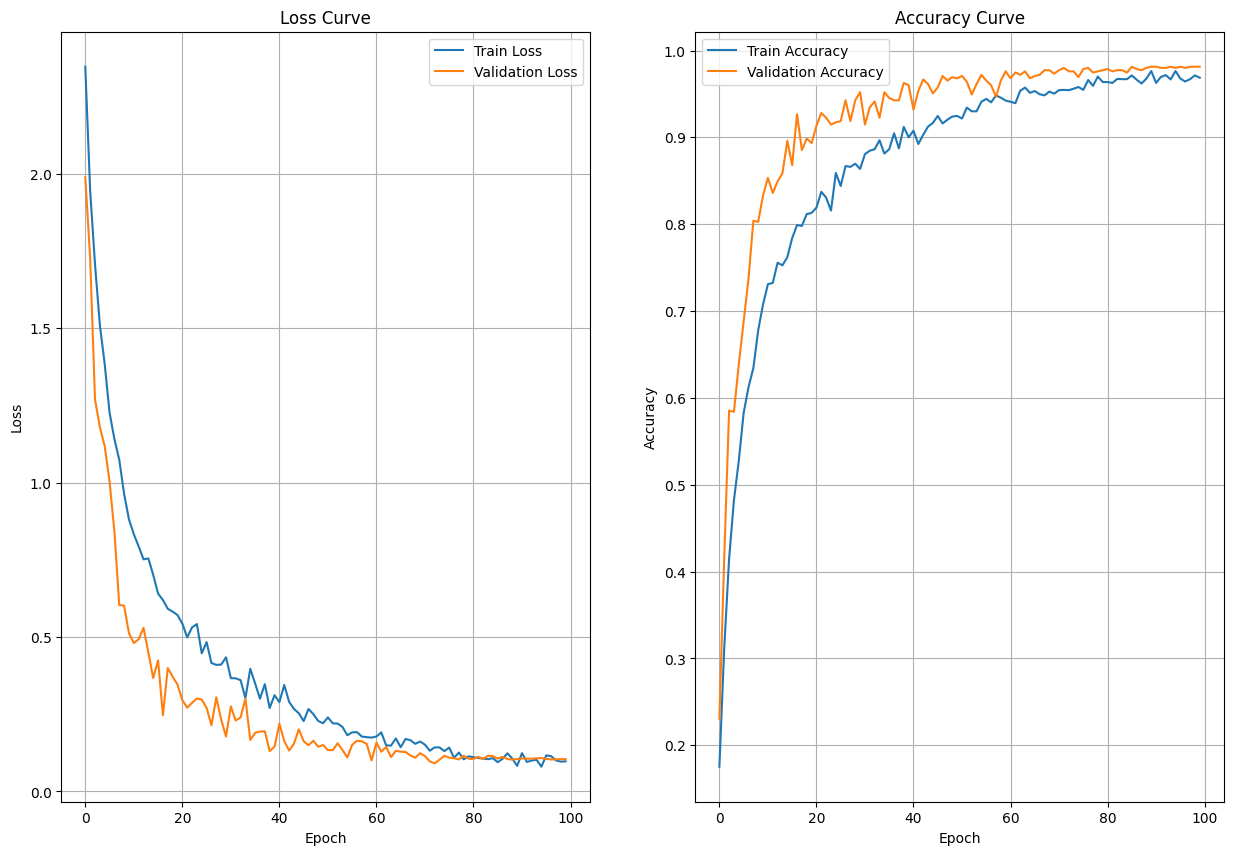

In [ ]:
loss_plot(result_dict_base)

In [ ]:
def custom_confusion_matrix(result_dict, test_dataset):
  """
  Plot a confusion matrix using the best performing epoch.

  Parameters
    result_dict (dict): Dictionary returned by the training routine
                        containing best_preds and best_labels
    test_dataset (Dataset): Dataset object that provides class names
  """
  
  all_labels = result_dict["best_labels"]
  all_preds = result_dict["best_preds"]
  cm = confusion_matrix(all_labels, all_preds)

  class_names = train_dataset.classes

  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names ,cmap="Blues")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Class")
  plt.ylabel("True Class")
  plt.show()

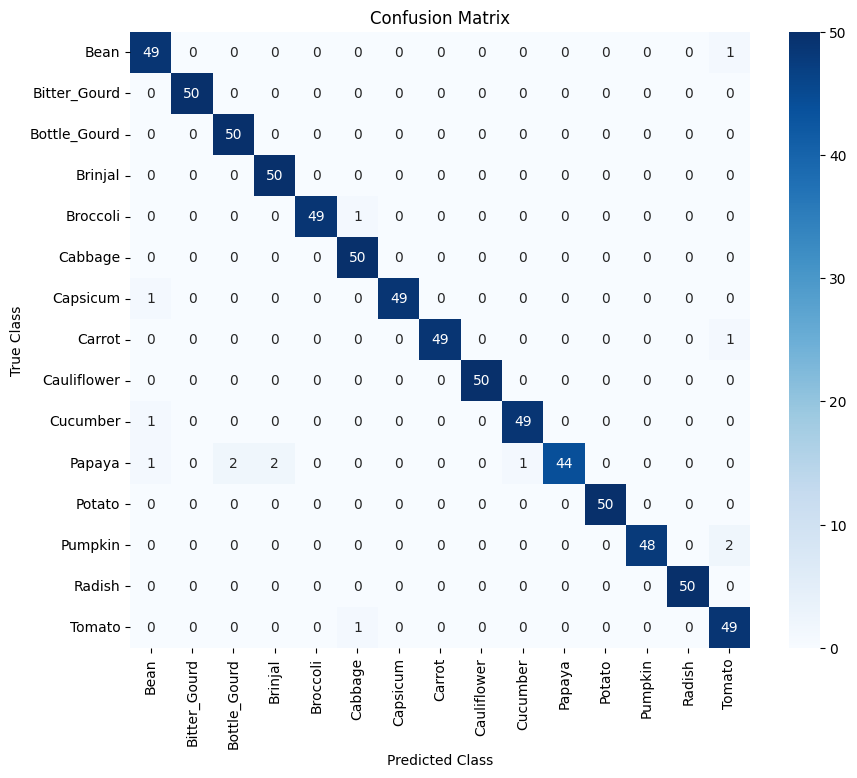

In [22]:
custom_confusion_matrix(result_dict_base, test_dataset)

Learning rate and batch size were selected to create a stable and efficient training process while staying consistent with common practices in deep learning research. The initial learning rate was set to 0.001 because this value is widely regarded as a stable default for Adam-based optimization on image classification tasks. Adam adapts per-parameter learning rates during training and performs best when the global learning rate is neither too small nor too aggressive. Empirical studies show that values around 0.001 allow the optimizer to converge quickly without causing unstable weight updates or divergence. In this project, a learning rate scheduler further refines this starting value across epochs, helping the model transition smoothly from coarse learning in early stages to more precise adjustments later in training.

Several learning rates were tested during preliminary experiments, including 0.01, 0.005, 0.001, and 0.0005. Higher rates such as 0.01 and 0.005 caused unstable training and occasional divergence, while lower rates like 0.0005 led to very slow convergence. After these trials, 0.001 was selected as the optimal balance between stability and speed of convergence.

The batch size was set to 32 for both practical and methodological reasons. From a computational perspective, this size fits comfortably into typical GPU memory limits while still providing efficient parallel computation. From an optimization standpoint, a batch size of 32 offers a balanced gradient estimate. Smaller batches introduce too much noise, slowing down convergence, while larger batches reduce noise but often lead to poorer generalization and higher memory requirements. Experiments with batch sizes of 16, 32, and 64 showed that 16 led to slightly noisier gradients, slowing convergence, and 64 required more memory with no clear improvement in accuracy. Therefore, a batch size of 32 was chosen as the most effective compromise.

### References

[1] Kingma D Ba J 2015 Adam a method for stochastic optimization *International Conference on Learning Representations* [PDF](https://arxiv.org/abs/1412.6980)

[2] Keskar N Mudigere D Nocedal J Smelyanskiy M Tang P 2017 On large batch training for deep learning generalization gap and sharp minima *International Conference on Learning Representations* [PDF](https://arxiv.org/abs/1609.04836)


### 1.6 Evaluate the trained model on the test set (5 points)

In [ ]:
def model_test(model, test_loader):
  """
  Run the trained model on the test set and collect predictions.

  Parameters
    model (torch.nn.Module): Trained model
    test_loader (DataLoader): Data loader for the test set

  Returns
    list: Predicted class indices for all test images
  """

  model.eval()

  all_preds = []
  with torch.no_grad():
    for (inputs, _) in tqdm(test_loader):
      inputs = inputs.to(device)
      outputs = model(inputs)

      _, preds = torch.max(outputs, 1)
      all_preds.extend(preds.cpu().numpy())

  return all_preds

def create_csv(test_loader, predictions, class_idx, output_path="submission.csv"):
  """
  Create a submission CSV file mapping image filenames to predicted labels.

  Parameters
    test_loader (DataLoader): Data loader containing image file paths
    predictions (list): Predicted class indices
    class_idx (dict): Mapping between class names and class indices
    output_path (str): CSV output filename
  """

  # Find filenames of files
  full_path = test_loader.dataset.imgs
  file_paths = [item[0] for item in full_path]
  filenames = [os.path.basename(path) for path in file_paths]

  # Find preds from indexs
  idx = {i: j for j, i in class_idx.items()}
  preds = [idx[pred_idx] for pred_idx in predictions]

  df = pd.DataFrame({
        'Id': filenames,
        'label': preds
    })
    
  df.to_csv(output_path, index=False)

In [47]:
model.load_state_dict(torch.load("base_cnn_best_model.pth"))

<All keys matched successfully>

In [48]:
all_preds = model_test(model,test_loader)

100%|██████████| 24/24 [00:03<00:00,  6.37it/s]


In [49]:
create_csv(test_loader, all_preds, train_dataset.class_to_idx, "base_cnn.csv")

### 1.7 Conclusion and interpretation (7 points)

#### Model Evaluation
| Stage                     | Accuracy | Precision | Recall | F1 Score | Loss   |
| ------------------------- | -------- | --------- | ------ | -------- | ------ |
| **Train (Epoch 86)**      | 0.9713   | 0.9714    | 0.9713 | 0.9713   | 0.0945 |
| **Validation (Epoch 86)** | 0.9813   | 0.9821    | 0.9813 | 0.9813   | 0.1065 |

The evaluation process combined training and validation results with external test performance to present a coherent view of the model’s generalization ability. At epoch 86 the model achieved a training accuracy of 0.9713 with a loss of 0.0945 and a validation accuracy of 0.9813 with a loss of 0.1065. The closeness of these values shows that the network maintained a healthy balance without drifting into overfitting or underfitting. The consistent downward trend in both training and validation loss indicates that the optimization process converged steadily.

Test performance on Kaggle progressed across three experimental setups. The baseline CNN obtained 0.968, adding data augmentation improved this to 0.995 and incorporating architectural and optimization refinements yielded a perfect score of 1.000. These results surpass the validation accuracy. Since the full Kaggle test set is not visible the precise distribution of evaluated samples is unknown. It is therefore plausible that difficult categories such as papaya are underrepresented in the hidden portion of the test set. This can create an inflated sense of model performance despite not fully reflecting real world distributional challenges.

#### Challenges Encountered
The primary challenge was the limited dataset size which constrained the model’s ability to form broad and stable representations. Data augmentation reduced this limitation by artificially expanding the diversity of images. Another difficulty was the slow early stage convergence when using SGD. Switching to Adam significantly accelerated the optimization path. The papaya class remained problematic due to low sample count and strong visual overlap with other fruits which makes its boundaries harder to learn. Focused preprocessing and targeted augmentation provided partial relief.

#### Potential Areas for Improvement
Stronger class targeted augmentation particularly for papaya would help improve class separation. The augmentation pipeline could be expanded with grayscale perturbations richer color jitter or mixup style transformations. Ensemble strategies in which multiple models trained with different augmentation settings vote on predictions could improve robustness. A confidence based secondary verification step for ambiguous predictions may also boost reliability. Finally stratified k fold validation would yield a more trustworthy estimate of generalization given the uncertainty in the hidden test distribution.

#### Reflection on the Architecture and Training Strategy
The chosen CNN architecture proved well suited to the task offering enough representational depth without excessive complexity. Its progression from low level to high level feature extraction captured the essential structures in the vegetable images while maintaining computational efficiency. The combination of Adam and cosine annealing produced rapid early learning and smooth later convergence. Data augmentation played a decisive role in the model’s ability to generalize beyond the limited dataset.

Taken together the architecture the optimization strategy and the augmentation pipeline formed a coherent and effective training system. The model performed reliably under limited data and class imbalance conditions. With further class specific refinement and broader augmentation this framework is well positioned for continued improvement in future evaluations.


### 1.8 Kaggle Test Result (5 points)
* Kaggle Name: Gökdeniz Kuruca
* Result 1.00

## 2. Exploring Transfer Learning with ResNet50 and MobileNet (60 points)

### 2.1. Introduction
The second phase of this project focuses on applying transfer learning techniques to the vegetable classification problem. Transfer learning leverages pre-trained convolutional neural networks, such as ResNet-18 and MobileNet, which have already learned rich visual representations from large-scale datasets like ImageNet. Instead of training a network entirely from scratch, transfer learning allows the model to reuse these pre-trained features, significantly reducing training time and improving performance, particularly in scenarios with limited data.

Fine-tuning is the process of selectively updating certain layers of a pre-trained network while keeping the remaining layers frozen. Typically, the earlier layers, which capture generic low-level features such as edges and textures, are frozen because these representations are broadly applicable across different tasks. Later layers, which encode higher-level, task-specific abstractions, are unfrozen and trained on the new dataset to adapt the model to the specific classification problem at hand. This approach provides a balance between leveraging learned knowledge and specializing the network for the new task.

Freezing the majority of the network reduces the risk of overfitting, limits computational cost, and stabilizes gradient flow during training. By updating only the last few layers, the network can focus on learning task-relevant distinctions while retaining robust general visual features from pre-training. This methodology is widely adopted in modern computer vision tasks and has been shown to achieve high performance with relatively small datasets.

### 2.2. Load the pre-trained ResNet18 model (3 points)


In [ ]:
# Create models and model types for fine tune

class Models(Enum):
  RESNET = 0
  MOBILENET = 1

class ModelTypes(Enum):
  FC = 0
  HALF = 1
  FULL = 2

In [ ]:
def model_loader(model_name,model_type):
  """
  Load a predefined model, optionally freeze layers, and replace the final classification layer.

  Parameters
    model_name (Models): Enum value selecting which backbone to load
    model_type (ModelTypes): Enum value defining which parts of the model remain trainable

  Returns
    model (torch.nn.Module): Configured model ready for training
    params (list): List of parameters that will be optimized
  """

  model = None
  params = None
  
  if model_name == Models.RESNET:
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
  elif model_name == Models.MOBILENET:
    model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
  else:
    return None, None

  if model_type == ModelTypes.FC or model_type == ModelTypes.HALF :
    for param in model.parameters():
      param.requires_grad = False

  if model_name == Models.RESNET:
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, 15)
    if model_type == ModelTypes.HALF:
      for param in model.layer3.parameters():
        param.requires_grad = True

      for param in model.layer4.parameters():
        param.requires_grad = True

  if model_name == Models.MOBILENET:
    n_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(n_features, 15)

  params = [p for p in model.parameters() if p.requires_grad]

  return model,params

### 2.3 Modify the ResNet18 model for transfer learning (15 points)

In [52]:
model_resnet_fc, resnet_fc_params = model_loader(Models.RESNET, ModelTypes.FC)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Gökdeniz/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:10<00:00, 4.41MB/s]


In [62]:
from torchsummary import summary

In [64]:
model_resnet_half, resnet_half_params = model_loader(Models.RESNET, ModelTypes.HALF)

In [65]:
model_resnet_full, resnet_full_params = model_loader(Models.RESNET, ModelTypes.FULL)

In [ ]:
# Create optimizer, loss function and lr scheduler for all models
criterion = nn.CrossEntropyLoss()

optimizer_resnet_fc   = optim.Adam(resnet_fc_params,   lr=0.001)
optimizer_resnet_half = optim.Adam(resnet_half_params, lr=0.001)
optimizer_resnet_full = optim.Adam(resnet_full_params, lr=0.001)

scheduler_resnet_fc = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_resnet_fc,
    mode="min",
    factor=0.1,      
    patience=3,      
)

scheduler_resnet_half = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_resnet_half,
    mode="min",
    factor=0.1,
    patience=3,
)

scheduler_resnet_full = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_resnet_full,
    mode="min",
    factor=0.1,
    patience=3,
)


In [67]:
model_resnet_fc.to(device)
summary(model_resnet_fc, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [72]:
result_dict_resnet_fc = model_train_val(model_resnet_fc,train_loader,val_loader,criterion,optimizer_resnet_fc,scheduler_resnet_fc,10,"resnet_fc",N_EPOCH)

-------------------
Epoch 1/100

Train started...


Training Epoch 1: 100%|██████████| 94/94 [00:23<00:00,  4.04it/s]


Train Loss: 1.8664
Train Scores:
Accuracy Score: 0.5190
Precision Score: 0.5215
Recall Score: 0.5190
F1 Score: 0.5179

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.31it/s]


Validation Loss: 0.8893
Validation Scores:
Accuracy Score: 0.8400
Precision Score: 0.8918
Recall Score: 0.8400
F1 Score: 0.8431
New best model saved. Validation accuracy: 0.8400
-------------------
Epoch 2/100

Train started...


Training Epoch 2: 100%|██████████| 94/94 [00:25<00:00,  3.67it/s]


Train Loss: 0.9854
Train Scores:
Accuracy Score: 0.7840
Precision Score: 0.7853
Recall Score: 0.7840
F1 Score: 0.7835

Validation started...


100%|██████████| 24/24 [00:04<00:00,  5.50it/s]


Validation Loss: 0.5043
Validation Scores:
Accuracy Score: 0.9120
Precision Score: 0.9258
Recall Score: 0.9120
F1 Score: 0.9102
New best model saved. Validation accuracy: 0.9120
-------------------
Epoch 3/100

Train started...


Training Epoch 3: 100%|██████████| 94/94 [00:26<00:00,  3.58it/s]


Train Loss: 0.7376
Train Scores:
Accuracy Score: 0.8330
Precision Score: 0.8353
Recall Score: 0.8330
F1 Score: 0.8331

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.19it/s]


Validation Loss: 0.3543
Validation Scores:
Accuracy Score: 0.9307
Precision Score: 0.9417
Recall Score: 0.9307
F1 Score: 0.9302
New best model saved. Validation accuracy: 0.9307
-------------------
Epoch 4/100

Train started...


Training Epoch 4: 100%|██████████| 94/94 [00:23<00:00,  3.99it/s]


Train Loss: 0.6325
Train Scores:
Accuracy Score: 0.8373
Precision Score: 0.8385
Recall Score: 0.8373
F1 Score: 0.8373

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.89it/s]


Validation Loss: 0.2640
Validation Scores:
Accuracy Score: 0.9520
Precision Score: 0.9562
Recall Score: 0.9520
F1 Score: 0.9524
New best model saved. Validation accuracy: 0.9520
-------------------
Epoch 5/100

Train started...


Training Epoch 5: 100%|██████████| 94/94 [00:26<00:00,  3.61it/s]


Train Loss: 0.5514
Train Scores:
Accuracy Score: 0.8637
Precision Score: 0.8654
Recall Score: 0.8637
F1 Score: 0.8639

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.12it/s]


Validation Loss: 0.2563
Validation Scores:
Accuracy Score: 0.9413
Precision Score: 0.9459
Recall Score: 0.9413
F1 Score: 0.9405
-------------------
Epoch 6/100

Train started...


Training Epoch 6: 100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Train Loss: 0.5348
Train Scores:
Accuracy Score: 0.8620
Precision Score: 0.8630
Recall Score: 0.8620
F1 Score: 0.8620

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.25it/s]


Validation Loss: 0.2370
Validation Scores:
Accuracy Score: 0.9440
Precision Score: 0.9531
Recall Score: 0.9440
F1 Score: 0.9450
-------------------
Epoch 7/100

Train started...


Training Epoch 7: 100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Train Loss: 0.4683
Train Scores:
Accuracy Score: 0.8727
Precision Score: 0.8731
Recall Score: 0.8727
F1 Score: 0.8727

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.81it/s]


Validation Loss: 0.1722
Validation Scores:
Accuracy Score: 0.9653
Precision Score: 0.9673
Recall Score: 0.9653
F1 Score: 0.9655
New best model saved. Validation accuracy: 0.9653
-------------------
Epoch 8/100

Train started...


Training Epoch 8: 100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Train Loss: 0.4466
Train Scores:
Accuracy Score: 0.8733
Precision Score: 0.8738
Recall Score: 0.8733
F1 Score: 0.8732

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.45it/s]


Validation Loss: 0.1674
Validation Scores:
Accuracy Score: 0.9680
Precision Score: 0.9703
Recall Score: 0.9680
F1 Score: 0.9680
New best model saved. Validation accuracy: 0.9680
-------------------
Epoch 9/100

Train started...


Training Epoch 9: 100%|██████████| 94/94 [00:23<00:00,  4.03it/s]


Train Loss: 0.4313
Train Scores:
Accuracy Score: 0.8827
Precision Score: 0.8838
Recall Score: 0.8827
F1 Score: 0.8827

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.68it/s]


Validation Loss: 0.1562
Validation Scores:
Accuracy Score: 0.9707
Precision Score: 0.9719
Recall Score: 0.9707
F1 Score: 0.9703
New best model saved. Validation accuracy: 0.9707
-------------------
Epoch 10/100

Train started...


Training Epoch 10: 100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Train Loss: 0.4069
Train Scores:
Accuracy Score: 0.8900
Precision Score: 0.8906
Recall Score: 0.8900
F1 Score: 0.8899

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.83it/s]


Validation Loss: 0.1330
Validation Scores:
Accuracy Score: 0.9707
Precision Score: 0.9720
Recall Score: 0.9707
F1 Score: 0.9708
-------------------
Epoch 11/100

Train started...


Training Epoch 11: 100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Train Loss: 0.3973
Train Scores:
Accuracy Score: 0.8933
Precision Score: 0.8938
Recall Score: 0.8933
F1 Score: 0.8933

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.49it/s]


Validation Loss: 0.1307
Validation Scores:
Accuracy Score: 0.9747
Precision Score: 0.9756
Recall Score: 0.9747
F1 Score: 0.9747
New best model saved. Validation accuracy: 0.9747
-------------------
Epoch 12/100

Train started...


Training Epoch 12: 100%|██████████| 94/94 [00:22<00:00,  4.12it/s]


Train Loss: 0.3778
Train Scores:
Accuracy Score: 0.8950
Precision Score: 0.8954
Recall Score: 0.8950
F1 Score: 0.8950

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.51it/s]


Validation Loss: 0.1382
Validation Scores:
Accuracy Score: 0.9707
Precision Score: 0.9726
Recall Score: 0.9707
F1 Score: 0.9698
-------------------
Epoch 13/100

Train started...


Training Epoch 13: 100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


Train Loss: 0.3755
Train Scores:
Accuracy Score: 0.8890
Precision Score: 0.8896
Recall Score: 0.8890
F1 Score: 0.8890

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.68it/s]


Validation Loss: 0.1354
Validation Scores:
Accuracy Score: 0.9747
Precision Score: 0.9772
Recall Score: 0.9747
F1 Score: 0.9747
-------------------
Epoch 14/100

Train started...


Training Epoch 14: 100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Train Loss: 0.3738
Train Scores:
Accuracy Score: 0.8903
Precision Score: 0.8904
Recall Score: 0.8903
F1 Score: 0.8903

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.88it/s]


Validation Loss: 0.1046
Validation Scores:
Accuracy Score: 0.9747
Precision Score: 0.9755
Recall Score: 0.9747
F1 Score: 0.9747
-------------------
Epoch 15/100

Train started...


Training Epoch 15: 100%|██████████| 94/94 [00:23<00:00,  4.01it/s]


Train Loss: 0.3800
Train Scores:
Accuracy Score: 0.8853
Precision Score: 0.8857
Recall Score: 0.8853
F1 Score: 0.8853

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.66it/s]


Validation Loss: 0.1028
Validation Scores:
Accuracy Score: 0.9787
Precision Score: 0.9794
Recall Score: 0.9787
F1 Score: 0.9787
New best model saved. Validation accuracy: 0.9787
-------------------
Epoch 16/100

Train started...


Training Epoch 16: 100%|██████████| 94/94 [00:23<00:00,  3.98it/s]


Train Loss: 0.3571
Train Scores:
Accuracy Score: 0.8973
Precision Score: 0.8978
Recall Score: 0.8973
F1 Score: 0.8973

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.53it/s]


Validation Loss: 0.1225
Validation Scores:
Accuracy Score: 0.9667
Precision Score: 0.9700
Recall Score: 0.9667
F1 Score: 0.9671
-------------------
Epoch 17/100

Train started...


Training Epoch 17: 100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Train Loss: 0.3266
Train Scores:
Accuracy Score: 0.9063
Precision Score: 0.9068
Recall Score: 0.9063
F1 Score: 0.9064

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.96it/s]


Validation Loss: 0.1070
Validation Scores:
Accuracy Score: 0.9747
Precision Score: 0.9757
Recall Score: 0.9747
F1 Score: 0.9747
-------------------
Epoch 18/100

Train started...


Training Epoch 18: 100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Train Loss: 0.3377
Train Scores:
Accuracy Score: 0.9027
Precision Score: 0.9033
Recall Score: 0.9027
F1 Score: 0.9027

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.29it/s]


Validation Loss: 0.1011
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9814
Recall Score: 0.9800
F1 Score: 0.9800
New best model saved. Validation accuracy: 0.9800
-------------------
Epoch 19/100

Train started...


Training Epoch 19: 100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Train Loss: 0.3260
Train Scores:
Accuracy Score: 0.9040
Precision Score: 0.9042
Recall Score: 0.9040
F1 Score: 0.9039

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.51it/s]


Validation Loss: 0.0954
Validation Scores:
Accuracy Score: 0.9773
Precision Score: 0.9783
Recall Score: 0.9773
F1 Score: 0.9773
-------------------
Epoch 20/100

Train started...


Training Epoch 20: 100%|██████████| 94/94 [00:23<00:00,  3.99it/s]


Train Loss: 0.3248
Train Scores:
Accuracy Score: 0.9057
Precision Score: 0.9057
Recall Score: 0.9057
F1 Score: 0.9055

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.27it/s]


Validation Loss: 0.0929
Validation Scores:
Accuracy Score: 0.9760
Precision Score: 0.9769
Recall Score: 0.9760
F1 Score: 0.9759
-------------------
Epoch 21/100

Train started...


Training Epoch 21: 100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Train Loss: 0.3215
Train Scores:
Accuracy Score: 0.9007
Precision Score: 0.9011
Recall Score: 0.9007
F1 Score: 0.9007

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.53it/s]


Validation Loss: 0.1057
Validation Scores:
Accuracy Score: 0.9733
Precision Score: 0.9753
Recall Score: 0.9733
F1 Score: 0.9733
-------------------
Epoch 22/100

Train started...


Training Epoch 22: 100%|██████████| 94/94 [00:25<00:00,  3.71it/s]


Train Loss: 0.3197
Train Scores:
Accuracy Score: 0.9017
Precision Score: 0.9021
Recall Score: 0.9017
F1 Score: 0.9017

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.41it/s]


Validation Loss: 0.0827
Validation Scores:
Accuracy Score: 0.9813
Precision Score: 0.9817
Recall Score: 0.9813
F1 Score: 0.9813
New best model saved. Validation accuracy: 0.9813
-------------------
Epoch 23/100

Train started...


Training Epoch 23: 100%|██████████| 94/94 [00:22<00:00,  4.26it/s]


Train Loss: 0.3246
Train Scores:
Accuracy Score: 0.9010
Precision Score: 0.9012
Recall Score: 0.9010
F1 Score: 0.9009

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.74it/s]


Validation Loss: 0.0808
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9805
Recall Score: 0.9800
F1 Score: 0.9799
-------------------
Epoch 24/100

Train started...


Training Epoch 24: 100%|██████████| 94/94 [00:23<00:00,  4.06it/s]


Train Loss: 0.3006
Train Scores:
Accuracy Score: 0.9040
Precision Score: 0.9041
Recall Score: 0.9040
F1 Score: 0.9040

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.54it/s]


Validation Loss: 0.1093
Validation Scores:
Accuracy Score: 0.9693
Precision Score: 0.9740
Recall Score: 0.9693
F1 Score: 0.9696
-------------------
Epoch 25/100

Train started...


Training Epoch 25: 100%|██████████| 94/94 [00:22<00:00,  4.12it/s]


Train Loss: 0.3155
Train Scores:
Accuracy Score: 0.8977
Precision Score: 0.8981
Recall Score: 0.8977
F1 Score: 0.8976

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.50it/s]


Validation Loss: 0.1061
Validation Scores:
Accuracy Score: 0.9720
Precision Score: 0.9744
Recall Score: 0.9720
F1 Score: 0.9723
-------------------
Epoch 26/100

Train started...


Training Epoch 26: 100%|██████████| 94/94 [00:23<00:00,  4.07it/s]


Train Loss: 0.2935
Train Scores:
Accuracy Score: 0.9110
Precision Score: 0.9111
Recall Score: 0.9110
F1 Score: 0.9110

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.60it/s]


Validation Loss: 0.0833
Validation Scores:
Accuracy Score: 0.9787
Precision Score: 0.9797
Recall Score: 0.9787
F1 Score: 0.9786
-------------------
Epoch 27/100

Train started...


Training Epoch 27: 100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Train Loss: 0.3143
Train Scores:
Accuracy Score: 0.9007
Precision Score: 0.9010
Recall Score: 0.9007
F1 Score: 0.9006

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.22it/s]


Validation Loss: 0.1061
Validation Scores:
Accuracy Score: 0.9680
Precision Score: 0.9715
Recall Score: 0.9680
F1 Score: 0.9680
-------------------
Epoch 28/100

Train started...


Training Epoch 28: 100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Train Loss: 0.2903
Train Scores:
Accuracy Score: 0.9140
Precision Score: 0.9144
Recall Score: 0.9140
F1 Score: 0.9139

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.18it/s]


Validation Loss: 0.0740
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9806
Recall Score: 0.9800
F1 Score: 0.9799
-------------------
Epoch 29/100

Train started...


Training Epoch 29: 100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Train Loss: 0.2803
Train Scores:
Accuracy Score: 0.9147
Precision Score: 0.9150
Recall Score: 0.9147
F1 Score: 0.9148

Validation started...


100%|██████████| 24/24 [00:04<00:00,  5.21it/s]


Validation Loss: 0.0691
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9804
Recall Score: 0.9800
F1 Score: 0.9799
-------------------
Epoch 30/100

Train started...


Training Epoch 30: 100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Train Loss: 0.2868
Train Scores:
Accuracy Score: 0.9120
Precision Score: 0.9124
Recall Score: 0.9120
F1 Score: 0.9119

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.40it/s]


Validation Loss: 0.0791
Validation Scores:
Accuracy Score: 0.9827
Precision Score: 0.9836
Recall Score: 0.9827
F1 Score: 0.9826
New best model saved. Validation accuracy: 0.9827
-------------------
Epoch 31/100

Train started...


Training Epoch 31: 100%|██████████| 94/94 [00:23<00:00,  3.95it/s]


Train Loss: 0.2701
Train Scores:
Accuracy Score: 0.9163
Precision Score: 0.9166
Recall Score: 0.9163
F1 Score: 0.9163

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.22it/s]


Validation Loss: 0.0723
Validation Scores:
Accuracy Score: 0.9827
Precision Score: 0.9831
Recall Score: 0.9827
F1 Score: 0.9826
-------------------
Epoch 32/100

Train started...


Training Epoch 32: 100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Train Loss: 0.2652
Train Scores:
Accuracy Score: 0.9307
Precision Score: 0.9309
Recall Score: 0.9307
F1 Score: 0.9306

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.42it/s]


Validation Loss: 0.0737
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9804
Recall Score: 0.9800
F1 Score: 0.9799
-------------------
Epoch 33/100

Train started...


Training Epoch 33: 100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Train Loss: 0.2924
Train Scores:
Accuracy Score: 0.9120
Precision Score: 0.9126
Recall Score: 0.9120
F1 Score: 0.9121

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.09it/s]


Validation Loss: 0.0699
Validation Scores:
Accuracy Score: 0.9827
Precision Score: 0.9829
Recall Score: 0.9827
F1 Score: 0.9826
-------------------
Epoch 34/100

Train started...


Training Epoch 34: 100%|██████████| 94/94 [00:23<00:00,  4.00it/s]


Train Loss: 0.2950
Train Scores:
Accuracy Score: 0.9090
Precision Score: 0.9093
Recall Score: 0.9090
F1 Score: 0.9088

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.06it/s]


Validation Loss: 0.0750
Validation Scores:
Accuracy Score: 0.9827
Precision Score: 0.9832
Recall Score: 0.9827
F1 Score: 0.9826
-------------------
Epoch 35/100

Train started...


Training Epoch 35: 100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Train Loss: 0.2838
Train Scores:
Accuracy Score: 0.9133
Precision Score: 0.9145
Recall Score: 0.9133
F1 Score: 0.9135

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.01it/s]


Validation Loss: 0.0703
Validation Scores:
Accuracy Score: 0.9840
Precision Score: 0.9845
Recall Score: 0.9840
F1 Score: 0.9839
New best model saved. Validation accuracy: 0.9840
-------------------
Epoch 36/100

Train started...


Training Epoch 36: 100%|██████████| 94/94 [00:24<00:00,  3.76it/s]


Train Loss: 0.2756
Train Scores:
Accuracy Score: 0.9157
Precision Score: 0.9162
Recall Score: 0.9157
F1 Score: 0.9157

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.14it/s]


Validation Loss: 0.0721
Validation Scores:
Accuracy Score: 0.9813
Precision Score: 0.9818
Recall Score: 0.9813
F1 Score: 0.9812
-------------------
Epoch 37/100

Train started...


Training Epoch 37: 100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Train Loss: 0.2612
Train Scores:
Accuracy Score: 0.9247
Precision Score: 0.9252
Recall Score: 0.9247
F1 Score: 0.9246

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.73it/s]


Validation Loss: 0.0707
Validation Scores:
Accuracy Score: 0.9827
Precision Score: 0.9834
Recall Score: 0.9827
F1 Score: 0.9826
-------------------
Epoch 38/100

Train started...


Training Epoch 38: 100%|██████████| 94/94 [00:23<00:00,  3.93it/s]


Train Loss: 0.2557
Train Scores:
Accuracy Score: 0.9233
Precision Score: 0.9237
Recall Score: 0.9233
F1 Score: 0.9234

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.02it/s]


Validation Loss: 0.0771
Validation Scores:
Accuracy Score: 0.9840
Precision Score: 0.9848
Recall Score: 0.9840
F1 Score: 0.9839
-------------------
Epoch 39/100

Train started...


Training Epoch 39: 100%|██████████| 94/94 [00:23<00:00,  4.04it/s]


Train Loss: 0.2801
Train Scores:
Accuracy Score: 0.9157
Precision Score: 0.9163
Recall Score: 0.9157
F1 Score: 0.9156

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.78it/s]


Validation Loss: 0.0696
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9803
Recall Score: 0.9800
F1 Score: 0.9799
-------------------
Epoch 40/100

Train started...


Training Epoch 40: 100%|██████████| 94/94 [00:24<00:00,  3.78it/s]


Train Loss: 0.2776
Train Scores:
Accuracy Score: 0.9133
Precision Score: 0.9136
Recall Score: 0.9133
F1 Score: 0.9132

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.12it/s]


Validation Loss: 0.0749
Validation Scores:
Accuracy Score: 0.9827
Precision Score: 0.9834
Recall Score: 0.9827
F1 Score: 0.9826
-------------------
Epoch 41/100

Train started...


Training Epoch 41: 100%|██████████| 94/94 [00:23<00:00,  3.98it/s]


Train Loss: 0.2753
Train Scores:
Accuracy Score: 0.9153
Precision Score: 0.9156
Recall Score: 0.9153
F1 Score: 0.9154

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.70it/s]


Validation Loss: 0.0769
Validation Scores:
Accuracy Score: 0.9813
Precision Score: 0.9823
Recall Score: 0.9813
F1 Score: 0.9813
-------------------
Epoch 42/100

Train started...


Training Epoch 42: 100%|██████████| 94/94 [00:23<00:00,  3.98it/s]


Train Loss: 0.2733
Train Scores:
Accuracy Score: 0.9237
Precision Score: 0.9244
Recall Score: 0.9237
F1 Score: 0.9237

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.05it/s]


Validation Loss: 0.0746
Validation Scores:
Accuracy Score: 0.9813
Precision Score: 0.9821
Recall Score: 0.9813
F1 Score: 0.9813
-------------------
Epoch 43/100

Train started...


Training Epoch 43: 100%|██████████| 94/94 [00:23<00:00,  3.96it/s]


Train Loss: 0.2781
Train Scores:
Accuracy Score: 0.9170
Precision Score: 0.9172
Recall Score: 0.9170
F1 Score: 0.9170

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.99it/s]


Validation Loss: 0.0701
Validation Scores:
Accuracy Score: 0.9840
Precision Score: 0.9843
Recall Score: 0.9840
F1 Score: 0.9839
-------------------
Epoch 44/100

Train started...


Training Epoch 44: 100%|██████████| 94/94 [00:23<00:00,  3.97it/s]


Train Loss: 0.2791
Train Scores:
Accuracy Score: 0.9157
Precision Score: 0.9162
Recall Score: 0.9157
F1 Score: 0.9157

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.68it/s]


Validation Loss: 0.0719
Validation Scores:
Accuracy Score: 0.9853
Precision Score: 0.9859
Recall Score: 0.9853
F1 Score: 0.9852
New best model saved. Validation accuracy: 0.9853
-------------------
Epoch 45/100

Train started...


Training Epoch 45: 100%|██████████| 94/94 [00:23<00:00,  3.94it/s]


Train Loss: 0.3010
Train Scores:
Accuracy Score: 0.9060
Precision Score: 0.9066
Recall Score: 0.9060
F1 Score: 0.9060

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.14it/s]


Validation Loss: 0.0721
Validation Scores:
Accuracy Score: 0.9827
Precision Score: 0.9832
Recall Score: 0.9827
F1 Score: 0.9826
-------------------
Epoch 46/100

Train started...


Training Epoch 46: 100%|██████████| 94/94 [00:25<00:00,  3.62it/s]


Train Loss: 0.2852
Train Scores:
Accuracy Score: 0.9050
Precision Score: 0.9061
Recall Score: 0.9050
F1 Score: 0.9052

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.16it/s]


Validation Loss: 0.0766
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9806
Recall Score: 0.9800
F1 Score: 0.9799
-------------------
Epoch 47/100

Train started...


Training Epoch 47: 100%|██████████| 94/94 [00:26<00:00,  3.57it/s]


Train Loss: 0.2596
Train Scores:
Accuracy Score: 0.9230
Precision Score: 0.9237
Recall Score: 0.9230
F1 Score: 0.9230

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.27it/s]


Validation Loss: 0.0697
Validation Scores:
Accuracy Score: 0.9827
Precision Score: 0.9831
Recall Score: 0.9827
F1 Score: 0.9826
-------------------
Epoch 48/100

Train started...


Training Epoch 48: 100%|██████████| 94/94 [00:25<00:00,  3.68it/s]


Train Loss: 0.2787
Train Scores:
Accuracy Score: 0.9123
Precision Score: 0.9131
Recall Score: 0.9123
F1 Score: 0.9124

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.87it/s]


Validation Loss: 0.0743
Validation Scores:
Accuracy Score: 0.9840
Precision Score: 0.9844
Recall Score: 0.9840
F1 Score: 0.9839
-------------------
Epoch 49/100

Train started...


Training Epoch 49: 100%|██████████| 94/94 [00:23<00:00,  4.03it/s]


Train Loss: 0.2734
Train Scores:
Accuracy Score: 0.9163
Precision Score: 0.9173
Recall Score: 0.9163
F1 Score: 0.9165

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.20it/s]


Validation Loss: 0.0714
Validation Scores:
Accuracy Score: 0.9840
Precision Score: 0.9846
Recall Score: 0.9840
F1 Score: 0.9839
-------------------
Epoch 50/100

Train started...


Training Epoch 50: 100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Train Loss: 0.2675
Train Scores:
Accuracy Score: 0.9143
Precision Score: 0.9148
Recall Score: 0.9143
F1 Score: 0.9143

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.68it/s]


Validation Loss: 0.0743
Validation Scores:
Accuracy Score: 0.9827
Precision Score: 0.9832
Recall Score: 0.9827
F1 Score: 0.9826
-------------------
Epoch 51/100

Train started...


Training Epoch 51: 100%|██████████| 94/94 [00:23<00:00,  4.06it/s]


Train Loss: 0.2876
Train Scores:
Accuracy Score: 0.9193
Precision Score: 0.9203
Recall Score: 0.9193
F1 Score: 0.9194

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.08it/s]


Validation Loss: 0.0741
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9806
Recall Score: 0.9800
F1 Score: 0.9799
-------------------
Epoch 52/100

Train started...


Training Epoch 52: 100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Train Loss: 0.2654
Train Scores:
Accuracy Score: 0.9187
Precision Score: 0.9188
Recall Score: 0.9187
F1 Score: 0.9185

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.62it/s]


Validation Loss: 0.0762
Validation Scores:
Accuracy Score: 0.9827
Precision Score: 0.9834
Recall Score: 0.9827
F1 Score: 0.9826
-------------------
Epoch 53/100

Train started...


Training Epoch 53: 100%|██████████| 94/94 [00:24<00:00,  3.78it/s]


Train Loss: 0.2988
Train Scores:
Accuracy Score: 0.9027
Precision Score: 0.9030
Recall Score: 0.9027
F1 Score: 0.9027

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.74it/s]


Validation Loss: 0.0777
Validation Scores:
Accuracy Score: 0.9813
Precision Score: 0.9818
Recall Score: 0.9813
F1 Score: 0.9812
-------------------
Epoch 54/100

Train started...


Training Epoch 54: 100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Train Loss: 0.2565
Train Scores:
Accuracy Score: 0.9270
Precision Score: 0.9277
Recall Score: 0.9270
F1 Score: 0.9270

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.23it/s]

Validation Loss: 0.0719
Validation Scores:
Accuracy Score: 0.9840
Precision Score: 0.9843
Recall Score: 0.9840
F1 Score: 0.9839
Early stop in 54 epoch.
Last best model accuracy: 0.9853


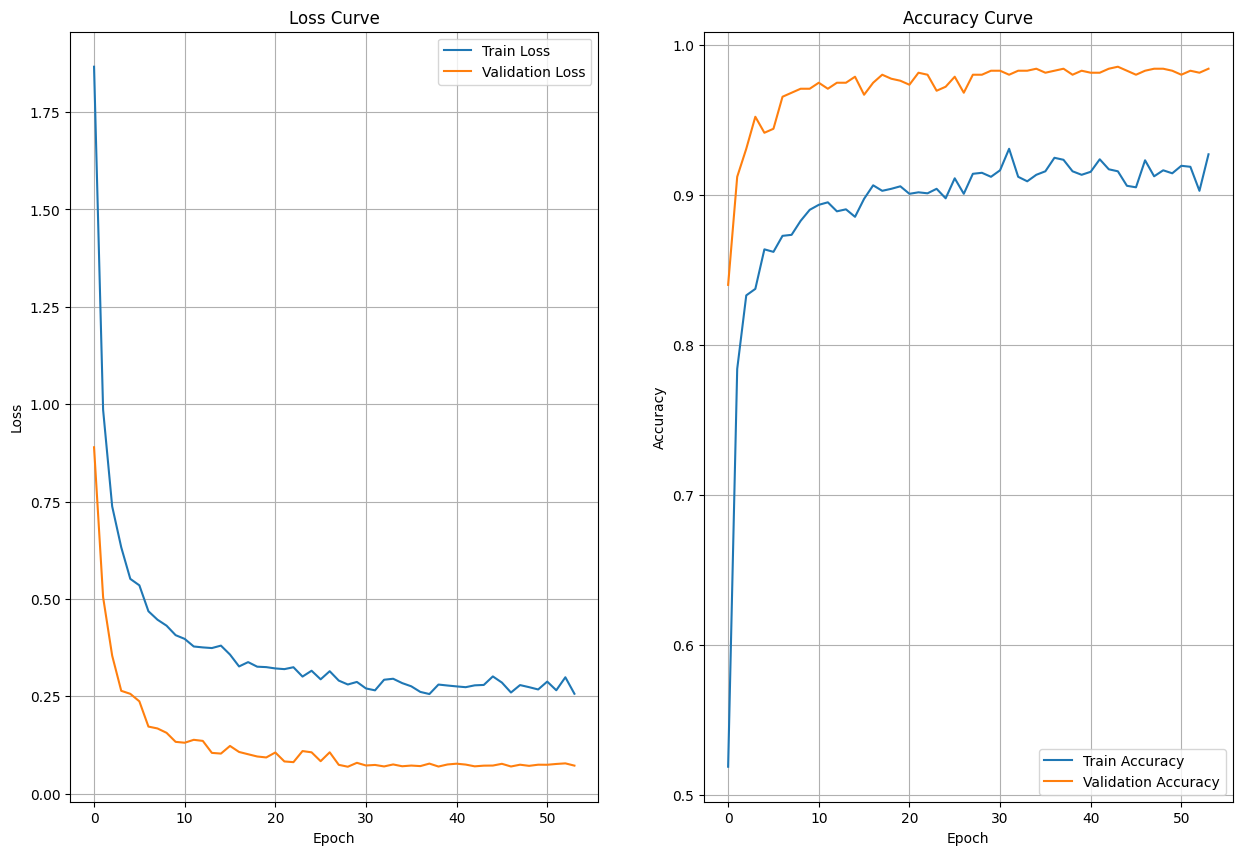

In [73]:
loss_plot(result_dict_resnet_fc)

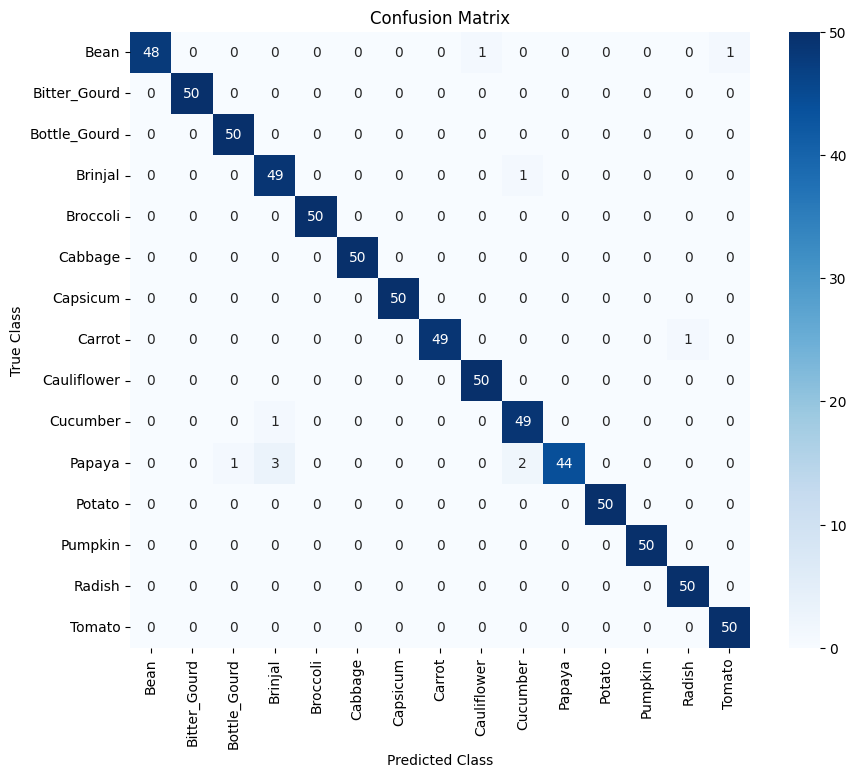

In [74]:
custom_confusion_matrix(result_dict_resnet_fc, test_dataset)

In [75]:
model_resnet_half.to(device)
summary(model_resnet_fc, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [76]:
result_dict_resnet_half = model_train_val(model_resnet_half,train_loader,val_loader,criterion,optimizer_resnet_half,scheduler_resnet_half,10,"resnet_half",N_EPOCH)

-------------------
Epoch 1/100

Train started...


Training Epoch 1: 100%|██████████| 94/94 [00:45<00:00,  2.07it/s]


Train Loss: 0.7890
Train Scores:
Accuracy Score: 0.7527
Precision Score: 0.7524
Recall Score: 0.7527
F1 Score: 0.7520

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.85it/s]


Validation Loss: 0.5116
Validation Scores:
Accuracy Score: 0.8440
Precision Score: 0.8980
Recall Score: 0.8440
F1 Score: 0.8424
New best model saved. Validation accuracy: 0.8440
-------------------
Epoch 2/100

Train started...


Training Epoch 2: 100%|██████████| 94/94 [00:29<00:00,  3.23it/s]


Train Loss: 0.4194
Train Scores:
Accuracy Score: 0.8753
Precision Score: 0.8754
Recall Score: 0.8753
F1 Score: 0.8752

Validation started...


100%|██████████| 24/24 [00:04<00:00,  5.72it/s]


Validation Loss: 0.2733
Validation Scores:
Accuracy Score: 0.9133
Precision Score: 0.9319
Recall Score: 0.9133
F1 Score: 0.9124
New best model saved. Validation accuracy: 0.9133
-------------------
Epoch 3/100

Train started...


Training Epoch 3: 100%|██████████| 94/94 [00:59<00:00,  1.58it/s]


Train Loss: 0.3999
Train Scores:
Accuracy Score: 0.8687
Precision Score: 0.8691
Recall Score: 0.8687
F1 Score: 0.8687

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


Validation Loss: 0.3340
Validation Scores:
Accuracy Score: 0.9147
Precision Score: 0.9300
Recall Score: 0.9147
F1 Score: 0.9173
New best model saved. Validation accuracy: 0.9147
-------------------
Epoch 4/100

Train started...


Training Epoch 4: 100%|██████████| 94/94 [00:44<00:00,  2.14it/s]


Train Loss: 0.4122
Train Scores:
Accuracy Score: 0.8697
Precision Score: 0.8698
Recall Score: 0.8697
F1 Score: 0.8696

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.71it/s]


Validation Loss: 0.2018
Validation Scores:
Accuracy Score: 0.9280
Precision Score: 0.9444
Recall Score: 0.9280
F1 Score: 0.9198
New best model saved. Validation accuracy: 0.9280
-------------------
Epoch 5/100

Train started...


Training Epoch 5: 100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Train Loss: 0.2549
Train Scores:
Accuracy Score: 0.9230
Precision Score: 0.9229
Recall Score: 0.9230
F1 Score: 0.9228

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.95it/s]


Validation Loss: 0.0471
Validation Scores:
Accuracy Score: 0.9827
Precision Score: 0.9834
Recall Score: 0.9827
F1 Score: 0.9827
New best model saved. Validation accuracy: 0.9827
-------------------
Epoch 6/100

Train started...


Training Epoch 6: 100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Train Loss: 0.2594
Train Scores:
Accuracy Score: 0.9233
Precision Score: 0.9235
Recall Score: 0.9233
F1 Score: 0.9233

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.02it/s]


Validation Loss: 0.1240
Validation Scores:
Accuracy Score: 0.9627
Precision Score: 0.9665
Recall Score: 0.9627
F1 Score: 0.9630
-------------------
Epoch 7/100

Train started...


Training Epoch 7: 100%|██████████| 94/94 [00:23<00:00,  4.01it/s]


Train Loss: 0.2474
Train Scores:
Accuracy Score: 0.9230
Precision Score: 0.9231
Recall Score: 0.9230
F1 Score: 0.9230

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.97it/s]


Validation Loss: 0.0488
Validation Scores:
Accuracy Score: 0.9827
Precision Score: 0.9832
Recall Score: 0.9827
F1 Score: 0.9827
-------------------
Epoch 8/100

Train started...


Training Epoch 8: 100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Train Loss: 0.2461
Train Scores:
Accuracy Score: 0.9243
Precision Score: 0.9247
Recall Score: 0.9243
F1 Score: 0.9244

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.71it/s]


Validation Loss: 0.0922
Validation Scores:
Accuracy Score: 0.9747
Precision Score: 0.9765
Recall Score: 0.9747
F1 Score: 0.9747
-------------------
Epoch 9/100

Train started...


Training Epoch 9: 100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Train Loss: 0.2371
Train Scores:
Accuracy Score: 0.9283
Precision Score: 0.9285
Recall Score: 0.9283
F1 Score: 0.9283

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.93it/s]


Validation Loss: 0.0806
Validation Scores:
Accuracy Score: 0.9747
Precision Score: 0.9771
Recall Score: 0.9747
F1 Score: 0.9746
-------------------
Epoch 10/100

Train started...


Training Epoch 10: 100%|██████████| 94/94 [00:23<00:00,  3.98it/s]


Train Loss: 0.1360
Train Scores:
Accuracy Score: 0.9540
Precision Score: 0.9543
Recall Score: 0.9540
F1 Score: 0.9540

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.06it/s]


Validation Loss: 0.0245
Validation Scores:
Accuracy Score: 0.9933
Precision Score: 0.9936
Recall Score: 0.9933
F1 Score: 0.9933
New best model saved. Validation accuracy: 0.9933
-------------------
Epoch 11/100

Train started...


Training Epoch 11: 100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Train Loss: 0.1171
Train Scores:
Accuracy Score: 0.9623
Precision Score: 0.9624
Recall Score: 0.9623
F1 Score: 0.9624

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.57it/s]


Validation Loss: 0.0219
Validation Scores:
Accuracy Score: 0.9933
Precision Score: 0.9936
Recall Score: 0.9933
F1 Score: 0.9934
-------------------
Epoch 12/100

Train started...


Training Epoch 12: 100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Train Loss: 0.1174
Train Scores:
Accuracy Score: 0.9643
Precision Score: 0.9644
Recall Score: 0.9643
F1 Score: 0.9643

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.94it/s]


Validation Loss: 0.0229
Validation Scores:
Accuracy Score: 0.9920
Precision Score: 0.9922
Recall Score: 0.9920
F1 Score: 0.9920
-------------------
Epoch 13/100

Train started...


Training Epoch 13: 100%|██████████| 94/94 [00:23<00:00,  4.00it/s]


Train Loss: 0.1024
Train Scores:
Accuracy Score: 0.9670
Precision Score: 0.9672
Recall Score: 0.9670
F1 Score: 0.9670

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.59it/s]


Validation Loss: 0.0167
Validation Scores:
Accuracy Score: 0.9960
Precision Score: 0.9961
Recall Score: 0.9960
F1 Score: 0.9960
New best model saved. Validation accuracy: 0.9960
-------------------
Epoch 14/100

Train started...


Training Epoch 14: 100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Train Loss: 0.0995
Train Scores:
Accuracy Score: 0.9717
Precision Score: 0.9718
Recall Score: 0.9717
F1 Score: 0.9717

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.94it/s]


Validation Loss: 0.0170
Validation Scores:
Accuracy Score: 0.9947
Precision Score: 0.9948
Recall Score: 0.9947
F1 Score: 0.9947
-------------------
Epoch 15/100

Train started...


Training Epoch 15: 100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Train Loss: 0.0940
Train Scores:
Accuracy Score: 0.9707
Precision Score: 0.9707
Recall Score: 0.9707
F1 Score: 0.9707

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.07it/s]


Validation Loss: 0.0185
Validation Scores:
Accuracy Score: 0.9933
Precision Score: 0.9938
Recall Score: 0.9933
F1 Score: 0.9934
-------------------
Epoch 16/100

Train started...


Training Epoch 16: 100%|██████████| 94/94 [00:24<00:00,  3.78it/s]


Train Loss: 0.0965
Train Scores:
Accuracy Score: 0.9693
Precision Score: 0.9696
Recall Score: 0.9693
F1 Score: 0.9694

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.55it/s]


Validation Loss: 0.0139
Validation Scores:
Accuracy Score: 0.9960
Precision Score: 0.9961
Recall Score: 0.9960
F1 Score: 0.9960
-------------------
Epoch 17/100

Train started...


Training Epoch 17: 100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Train Loss: 0.0911
Train Scores:
Accuracy Score: 0.9727
Precision Score: 0.9727
Recall Score: 0.9727
F1 Score: 0.9726

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.82it/s]


Validation Loss: 0.0170
Validation Scores:
Accuracy Score: 0.9947
Precision Score: 0.9949
Recall Score: 0.9947
F1 Score: 0.9947
-------------------
Epoch 18/100

Train started...


Training Epoch 18: 100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Train Loss: 0.0707
Train Scores:
Accuracy Score: 0.9783
Precision Score: 0.9784
Recall Score: 0.9783
F1 Score: 0.9783

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.09it/s]


Validation Loss: 0.0151
Validation Scores:
Accuracy Score: 0.9973
Precision Score: 0.9974
Recall Score: 0.9973
F1 Score: 0.9973
New best model saved. Validation accuracy: 0.9973
-------------------
Epoch 19/100

Train started...


Training Epoch 19: 100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Train Loss: 0.0914
Train Scores:
Accuracy Score: 0.9730
Precision Score: 0.9733
Recall Score: 0.9730
F1 Score: 0.9730

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.92it/s]


Validation Loss: 0.0135
Validation Scores:
Accuracy Score: 0.9933
Precision Score: 0.9935
Recall Score: 0.9933
F1 Score: 0.9933
-------------------
Epoch 20/100

Train started...


Training Epoch 20: 100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Train Loss: 0.0798
Train Scores:
Accuracy Score: 0.9783
Precision Score: 0.9783
Recall Score: 0.9783
F1 Score: 0.9783

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.80it/s]


Validation Loss: 0.0165
Validation Scores:
Accuracy Score: 0.9933
Precision Score: 0.9935
Recall Score: 0.9933
F1 Score: 0.9933
-------------------
Epoch 21/100

Train started...


Training Epoch 21: 100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Train Loss: 0.0730
Train Scores:
Accuracy Score: 0.9800
Precision Score: 0.9801
Recall Score: 0.9800
F1 Score: 0.9800

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.87it/s]


Validation Loss: 0.0190
Validation Scores:
Accuracy Score: 0.9933
Precision Score: 0.9936
Recall Score: 0.9933
F1 Score: 0.9934
-------------------
Epoch 22/100

Train started...


Training Epoch 22: 100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


Train Loss: 0.0786
Train Scores:
Accuracy Score: 0.9787
Precision Score: 0.9787
Recall Score: 0.9787
F1 Score: 0.9787

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


Validation Loss: 0.0175
Validation Scores:
Accuracy Score: 0.9960
Precision Score: 0.9962
Recall Score: 0.9960
F1 Score: 0.9960
-------------------
Epoch 23/100

Train started...


Training Epoch 23: 100%|██████████| 94/94 [00:51<00:00,  1.83it/s]


Train Loss: 0.0677
Train Scores:
Accuracy Score: 0.9820
Precision Score: 0.9821
Recall Score: 0.9820
F1 Score: 0.9820

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.75it/s]


Validation Loss: 0.0138
Validation Scores:
Accuracy Score: 0.9960
Precision Score: 0.9961
Recall Score: 0.9960
F1 Score: 0.9960
-------------------
Epoch 24/100

Train started...


Training Epoch 24: 100%|██████████| 94/94 [00:59<00:00,  1.57it/s]


Train Loss: 0.0755
Train Scores:
Accuracy Score: 0.9770
Precision Score: 0.9772
Recall Score: 0.9770
F1 Score: 0.9770

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.85it/s]


Validation Loss: 0.0128
Validation Scores:
Accuracy Score: 0.9960
Precision Score: 0.9961
Recall Score: 0.9960
F1 Score: 0.9960
-------------------
Epoch 25/100

Train started...


Training Epoch 25: 100%|██████████| 94/94 [01:00<00:00,  1.55it/s]


Train Loss: 0.0688
Train Scores:
Accuracy Score: 0.9797
Precision Score: 0.9797
Recall Score: 0.9797
F1 Score: 0.9796

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.09it/s]


Validation Loss: 0.0163
Validation Scores:
Accuracy Score: 0.9947
Precision Score: 0.9949
Recall Score: 0.9947
F1 Score: 0.9947
-------------------
Epoch 26/100

Train started...


Training Epoch 26: 100%|██████████| 94/94 [00:56<00:00,  1.65it/s]


Train Loss: 0.0667
Train Scores:
Accuracy Score: 0.9773
Precision Score: 0.9773
Recall Score: 0.9773
F1 Score: 0.9773

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.07it/s]


Validation Loss: 0.0136
Validation Scores:
Accuracy Score: 0.9960
Precision Score: 0.9962
Recall Score: 0.9960
F1 Score: 0.9960
-------------------
Epoch 27/100

Train started...


Training Epoch 27: 100%|██████████| 94/94 [01:02<00:00,  1.49it/s]


Train Loss: 0.0760
Train Scores:
Accuracy Score: 0.9760
Precision Score: 0.9760
Recall Score: 0.9760
F1 Score: 0.9760

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.69it/s]


Validation Loss: 0.0128
Validation Scores:
Accuracy Score: 0.9973
Precision Score: 0.9974
Recall Score: 0.9973
F1 Score: 0.9973
-------------------
Epoch 28/100

Train started...


Training Epoch 28: 100%|██████████| 94/94 [01:00<00:00,  1.55it/s]


Train Loss: 0.0659
Train Scores:
Accuracy Score: 0.9797
Precision Score: 0.9798
Recall Score: 0.9797
F1 Score: 0.9797

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.00it/s]

Validation Loss: 0.0115
Validation Scores:
Accuracy Score: 0.9960
Precision Score: 0.9961
Recall Score: 0.9960
F1 Score: 0.9960
Early stop in 28 epoch.
Last best model accuracy: 0.9973


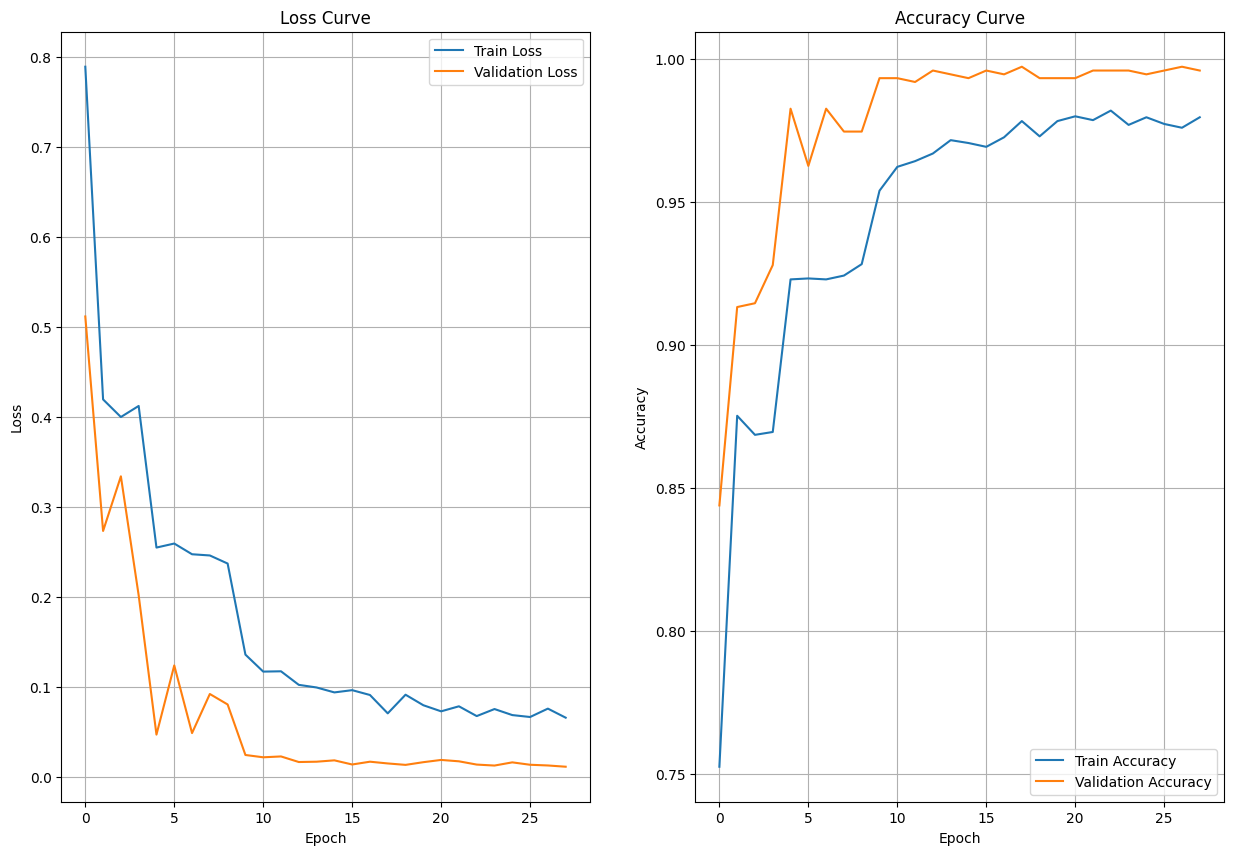

In [77]:
loss_plot(result_dict_resnet_half)

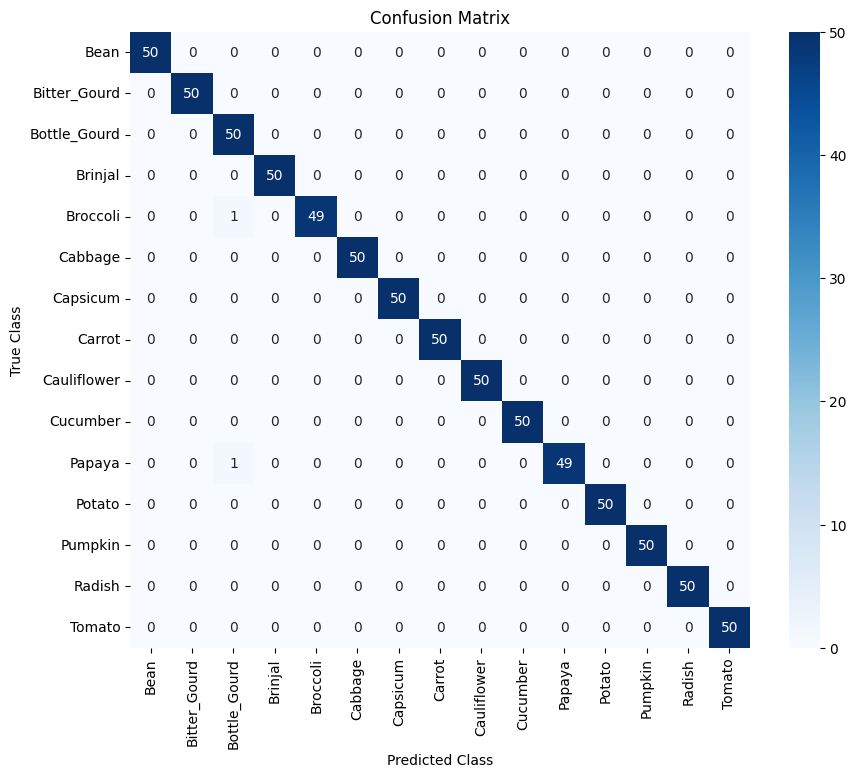

In [78]:
custom_confusion_matrix(result_dict_resnet_half, test_dataset)

In [79]:
model_resnet_full.to(device)
summary(model_resnet_fc, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [80]:
result_dict_resnet_full = model_train_val(model_resnet_full,train_loader,val_loader,criterion,optimizer_resnet_full,scheduler_resnet_full,10,"resnet_full",N_EPOCH)

-------------------
Epoch 1/100

Train started...


Training Epoch 1: 100%|██████████| 94/94 [00:42<00:00,  2.22it/s]


Train Loss: 1.1396
Train Scores:
Accuracy Score: 0.6607
Precision Score: 0.6600
Recall Score: 0.6607
F1 Score: 0.6590

Validation started...


100%|██████████| 24/24 [00:04<00:00,  6.00it/s]


Validation Loss: 1.7195
Validation Scores:
Accuracy Score: 0.5733
Precision Score: 0.7625
Recall Score: 0.5733
F1 Score: 0.5689
New best model saved. Validation accuracy: 0.5733
-------------------
Epoch 2/100

Train started...


Training Epoch 2: 100%|██████████| 94/94 [00:48<00:00,  1.96it/s]


Train Loss: 0.6742
Train Scores:
Accuracy Score: 0.7913
Precision Score: 0.7922
Recall Score: 0.7913
F1 Score: 0.7911

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.30it/s]


Validation Loss: 2.3888
Validation Scores:
Accuracy Score: 0.5307
Precision Score: 0.8052
Recall Score: 0.5307
F1 Score: 0.5302
-------------------
Epoch 3/100

Train started...


Training Epoch 3: 100%|██████████| 94/94 [00:43<00:00,  2.14it/s]


Train Loss: 0.5933
Train Scores:
Accuracy Score: 0.8143
Precision Score: 0.8156
Recall Score: 0.8143
F1 Score: 0.8145

Validation started...


100%|██████████| 24/24 [00:06<00:00,  3.70it/s]


Validation Loss: 1.1981
Validation Scores:
Accuracy Score: 0.7067
Precision Score: 0.8643
Recall Score: 0.7067
F1 Score: 0.6938
New best model saved. Validation accuracy: 0.7067
-------------------
Epoch 4/100

Train started...


Training Epoch 4: 100%|██████████| 94/94 [00:52<00:00,  1.78it/s]


Train Loss: 0.5293
Train Scores:
Accuracy Score: 0.8303
Precision Score: 0.8308
Recall Score: 0.8303
F1 Score: 0.8301

Validation started...


100%|██████████| 24/24 [00:06<00:00,  3.74it/s]


Validation Loss: 0.2392
Validation Scores:
Accuracy Score: 0.9307
Precision Score: 0.9391
Recall Score: 0.9307
F1 Score: 0.9294
New best model saved. Validation accuracy: 0.9307
-------------------
Epoch 5/100

Train started...


Training Epoch 5: 100%|██████████| 94/94 [00:56<00:00,  1.67it/s]


Train Loss: 0.4437
Train Scores:
Accuracy Score: 0.8663
Precision Score: 0.8664
Recall Score: 0.8663
F1 Score: 0.8662

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.33it/s]


Validation Loss: 0.2455
Validation Scores:
Accuracy Score: 0.9227
Precision Score: 0.9296
Recall Score: 0.9227
F1 Score: 0.9222
-------------------
Epoch 6/100

Train started...


Training Epoch 6: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]


Train Loss: 0.3949
Train Scores:
Accuracy Score: 0.8780
Precision Score: 0.8790
Recall Score: 0.8780
F1 Score: 0.8782

Validation started...


100%|██████████| 24/24 [00:06<00:00,  3.46it/s]


Validation Loss: 0.2445
Validation Scores:
Accuracy Score: 0.9053
Precision Score: 0.9300
Recall Score: 0.9053
F1 Score: 0.9076
-------------------
Epoch 7/100

Train started...


Training Epoch 7: 100%|██████████| 94/94 [00:53<00:00,  1.75it/s]


Train Loss: 0.3717
Train Scores:
Accuracy Score: 0.8860
Precision Score: 0.8865
Recall Score: 0.8860
F1 Score: 0.8861

Validation started...


100%|██████████| 24/24 [00:06<00:00,  3.59it/s]


Validation Loss: 0.1778
Validation Scores:
Accuracy Score: 0.9387
Precision Score: 0.9483
Recall Score: 0.9387
F1 Score: 0.9386
New best model saved. Validation accuracy: 0.9387
-------------------
Epoch 8/100

Train started...


Training Epoch 8: 100%|██████████| 94/94 [01:00<00:00,  1.55it/s]


Train Loss: 0.3214
Train Scores:
Accuracy Score: 0.9037
Precision Score: 0.9038
Recall Score: 0.9037
F1 Score: 0.9036

Validation started...


100%|██████████| 24/24 [00:04<00:00,  5.57it/s]


Validation Loss: 0.0986
Validation Scores:
Accuracy Score: 0.9720
Precision Score: 0.9733
Recall Score: 0.9720
F1 Score: 0.9722
New best model saved. Validation accuracy: 0.9720
-------------------
Epoch 9/100

Train started...


Training Epoch 9: 100%|██████████| 94/94 [00:31<00:00,  3.00it/s]


Train Loss: 0.2986
Train Scores:
Accuracy Score: 0.9090
Precision Score: 0.9091
Recall Score: 0.9090
F1 Score: 0.9090

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.64it/s]


Validation Loss: 0.1985
Validation Scores:
Accuracy Score: 0.9413
Precision Score: 0.9572
Recall Score: 0.9413
F1 Score: 0.9441
-------------------
Epoch 10/100

Train started...


Training Epoch 10: 100%|██████████| 94/94 [00:28<00:00,  3.26it/s]


Train Loss: 0.3232
Train Scores:
Accuracy Score: 0.9037
Precision Score: 0.9038
Recall Score: 0.9037
F1 Score: 0.9037

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.50it/s]


Validation Loss: 0.1543
Validation Scores:
Accuracy Score: 0.9507
Precision Score: 0.9555
Recall Score: 0.9507
F1 Score: 0.9512
-------------------
Epoch 11/100

Train started...


Training Epoch 11: 100%|██████████| 94/94 [00:28<00:00,  3.26it/s]


Train Loss: 0.3082
Train Scores:
Accuracy Score: 0.9040
Precision Score: 0.9043
Recall Score: 0.9040
F1 Score: 0.9040

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.40it/s]


Validation Loss: 0.1251
Validation Scores:
Accuracy Score: 0.9627
Precision Score: 0.9641
Recall Score: 0.9627
F1 Score: 0.9626
-------------------
Epoch 12/100

Train started...


Training Epoch 12: 100%|██████████| 94/94 [00:28<00:00,  3.29it/s]


Train Loss: 0.2318
Train Scores:
Accuracy Score: 0.9253
Precision Score: 0.9256
Recall Score: 0.9253
F1 Score: 0.9253

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.78it/s]


Validation Loss: 0.1694
Validation Scores:
Accuracy Score: 0.9493
Precision Score: 0.9537
Recall Score: 0.9493
F1 Score: 0.9495
-------------------
Epoch 13/100

Train started...


Training Epoch 13: 100%|██████████| 94/94 [00:28<00:00,  3.27it/s]


Train Loss: 0.1631
Train Scores:
Accuracy Score: 0.9480
Precision Score: 0.9484
Recall Score: 0.9480
F1 Score: 0.9481

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.45it/s]


Validation Loss: 0.0251
Validation Scores:
Accuracy Score: 0.9920
Precision Score: 0.9923
Recall Score: 0.9920
F1 Score: 0.9920
New best model saved. Validation accuracy: 0.9920
-------------------
Epoch 14/100

Train started...


Training Epoch 14: 100%|██████████| 94/94 [00:28<00:00,  3.26it/s]


Train Loss: 0.1286
Train Scores:
Accuracy Score: 0.9613
Precision Score: 0.9614
Recall Score: 0.9613
F1 Score: 0.9613

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.53it/s]


Validation Loss: 0.0188
Validation Scores:
Accuracy Score: 0.9960
Precision Score: 0.9961
Recall Score: 0.9960
F1 Score: 0.9960
New best model saved. Validation accuracy: 0.9960
-------------------
Epoch 15/100

Train started...


Training Epoch 15: 100%|██████████| 94/94 [00:29<00:00,  3.15it/s]


Train Loss: 0.0994
Train Scores:
Accuracy Score: 0.9707
Precision Score: 0.9708
Recall Score: 0.9707
F1 Score: 0.9707

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.85it/s]


Validation Loss: 0.0182
Validation Scores:
Accuracy Score: 0.9960
Precision Score: 0.9961
Recall Score: 0.9960
F1 Score: 0.9960
-------------------
Epoch 16/100

Train started...


Training Epoch 16: 100%|██████████| 94/94 [00:31<00:00,  2.98it/s]


Train Loss: 0.1017
Train Scores:
Accuracy Score: 0.9707
Precision Score: 0.9707
Recall Score: 0.9707
F1 Score: 0.9707

Validation started...


100%|██████████| 24/24 [00:04<00:00,  5.69it/s]


Validation Loss: 0.0135
Validation Scores:
Accuracy Score: 0.9973
Precision Score: 0.9974
Recall Score: 0.9973
F1 Score: 0.9973
New best model saved. Validation accuracy: 0.9973
-------------------
Epoch 17/100

Train started...


Training Epoch 17: 100%|██████████| 94/94 [00:54<00:00,  1.72it/s]


Train Loss: 0.1043
Train Scores:
Accuracy Score: 0.9683
Precision Score: 0.9684
Recall Score: 0.9683
F1 Score: 0.9683

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.18it/s]


Validation Loss: 0.0162
Validation Scores:
Accuracy Score: 0.9960
Precision Score: 0.9961
Recall Score: 0.9960
F1 Score: 0.9960
-------------------
Epoch 18/100

Train started...


Training Epoch 18: 100%|██████████| 94/94 [01:04<00:00,  1.46it/s]


Train Loss: 0.0919
Train Scores:
Accuracy Score: 0.9727
Precision Score: 0.9729
Recall Score: 0.9727
F1 Score: 0.9727

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.93it/s]


Validation Loss: 0.0135
Validation Scores:
Accuracy Score: 0.9987
Precision Score: 0.9987
Recall Score: 0.9987
F1 Score: 0.9987
New best model saved. Validation accuracy: 0.9987
-------------------
Epoch 19/100

Train started...


Training Epoch 19: 100%|██████████| 94/94 [01:03<00:00,  1.49it/s]


Train Loss: 0.0854
Train Scores:
Accuracy Score: 0.9737
Precision Score: 0.9737
Recall Score: 0.9737
F1 Score: 0.9736

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.16it/s]


Validation Loss: 0.0147
Validation Scores:
Accuracy Score: 0.9960
Precision Score: 0.9961
Recall Score: 0.9960
F1 Score: 0.9960
-------------------
Epoch 20/100

Train started...


Training Epoch 20: 100%|██████████| 94/94 [01:02<00:00,  1.50it/s]


Train Loss: 0.0899
Train Scores:
Accuracy Score: 0.9747
Precision Score: 0.9748
Recall Score: 0.9747
F1 Score: 0.9747

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.22it/s]


Validation Loss: 0.0113
Validation Scores:
Accuracy Score: 0.9987
Precision Score: 0.9987
Recall Score: 0.9987
F1 Score: 0.9987
-------------------
Epoch 21/100

Train started...


Training Epoch 21: 100%|██████████| 94/94 [01:00<00:00,  1.55it/s]


Train Loss: 0.0858
Train Scores:
Accuracy Score: 0.9723
Precision Score: 0.9725
Recall Score: 0.9723
F1 Score: 0.9723

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.56it/s]


Validation Loss: 0.0130
Validation Scores:
Accuracy Score: 0.9987
Precision Score: 0.9987
Recall Score: 0.9987
F1 Score: 0.9987
-------------------
Epoch 22/100

Train started...


Training Epoch 22: 100%|██████████| 94/94 [00:28<00:00,  3.35it/s]


Train Loss: 0.0840
Train Scores:
Accuracy Score: 0.9763
Precision Score: 0.9765
Recall Score: 0.9763
F1 Score: 0.9764

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.38it/s]


Validation Loss: 0.0148
Validation Scores:
Accuracy Score: 0.9973
Precision Score: 0.9974
Recall Score: 0.9973
F1 Score: 0.9973
-------------------
Epoch 23/100

Train started...


Training Epoch 23: 100%|██████████| 94/94 [00:28<00:00,  3.32it/s]


Train Loss: 0.0841
Train Scores:
Accuracy Score: 0.9727
Precision Score: 0.9728
Recall Score: 0.9727
F1 Score: 0.9727

Validation started...


100%|██████████| 24/24 [00:02<00:00,  8.40it/s]


Validation Loss: 0.0142
Validation Scores:
Accuracy Score: 0.9973
Precision Score: 0.9974
Recall Score: 0.9973
F1 Score: 0.9973
-------------------
Epoch 24/100

Train started...


Training Epoch 24: 100%|██████████| 94/94 [00:28<00:00,  3.25it/s]


Train Loss: 0.0748
Train Scores:
Accuracy Score: 0.9803
Precision Score: 0.9803
Recall Score: 0.9803
F1 Score: 0.9803

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.73it/s]


Validation Loss: 0.0143
Validation Scores:
Accuracy Score: 0.9960
Precision Score: 0.9961
Recall Score: 0.9960
F1 Score: 0.9960
-------------------
Epoch 25/100

Train started...


Training Epoch 25: 100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Train Loss: 0.0760
Train Scores:
Accuracy Score: 0.9753
Precision Score: 0.9754
Recall Score: 0.9753
F1 Score: 0.9753

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.02it/s]


Validation Loss: 0.0123
Validation Scores:
Accuracy Score: 0.9973
Precision Score: 0.9974
Recall Score: 0.9973
F1 Score: 0.9973
-------------------
Epoch 26/100

Train started...


Training Epoch 26: 100%|██████████| 94/94 [00:39<00:00,  2.36it/s]


Train Loss: 0.0690
Train Scores:
Accuracy Score: 0.9797
Precision Score: 0.9798
Recall Score: 0.9797
F1 Score: 0.9797

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.97it/s]


Validation Loss: 0.0141
Validation Scores:
Accuracy Score: 0.9973
Precision Score: 0.9974
Recall Score: 0.9973
F1 Score: 0.9973
-------------------
Epoch 27/100

Train started...


Training Epoch 27: 100%|██████████| 94/94 [01:02<00:00,  1.50it/s]


Train Loss: 0.0697
Train Scores:
Accuracy Score: 0.9787
Precision Score: 0.9788
Recall Score: 0.9787
F1 Score: 0.9787

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.14it/s]


Validation Loss: 0.0127
Validation Scores:
Accuracy Score: 0.9973
Precision Score: 0.9974
Recall Score: 0.9973
F1 Score: 0.9973
-------------------
Epoch 28/100

Train started...


Training Epoch 28: 100%|██████████| 94/94 [01:02<00:00,  1.51it/s]


Train Loss: 0.0775
Train Scores:
Accuracy Score: 0.9763
Precision Score: 0.9765
Recall Score: 0.9763
F1 Score: 0.9763

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.99it/s]


Validation Loss: 0.0123
Validation Scores:
Accuracy Score: 0.9973
Precision Score: 0.9974
Recall Score: 0.9973
F1 Score: 0.9973
Early stop in 28 epoch.
Last best model accuracy: 0.9987


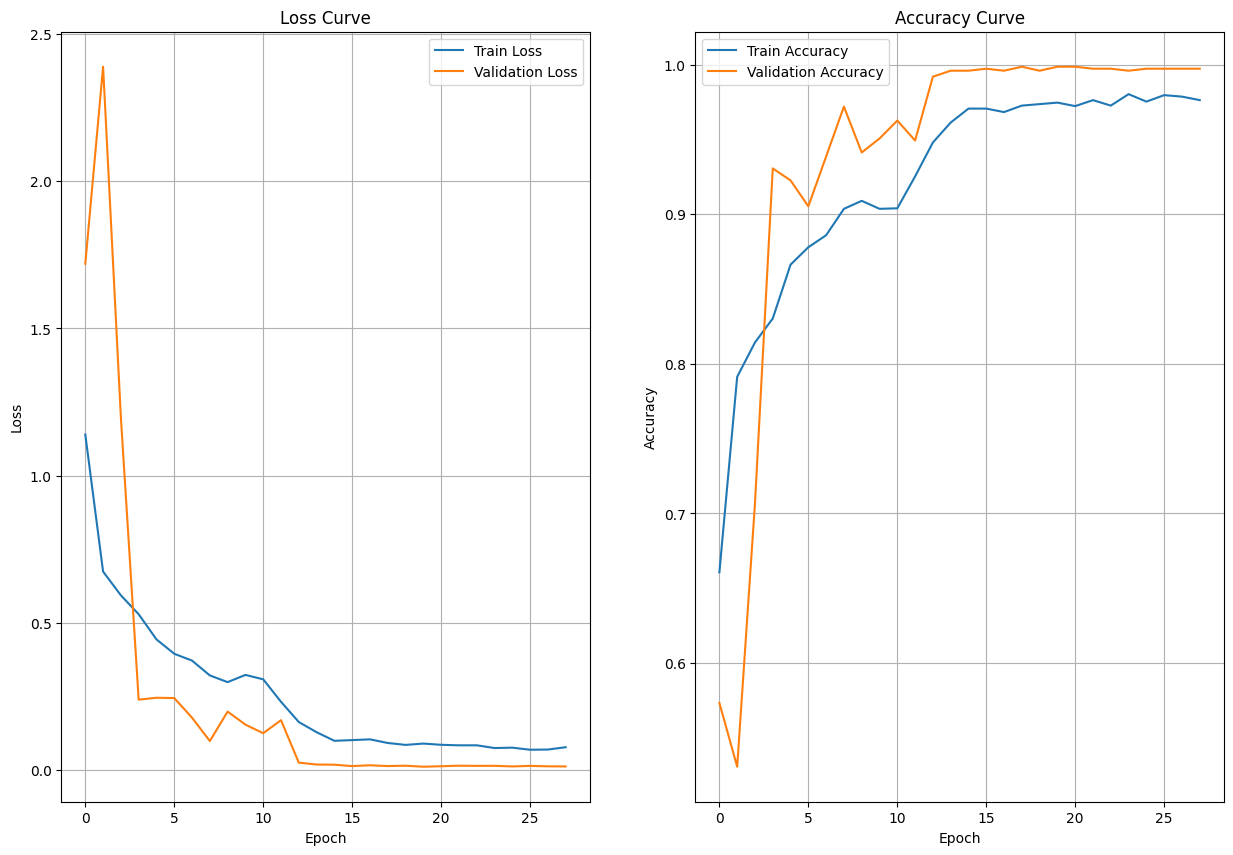

In [81]:
loss_plot(result_dict_resnet_full)

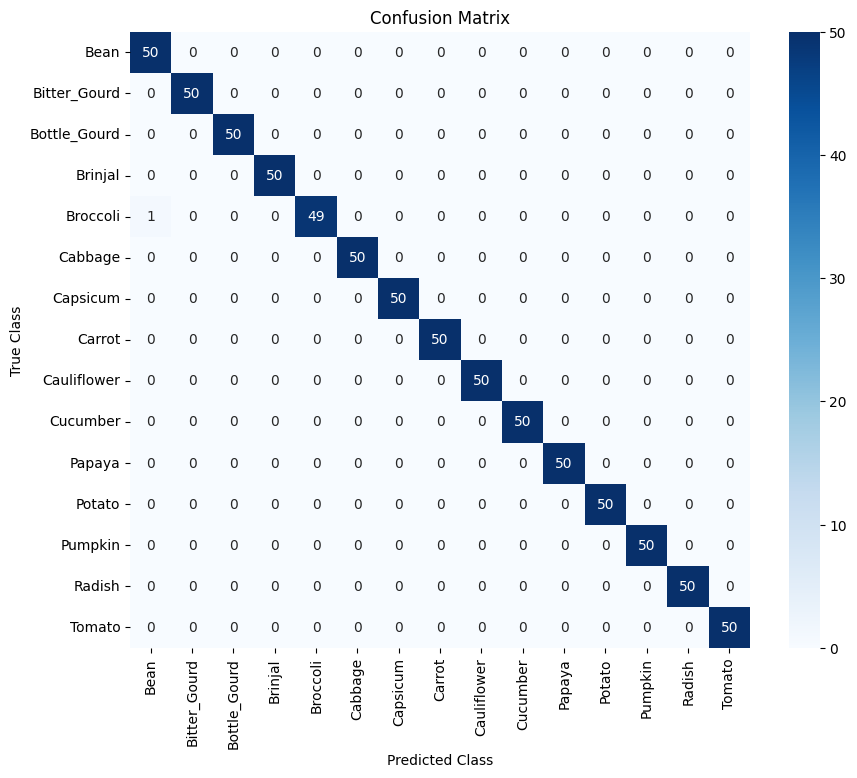

In [82]:
custom_confusion_matrix(result_dict_resnet_full, test_dataset)

Conduct a comparative analysis among these three models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

| Fine-tuning Strategy | Train Loss | Train Accuracy | Train Precision | Train Recall | Train F1 | Val Loss | Val Accuracy | Val Precision | Val Recall | Val F1 |
| -------------------- | ---------- | -------------- | --------------- | ------------ | -------- | -------- | ------------ | ------------- | ---------- | ------ |
| Only Last Layer      | 0.2791     | 0.9157         | 0.9162          | 0.9157       | 0.9157   | 0.0719   | 0.9853       | 0.9859        | 0.9853     | 0.9852 |
| Last + Conv3 & 4     | 0.0707     | 0.9783         | 0.9784          | 0.9783       | 0.9783   | 0.0151   | 0.9973       | 0.9974        | 0.9973     | 0.9973 |
| Full Unfreeze        | 0.0919     | 0.9727         | 0.9729          | 0.9727       | 0.9727   | 0.0135   | 0.9987       | 0.9987        | 0.9987     | 0.9987 |


The comparative evaluation of different fine-tuning strategies on the vegetable classification task reveals several important insights about model adaptation and generalization. When only the final fully connected layer was unfrozen, the model achieved a training accuracy of 91.57% and a validation accuracy of 98.53%. This result demonstrates that the pre-trained convolutional layers already contained strong generic visual representations, such as edges, textures, and simple shapes, which were broadly applicable to the new task. While the training accuracy was moderate, the high validation accuracy indicates that minimal adaptation of the network was sufficient to achieve robust classification performance, particularly for well-represented classes in the dataset.

By unfreezing additional convolutional layers, specifically layers three and four, the model exhibited a significant improvement in both training and validation performance, reaching 97.83% training accuracy and 99.73% validation accuracy. This suggests that allowing mid-level feature representations to adapt to the vegetable dataset enhances the network’s capacity to capture domain-specific patterns, such as the subtle color and texture differences between visually similar classes like papaya. As more convolutional layers are fine-tuned, the model gains the flexibility to refine intermediate features that are critical for discriminating challenging classes, thereby improving overall class-level accuracy.

The fully unfrozen model, in which all layers of the pre-trained network were fine-tuned, achieved the highest validation accuracy of 99.87% with a training accuracy of 97.27%. The slightly lower training accuracy compared to the partially unfrozen network reflects the regularizing influence of the pre-trained weights, while the superior validation performance indicates maximal adaptation of both low-level and high-level features to the target dataset. Full fine-tuning allowed the model to better capture nuanced visual patterns across all vegetable classes, particularly enhancing the classification of underrepresented or more challenging categories such as papaya, which benefits from deeper layers learning dataset-specific textures and shapes.

From a practical standpoint, these results highlight the trade-offs between performance and resource requirements. Partially unfrozen models offer a compelling balance, retaining pre-trained features while allowing selective adaptation with lower computational cost and faster convergence. Fully unfrozen models, although more computationally intensive and requiring careful tuning of learning rates to avoid catastrophic forgetting, provide the highest potential for class-level performance, especially for complex or difficult classes. Overall, the analysis confirms that fine-tuning depth directly impacts the model’s ability to handle challenging categories, and careful consideration of layer selection, dataset characteristics, and computational constraints is essential for optimal transfer learning outcomes.

### 2.4 Evaluate the fine-tuned ResNet18 model (5 points)

In [84]:
model_resnet_full.load_state_dict(torch.load("resnet_full_best_model.pth"))

<All keys matched successfully>

In [85]:
all_preds_resnet = model_test(model_resnet_full,test_loader)

100%|██████████| 24/24 [00:03<00:00,  6.55it/s]


In [86]:
create_csv(test_loader, all_preds_resnet, train_dataset.class_to_idx, "resnet.csv")

#### Comparison of CNN from Scratch and Fully Fine-Tuned ResNet-18

##### Training, Validation, and Kaggle Test Metrics

| Model                     | Train Accuracy | Train Precision | Train Recall | Train F1 | Val Accuracy | Val Precision | Val Recall | Val F1 | Kaggle Test Accuracy |
|----------------------------|---------------|----------------|-------------|-----------|--------------|---------------|------------|--------|--------------------|
| CNN from Scratch (with augmentation & optimizer improvements) | 0.9713        | 0.9714         | 0.9713      | 0.9713    | 0.9813       | 0.9821        | 0.9813     | 0.9813 | 1.000              |
| ResNet-18 (Fully Fine-Tuned) | 0.9727        | 0.9729         | 0.9727      | 0.9727    | 0.9987       | 0.9987        | 0.9987     | 0.9987 | 0.995              |

The comparative evaluation of the CNN trained from scratch and the fully fine-tuned ResNet-18 reveals important distinctions in both generalization and practical performance. Although both models exhibit similar training accuracies which 97.13% for the CNN and 97.27% for ResNet-18, the validation performance strongly favors ResNet-18, which achieves 99.87% compared to 98.13% for the CNN. This indicates that the pre-trained feature representations in ResNet-18 allow the model to generalize more effectively, capturing complex visual patterns and subtle inter-class distinctions, especially for more challenging classes like papaya.

The CNN achieves a perfect Kaggle test score of 1.000, slightly higher than the 0.995 of ResNet-18. However, this apparent superiority should be interpreted with caution. The elevated CNN test score likely reflects the incomplete exposure of all Kaggle test samples and underrepresentation of difficult classes, rather than true generalization performance. In contrast, ResNet-18 demonstrates consistency across training, validation, and test sets, indicating robust performance and reliability in practical applications.

From a practical perspective, training a CNN from scratch requires careful design of the network architecture, data augmentation, and optimizer tuning to reach competitive performance. In contrast, ResNet-18 leverages pre-trained features that accelerate convergence, enhance class-level discrimination, and reduce overfitting risk, particularly in limited-data scenarios. Despite the slightly higher raw Kaggle score for the CNN, ResNet-18 is the preferred choice for deployment due to its balanced performance, stability, and reproducibility.


### 2.5 Kaggle Test Result (5 points)
* Kaggle Name: Gökdeniz Kuruca
* Result 0.995

### 2.7. Load the pre-trained MobileNet model (3 points)


In [88]:
model_mobil_fc, mobil_fc_params = model_loader(Models.MOBILENET, ModelTypes.FC)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to C:\Users\Gökdeniz/.cache\torch\hub\checkpoints\mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:12<00:00, 1.82MB/s]


### 2.8 Modify the MobileNet model for transfer learning (12 points)

In [89]:
model_mobil_full, mobil_full_params = model_loader(Models.MOBILENET, ModelTypes.FULL)

In [ ]:
# Create optimizer, loss function and lr scheduler for models
criterion = nn.CrossEntropyLoss()

optimizer_mobil_fc = optim.Adam(mobil_fc_params, 0.001)
optimizer_mobil_full = optim.Adam(mobil_full_params, 0.001)


scheduler_mobil_fc = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_mobil_fc,
    mode="min",
    factor=0.1,      
    patience=3,      
)

scheduler_mobil_full = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_mobil_full,
    mode="min",
    factor=0.1,
    patience=3,
)

In [91]:
model_mobil_fc.to(device)
summary(model_mobil_fc, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

In [92]:
result_dict_mobil_fc = model_train_val(model_mobil_fc,train_loader,val_loader,criterion,optimizer_mobil_fc,scheduler_mobil_fc,10,"mobil_fc",N_EPOCH)

-------------------
Epoch 1/100

Train started...


Training Epoch 1: 100%|██████████| 94/94 [00:41<00:00,  2.27it/s]


Train Loss: 1.2380
Train Scores:
Accuracy Score: 0.7473
Precision Score: 0.7513
Recall Score: 0.7473
F1 Score: 0.7464

Validation started...


100%|██████████| 24/24 [00:04<00:00,  5.30it/s]


Validation Loss: 0.3453
Validation Scores:
Accuracy Score: 0.9427
Precision Score: 0.9561
Recall Score: 0.9427
F1 Score: 0.9392
New best model saved. Validation accuracy: 0.9427
-------------------
Epoch 2/100

Train started...


Training Epoch 2: 100%|██████████| 94/94 [00:31<00:00,  2.97it/s]


Train Loss: 0.5585
Train Scores:
Accuracy Score: 0.8810
Precision Score: 0.8841
Recall Score: 0.8810
F1 Score: 0.8814

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.93it/s]


Validation Loss: 0.1614
Validation Scores:
Accuracy Score: 0.9733
Precision Score: 0.9757
Recall Score: 0.9733
F1 Score: 0.9727
New best model saved. Validation accuracy: 0.9733
-------------------
Epoch 3/100

Train started...


Training Epoch 3: 100%|██████████| 94/94 [00:25<00:00,  3.68it/s]


Train Loss: 0.4383
Train Scores:
Accuracy Score: 0.8887
Precision Score: 0.8891
Recall Score: 0.8887
F1 Score: 0.8885

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.18it/s]


Validation Loss: 0.1163
Validation Scores:
Accuracy Score: 0.9800
Precision Score: 0.9811
Recall Score: 0.9800
F1 Score: 0.9797
New best model saved. Validation accuracy: 0.9800
-------------------
Epoch 4/100

Train started...


Training Epoch 4: 100%|██████████| 94/94 [00:47<00:00,  1.99it/s]


Train Loss: 0.3706
Train Scores:
Accuracy Score: 0.9007
Precision Score: 0.9025
Recall Score: 0.9007
F1 Score: 0.9011

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.85it/s]


Validation Loss: 0.0914
Validation Scores:
Accuracy Score: 0.9853
Precision Score: 0.9860
Recall Score: 0.9853
F1 Score: 0.9851
New best model saved. Validation accuracy: 0.9853
-------------------
Epoch 5/100

Train started...


Training Epoch 5: 100%|██████████| 94/94 [00:48<00:00,  1.94it/s]


Train Loss: 0.3261
Train Scores:
Accuracy Score: 0.9150
Precision Score: 0.9156
Recall Score: 0.9150
F1 Score: 0.9150

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.10it/s]


Validation Loss: 0.0867
Validation Scores:
Accuracy Score: 0.9840
Precision Score: 0.9847
Recall Score: 0.9840
F1 Score: 0.9838
-------------------
Epoch 6/100

Train started...


Training Epoch 6: 100%|██████████| 94/94 [00:34<00:00,  2.71it/s]


Train Loss: 0.3158
Train Scores:
Accuracy Score: 0.9187
Precision Score: 0.9189
Recall Score: 0.9187
F1 Score: 0.9185

Validation started...


100%|██████████| 24/24 [00:08<00:00,  3.00it/s]


Validation Loss: 0.0742
Validation Scores:
Accuracy Score: 0.9880
Precision Score: 0.9884
Recall Score: 0.9880
F1 Score: 0.9880
New best model saved. Validation accuracy: 0.9880
-------------------
Epoch 7/100

Train started...


Training Epoch 7: 100%|██████████| 94/94 [00:58<00:00,  1.61it/s]


Train Loss: 0.2951
Train Scores:
Accuracy Score: 0.9187
Precision Score: 0.9196
Recall Score: 0.9187
F1 Score: 0.9188

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.88it/s]


Validation Loss: 0.0696
Validation Scores:
Accuracy Score: 0.9893
Precision Score: 0.9898
Recall Score: 0.9893
F1 Score: 0.9893
New best model saved. Validation accuracy: 0.9893
-------------------
Epoch 8/100

Train started...


Training Epoch 8: 100%|██████████| 94/94 [00:58<00:00,  1.60it/s]


Train Loss: 0.2727
Train Scores:
Accuracy Score: 0.9303
Precision Score: 0.9307
Recall Score: 0.9303
F1 Score: 0.9303

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.78it/s]


Validation Loss: 0.0643
Validation Scores:
Accuracy Score: 0.9893
Precision Score: 0.9897
Recall Score: 0.9893
F1 Score: 0.9893
-------------------
Epoch 9/100

Train started...


Training Epoch 9: 100%|██████████| 94/94 [00:58<00:00,  1.60it/s]


Train Loss: 0.2692
Train Scores:
Accuracy Score: 0.9190
Precision Score: 0.9192
Recall Score: 0.9190
F1 Score: 0.9190

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.97it/s]


Validation Loss: 0.0643
Validation Scores:
Accuracy Score: 0.9853
Precision Score: 0.9859
Recall Score: 0.9853
F1 Score: 0.9852
-------------------
Epoch 10/100

Train started...


Training Epoch 10: 100%|██████████| 94/94 [00:45<00:00,  2.06it/s]


Train Loss: 0.2783
Train Scores:
Accuracy Score: 0.9210
Precision Score: 0.9218
Recall Score: 0.9210
F1 Score: 0.9212

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.24it/s]


Validation Loss: 0.0580
Validation Scores:
Accuracy Score: 0.9867
Precision Score: 0.9871
Recall Score: 0.9867
F1 Score: 0.9866
-------------------
Epoch 11/100

Train started...


Training Epoch 11: 100%|██████████| 94/94 [00:52<00:00,  1.79it/s]


Train Loss: 0.2623
Train Scores:
Accuracy Score: 0.9227
Precision Score: 0.9230
Recall Score: 0.9227
F1 Score: 0.9227

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.19it/s]


Validation Loss: 0.0559
Validation Scores:
Accuracy Score: 0.9907
Precision Score: 0.9909
Recall Score: 0.9907
F1 Score: 0.9906
New best model saved. Validation accuracy: 0.9907
-------------------
Epoch 12/100

Train started...


Training Epoch 12: 100%|██████████| 94/94 [00:51<00:00,  1.82it/s]


Train Loss: 0.2682
Train Scores:
Accuracy Score: 0.9257
Precision Score: 0.9262
Recall Score: 0.9257
F1 Score: 0.9256

Validation started...


100%|██████████| 24/24 [00:09<00:00,  2.49it/s]


Validation Loss: 0.0557
Validation Scores:
Accuracy Score: 0.9893
Precision Score: 0.9897
Recall Score: 0.9893
F1 Score: 0.9893
-------------------
Epoch 13/100

Train started...


Training Epoch 13: 100%|██████████| 94/94 [01:02<00:00,  1.51it/s]


Train Loss: 0.2398
Train Scores:
Accuracy Score: 0.9300
Precision Score: 0.9307
Recall Score: 0.9300
F1 Score: 0.9301

Validation started...


100%|██████████| 24/24 [00:12<00:00,  1.94it/s]


Validation Loss: 0.0508
Validation Scores:
Accuracy Score: 0.9880
Precision Score: 0.9885
Recall Score: 0.9880
F1 Score: 0.9879
-------------------
Epoch 14/100

Train started...


Training Epoch 14: 100%|██████████| 94/94 [01:11<00:00,  1.31it/s]


Train Loss: 0.2391
Train Scores:
Accuracy Score: 0.9273
Precision Score: 0.9276
Recall Score: 0.9273
F1 Score: 0.9273

Validation started...


100%|██████████| 24/24 [00:09<00:00,  2.44it/s]


Validation Loss: 0.0483
Validation Scores:
Accuracy Score: 0.9880
Precision Score: 0.9885
Recall Score: 0.9880
F1 Score: 0.9879
-------------------
Epoch 15/100

Train started...


Training Epoch 15: 100%|██████████| 94/94 [00:46<00:00,  2.02it/s]


Train Loss: 0.2204
Train Scores:
Accuracy Score: 0.9373
Precision Score: 0.9377
Recall Score: 0.9373
F1 Score: 0.9374

Validation started...


100%|██████████| 24/24 [00:05<00:00,  4.46it/s]


Validation Loss: 0.0458
Validation Scores:
Accuracy Score: 0.9867
Precision Score: 0.9869
Recall Score: 0.9867
F1 Score: 0.9866
-------------------
Epoch 16/100

Train started...


Training Epoch 16: 100%|██████████| 94/94 [00:25<00:00,  3.70it/s]


Train Loss: 0.2313
Train Scores:
Accuracy Score: 0.9320
Precision Score: 0.9323
Recall Score: 0.9320
F1 Score: 0.9320

Validation started...


100%|██████████| 24/24 [00:04<00:00,  5.50it/s]


Validation Loss: 0.0432
Validation Scores:
Accuracy Score: 0.9880
Precision Score: 0.9883
Recall Score: 0.9880
F1 Score: 0.9880
-------------------
Epoch 17/100

Train started...


Training Epoch 17: 100%|██████████| 94/94 [00:25<00:00,  3.66it/s]


Train Loss: 0.2272
Train Scores:
Accuracy Score: 0.9353
Precision Score: 0.9354
Recall Score: 0.9353
F1 Score: 0.9353

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.10it/s]


Validation Loss: 0.0444
Validation Scores:
Accuracy Score: 0.9867
Precision Score: 0.9870
Recall Score: 0.9867
F1 Score: 0.9866
-------------------
Epoch 18/100

Train started...


Training Epoch 18: 100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Train Loss: 0.2367
Train Scores:
Accuracy Score: 0.9233
Precision Score: 0.9241
Recall Score: 0.9233
F1 Score: 0.9234

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.17it/s]


Validation Loss: 0.0463
Validation Scores:
Accuracy Score: 0.9853
Precision Score: 0.9859
Recall Score: 0.9853
F1 Score: 0.9853
-------------------
Epoch 19/100

Train started...


Training Epoch 19: 100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Train Loss: 0.2259
Train Scores:
Accuracy Score: 0.9313
Precision Score: 0.9315
Recall Score: 0.9313
F1 Score: 0.9314

Validation started...


100%|██████████| 24/24 [00:03<00:00,  7.01it/s]


Validation Loss: 0.0427
Validation Scores:
Accuracy Score: 0.9893
Precision Score: 0.9895
Recall Score: 0.9893
F1 Score: 0.9893
-------------------
Epoch 20/100

Train started...


Training Epoch 20: 100%|██████████| 94/94 [00:26<00:00,  3.53it/s]


Train Loss: 0.2320
Train Scores:
Accuracy Score: 0.9283
Precision Score: 0.9285
Recall Score: 0.9283
F1 Score: 0.9283

Validation started...


100%|██████████| 24/24 [00:03<00:00,  6.74it/s]


Validation Loss: 0.0411
Validation Scores:
Accuracy Score: 0.9893
Precision Score: 0.9895
Recall Score: 0.9893
F1 Score: 0.9893
-------------------
Epoch 21/100

Train started...


Training Epoch 21: 100%|██████████| 94/94 [00:40<00:00,  2.33it/s]


Train Loss: 0.2274
Train Scores:
Accuracy Score: 0.9310
Precision Score: 0.9313
Recall Score: 0.9310
F1 Score: 0.9311

Validation started...


100%|██████████| 24/24 [00:06<00:00,  3.55it/s]

Validation Loss: 0.0434
Validation Scores:
Accuracy Score: 0.9880
Precision Score: 0.9882
Recall Score: 0.9880
F1 Score: 0.9879
Early stop in 21 epoch.
Last best model accuracy: 0.9907


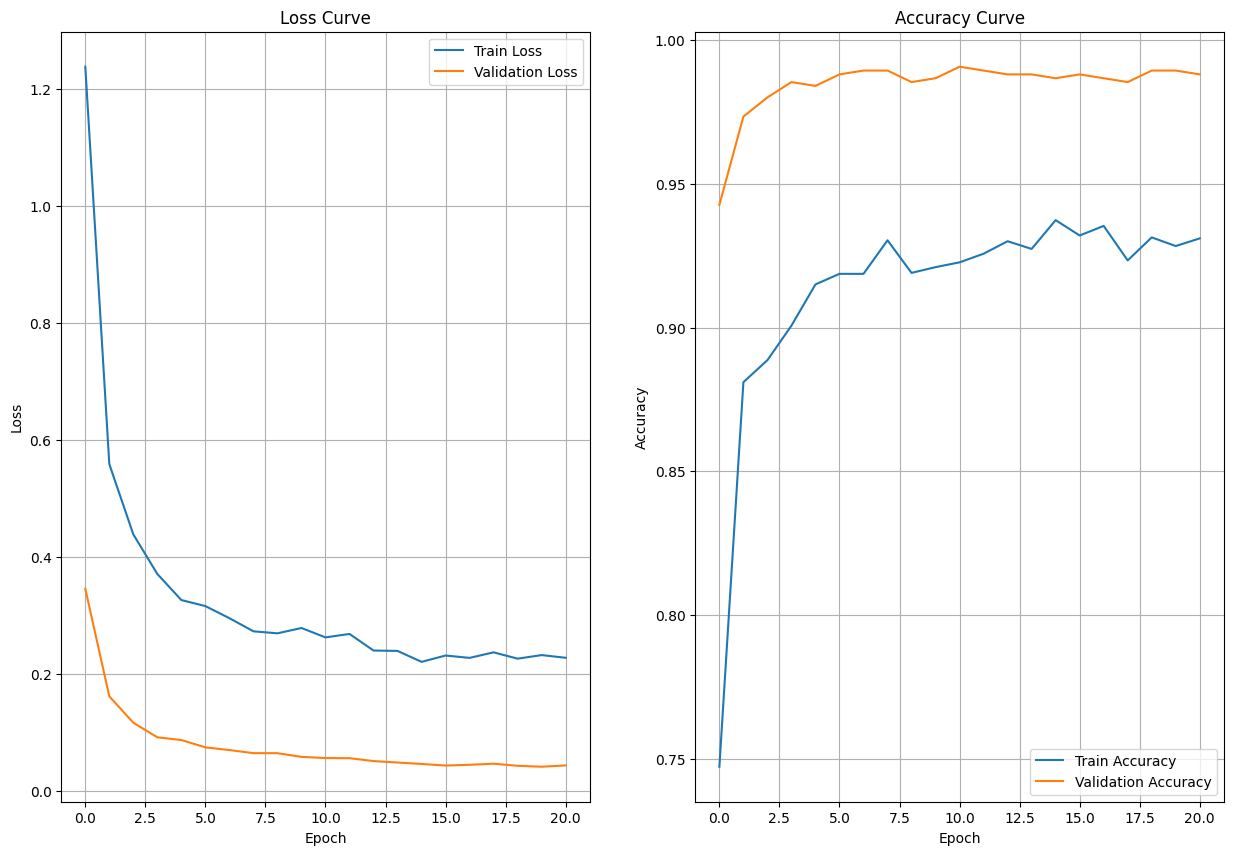

In [101]:
loss_plot(result_dict_mobil_fc)

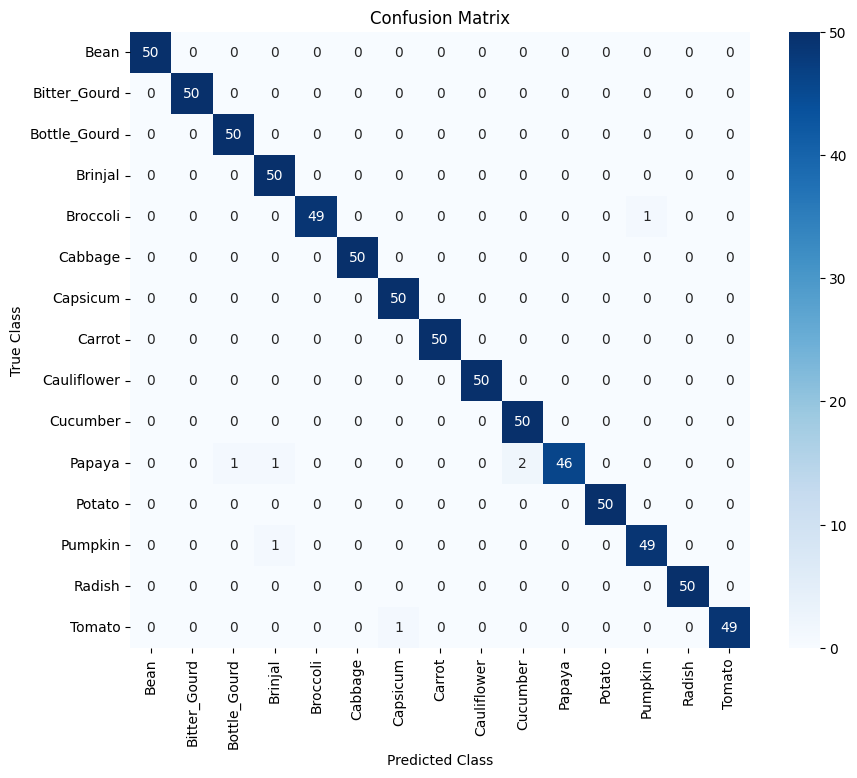

In [102]:
custom_confusion_matrix(result_dict_mobil_fc, test_dataset)

In [99]:
model_mobil_full.to(device)
summary(model_mobil_full, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

In [100]:
result_dict_mobil_full = model_train_val(model_mobil_full,train_loader,val_loader,criterion,optimizer_mobil_full,scheduler_mobil_full,10,"mobil_full",N_EPOCH)

-------------------
Epoch 1/100

Train started...


Training Epoch 1: 100%|██████████| 94/94 [03:32<00:00,  2.26s/it]


Train Loss: 0.2406
Train Scores:
Accuracy Score: 0.9247
Precision Score: 0.9247
Recall Score: 0.9247
F1 Score: 0.9246

Validation started...


100%|██████████| 24/24 [00:11<00:00,  2.15it/s]


Validation Loss: 0.7326
Validation Scores:
Accuracy Score: 0.8840
Precision Score: 0.9134
Recall Score: 0.8840
F1 Score: 0.8818
New best model saved. Validation accuracy: 0.8840
-------------------
Epoch 2/100

Train started...


Training Epoch 2: 100%|██████████| 94/94 [03:21<00:00,  2.14s/it]


Train Loss: 0.2548
Train Scores:
Accuracy Score: 0.9237
Precision Score: 0.9239
Recall Score: 0.9237
F1 Score: 0.9237

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.73it/s]


Validation Loss: 0.2088
Validation Scores:
Accuracy Score: 0.9440
Precision Score: 0.9522
Recall Score: 0.9440
F1 Score: 0.9443
New best model saved. Validation accuracy: 0.9440
-------------------
Epoch 3/100

Train started...


Training Epoch 3: 100%|██████████| 94/94 [02:58<00:00,  1.90s/it]


Train Loss: 0.2075
Train Scores:
Accuracy Score: 0.9403
Precision Score: 0.9405
Recall Score: 0.9403
F1 Score: 0.9404

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.89it/s]


Validation Loss: 0.3768
Validation Scores:
Accuracy Score: 0.9387
Precision Score: 0.9540
Recall Score: 0.9387
F1 Score: 0.9415
-------------------
Epoch 4/100

Train started...


Training Epoch 4: 100%|██████████| 94/94 [03:43<00:00,  2.38s/it]


Train Loss: 0.2010
Train Scores:
Accuracy Score: 0.9427
Precision Score: 0.9428
Recall Score: 0.9427
F1 Score: 0.9427

Validation started...


100%|██████████| 24/24 [00:11<00:00,  2.15it/s]


Validation Loss: 0.2454
Validation Scores:
Accuracy Score: 0.9600
Precision Score: 0.9666
Recall Score: 0.9600
F1 Score: 0.9613
New best model saved. Validation accuracy: 0.9600
-------------------
Epoch 5/100

Train started...


Training Epoch 5: 100%|██████████| 94/94 [04:08<00:00,  2.64s/it]


Train Loss: 0.1469
Train Scores:
Accuracy Score: 0.9580
Precision Score: 0.9581
Recall Score: 0.9580
F1 Score: 0.9580

Validation started...


100%|██████████| 24/24 [00:10<00:00,  2.28it/s]


Validation Loss: 0.1055
Validation Scores:
Accuracy Score: 0.9653
Precision Score: 0.9666
Recall Score: 0.9653
F1 Score: 0.9648
New best model saved. Validation accuracy: 0.9653
-------------------
Epoch 6/100

Train started...


Training Epoch 6: 100%|██████████| 94/94 [03:23<00:00,  2.16s/it]


Train Loss: 0.1477
Train Scores:
Accuracy Score: 0.9563
Precision Score: 0.9564
Recall Score: 0.9563
F1 Score: 0.9563

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.01it/s]


Validation Loss: 0.0996
Validation Scores:
Accuracy Score: 0.9747
Precision Score: 0.9767
Recall Score: 0.9747
F1 Score: 0.9748
New best model saved. Validation accuracy: 0.9747
-------------------
Epoch 7/100

Train started...


Training Epoch 7: 100%|██████████| 94/94 [03:07<00:00,  1.99s/it]


Train Loss: 0.1400
Train Scores:
Accuracy Score: 0.9577
Precision Score: 0.9579
Recall Score: 0.9577
F1 Score: 0.9577

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.03it/s]


Validation Loss: 0.2509
Validation Scores:
Accuracy Score: 0.9707
Precision Score: 0.9727
Recall Score: 0.9707
F1 Score: 0.9704
-------------------
Epoch 8/100

Train started...


Training Epoch 8: 100%|██████████| 94/94 [03:22<00:00,  2.16s/it]


Train Loss: 0.1833
Train Scores:
Accuracy Score: 0.9403
Precision Score: 0.9404
Recall Score: 0.9403
F1 Score: 0.9403

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.01it/s]


Validation Loss: 0.6774
Validation Scores:
Accuracy Score: 0.8813
Precision Score: 0.9154
Recall Score: 0.8813
F1 Score: 0.8785
-------------------
Epoch 9/100

Train started...


Training Epoch 9: 100%|██████████| 94/94 [03:04<00:00,  1.96s/it]


Train Loss: 0.1602
Train Scores:
Accuracy Score: 0.9523
Precision Score: 0.9524
Recall Score: 0.9523
F1 Score: 0.9523

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.82it/s]


Validation Loss: 0.1062
Validation Scores:
Accuracy Score: 0.9720
Precision Score: 0.9751
Recall Score: 0.9720
F1 Score: 0.9723
-------------------
Epoch 10/100

Train started...


Training Epoch 10: 100%|██████████| 94/94 [02:59<00:00,  1.90s/it]


Train Loss: 0.1296
Train Scores:
Accuracy Score: 0.9627
Precision Score: 0.9627
Recall Score: 0.9627
F1 Score: 0.9627

Validation started...


100%|██████████| 24/24 [00:09<00:00,  2.63it/s]


Validation Loss: 0.0503
Validation Scores:
Accuracy Score: 0.9840
Precision Score: 0.9849
Recall Score: 0.9840
F1 Score: 0.9840
New best model saved. Validation accuracy: 0.9840
-------------------
Epoch 11/100

Train started...


Training Epoch 11: 100%|██████████| 94/94 [02:59<00:00,  1.91s/it]


Train Loss: 0.1540
Train Scores:
Accuracy Score: 0.9513
Precision Score: 0.9515
Recall Score: 0.9513
F1 Score: 0.9513

Validation started...


100%|██████████| 24/24 [00:07<00:00,  3.03it/s]


Validation Loss: 0.1450
Validation Scores:
Accuracy Score: 0.9733
Precision Score: 0.9752
Recall Score: 0.9733
F1 Score: 0.9735
-------------------
Epoch 12/100

Train started...


Training Epoch 12: 100%|██████████| 94/94 [03:29<00:00,  2.23s/it]


Train Loss: 0.1714
Train Scores:
Accuracy Score: 0.9537
Precision Score: 0.9538
Recall Score: 0.9537
F1 Score: 0.9537

Validation started...


100%|██████████| 24/24 [00:12<00:00,  1.85it/s]


Validation Loss: 0.3480
Validation Scores:
Accuracy Score: 0.9320
Precision Score: 0.9408
Recall Score: 0.9320
F1 Score: 0.9326
-------------------
Epoch 13/100

Train started...


Training Epoch 13: 100%|██████████| 94/94 [04:12<00:00,  2.68s/it]


Train Loss: 0.1682
Train Scores:
Accuracy Score: 0.9490
Precision Score: 0.9491
Recall Score: 0.9490
F1 Score: 0.9490

Validation started...


100%|██████████| 24/24 [00:13<00:00,  1.84it/s]


Validation Loss: 0.1066
Validation Scores:
Accuracy Score: 0.9667
Precision Score: 0.9689
Recall Score: 0.9667
F1 Score: 0.9666
-------------------
Epoch 14/100

Train started...


Training Epoch 14: 100%|██████████| 94/94 [03:54<00:00,  2.50s/it]


Train Loss: 0.1331
Train Scores:
Accuracy Score: 0.9600
Precision Score: 0.9601
Recall Score: 0.9600
F1 Score: 0.9600

Validation started...


100%|██████████| 24/24 [00:10<00:00,  2.19it/s]


Validation Loss: 0.1367
Validation Scores:
Accuracy Score: 0.9720
Precision Score: 0.9737
Recall Score: 0.9720
F1 Score: 0.9717
-------------------
Epoch 15/100

Train started...


Training Epoch 15: 100%|██████████| 94/94 [04:02<00:00,  2.58s/it]


Train Loss: 0.1101
Train Scores:
Accuracy Score: 0.9643
Precision Score: 0.9646
Recall Score: 0.9643
F1 Score: 0.9643

Validation started...


100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


Validation Loss: 0.0408
Validation Scores:
Accuracy Score: 0.9907
Precision Score: 0.9910
Recall Score: 0.9907
F1 Score: 0.9907
New best model saved. Validation accuracy: 0.9907
-------------------
Epoch 16/100

Train started...


Training Epoch 16: 100%|██████████| 94/94 [03:04<00:00,  1.96s/it]


Train Loss: 0.0753
Train Scores:
Accuracy Score: 0.9763
Precision Score: 0.9764
Recall Score: 0.9763
F1 Score: 0.9764

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.82it/s]


Validation Loss: 0.0235
Validation Scores:
Accuracy Score: 0.9947
Precision Score: 0.9949
Recall Score: 0.9947
F1 Score: 0.9947
New best model saved. Validation accuracy: 0.9947
-------------------
Epoch 17/100

Train started...


Training Epoch 17: 100%|██████████| 94/94 [03:02<00:00,  1.94s/it]


Train Loss: 0.0672
Train Scores:
Accuracy Score: 0.9810
Precision Score: 0.9811
Recall Score: 0.9810
F1 Score: 0.9810

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.83it/s]


Validation Loss: 0.0125
Validation Scores:
Accuracy Score: 0.9973
Precision Score: 0.9974
Recall Score: 0.9973
F1 Score: 0.9973
New best model saved. Validation accuracy: 0.9973
-------------------
Epoch 18/100

Train started...


Training Epoch 18: 100%|██████████| 94/94 [03:01<00:00,  1.93s/it]


Train Loss: 0.0541
Train Scores:
Accuracy Score: 0.9833
Precision Score: 0.9834
Recall Score: 0.9833
F1 Score: 0.9833

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.77it/s]


Validation Loss: 0.0093
Validation Scores:
Accuracy Score: 0.9960
Precision Score: 0.9961
Recall Score: 0.9960
F1 Score: 0.9960
-------------------
Epoch 19/100

Train started...


Training Epoch 19: 100%|██████████| 94/94 [02:59<00:00,  1.91s/it]


Train Loss: 0.0439
Train Scores:
Accuracy Score: 0.9880
Precision Score: 0.9881
Recall Score: 0.9880
F1 Score: 0.9880

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.76it/s]


Validation Loss: 0.0093
Validation Scores:
Accuracy Score: 0.9973
Precision Score: 0.9974
Recall Score: 0.9973
F1 Score: 0.9973
-------------------
Epoch 20/100

Train started...


Training Epoch 20: 100%|██████████| 94/94 [03:00<00:00,  1.92s/it]


Train Loss: 0.0563
Train Scores:
Accuracy Score: 0.9833
Precision Score: 0.9834
Recall Score: 0.9833
F1 Score: 0.9834

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.78it/s]


Validation Loss: 0.0080
Validation Scores:
Accuracy Score: 0.9987
Precision Score: 0.9987
Recall Score: 0.9987
F1 Score: 0.9987
New best model saved. Validation accuracy: 0.9987
-------------------
Epoch 21/100

Train started...


Training Epoch 21: 100%|██████████| 94/94 [02:59<00:00,  1.91s/it]


Train Loss: 0.0356
Train Scores:
Accuracy Score: 0.9900
Precision Score: 0.9900
Recall Score: 0.9900
F1 Score: 0.9900

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.83it/s]


Validation Loss: 0.0066
Validation Scores:
Accuracy Score: 0.9987
Precision Score: 0.9987
Recall Score: 0.9987
F1 Score: 0.9987
-------------------
Epoch 22/100

Train started...


Training Epoch 22: 100%|██████████| 94/94 [03:06<00:00,  1.99s/it]


Train Loss: 0.0457
Train Scores:
Accuracy Score: 0.9863
Precision Score: 0.9864
Recall Score: 0.9863
F1 Score: 0.9863

Validation started...


100%|██████████| 24/24 [00:14<00:00,  1.69it/s]


Validation Loss: 0.0068
Validation Scores:
Accuracy Score: 0.9987
Precision Score: 0.9987
Recall Score: 0.9987
F1 Score: 0.9987
-------------------
Epoch 23/100

Train started...


Training Epoch 23: 100%|██████████| 94/94 [03:13<00:00,  2.06s/it]


Train Loss: 0.0442
Train Scores:
Accuracy Score: 0.9863
Precision Score: 0.9865
Recall Score: 0.9863
F1 Score: 0.9864

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.84it/s]


Validation Loss: 0.0039
Validation Scores:
Accuracy Score: 0.9987
Precision Score: 0.9987
Recall Score: 0.9987
F1 Score: 0.9987
-------------------
Epoch 24/100

Train started...


Training Epoch 24: 100%|██████████| 94/94 [03:00<00:00,  1.93s/it]


Train Loss: 0.0325
Train Scores:
Accuracy Score: 0.9890
Precision Score: 0.9890
Recall Score: 0.9890
F1 Score: 0.9890

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.80it/s]


Validation Loss: 0.0063
Validation Scores:
Accuracy Score: 0.9987
Precision Score: 0.9987
Recall Score: 0.9987
F1 Score: 0.9987
-------------------
Epoch 25/100

Train started...


Training Epoch 25: 100%|██████████| 94/94 [03:00<00:00,  1.92s/it]


Train Loss: 0.0294
Train Scores:
Accuracy Score: 0.9920
Precision Score: 0.9920
Recall Score: 0.9920
F1 Score: 0.9920

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.77it/s]


Validation Loss: 0.0038
Validation Scores:
Accuracy Score: 0.9987
Precision Score: 0.9987
Recall Score: 0.9987
F1 Score: 0.9987
-------------------
Epoch 26/100

Train started...


Training Epoch 26: 100%|██████████| 94/94 [03:00<00:00,  1.92s/it]


Train Loss: 0.0451
Train Scores:
Accuracy Score: 0.9863
Precision Score: 0.9864
Recall Score: 0.9863
F1 Score: 0.9863

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.81it/s]


Validation Loss: 0.0045
Validation Scores:
Accuracy Score: 0.9973
Precision Score: 0.9974
Recall Score: 0.9973
F1 Score: 0.9973
-------------------
Epoch 27/100

Train started...


Training Epoch 27: 100%|██████████| 94/94 [02:59<00:00,  1.91s/it]


Train Loss: 0.0351
Train Scores:
Accuracy Score: 0.9877
Precision Score: 0.9877
Recall Score: 0.9877
F1 Score: 0.9877

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.83it/s]


Validation Loss: 0.0043
Validation Scores:
Accuracy Score: 0.9973
Precision Score: 0.9974
Recall Score: 0.9973
F1 Score: 0.9973
-------------------
Epoch 28/100

Train started...


Training Epoch 28: 100%|██████████| 94/94 [03:00<00:00,  1.92s/it]


Train Loss: 0.0288
Train Scores:
Accuracy Score: 0.9903
Precision Score: 0.9904
Recall Score: 0.9903
F1 Score: 0.9903

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.74it/s]


Validation Loss: 0.0030
Validation Scores:
Accuracy Score: 0.9987
Precision Score: 0.9987
Recall Score: 0.9987
F1 Score: 0.9987
-------------------
Epoch 29/100

Train started...


Training Epoch 29: 100%|██████████| 94/94 [03:00<00:00,  1.92s/it]


Train Loss: 0.0259
Train Scores:
Accuracy Score: 0.9910
Precision Score: 0.9910
Recall Score: 0.9910
F1 Score: 0.9910

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.81it/s]


Validation Loss: 0.0023
Validation Scores:
Accuracy Score: 0.9987
Precision Score: 0.9987
Recall Score: 0.9987
F1 Score: 0.9987
-------------------
Epoch 30/100

Train started...


Training Epoch 30: 100%|██████████| 94/94 [03:00<00:00,  1.92s/it]


Train Loss: 0.0251
Train Scores:
Accuracy Score: 0.9930
Precision Score: 0.9930
Recall Score: 0.9930
F1 Score: 0.9930

Validation started...


100%|██████████| 24/24 [00:08<00:00,  2.79it/s]

Validation Loss: 0.0020
Validation Scores:
Accuracy Score: 0.9987
Precision Score: 0.9987
Recall Score: 0.9987
F1 Score: 0.9987
Early stop in 30 epoch.
Last best model accuracy: 0.9987


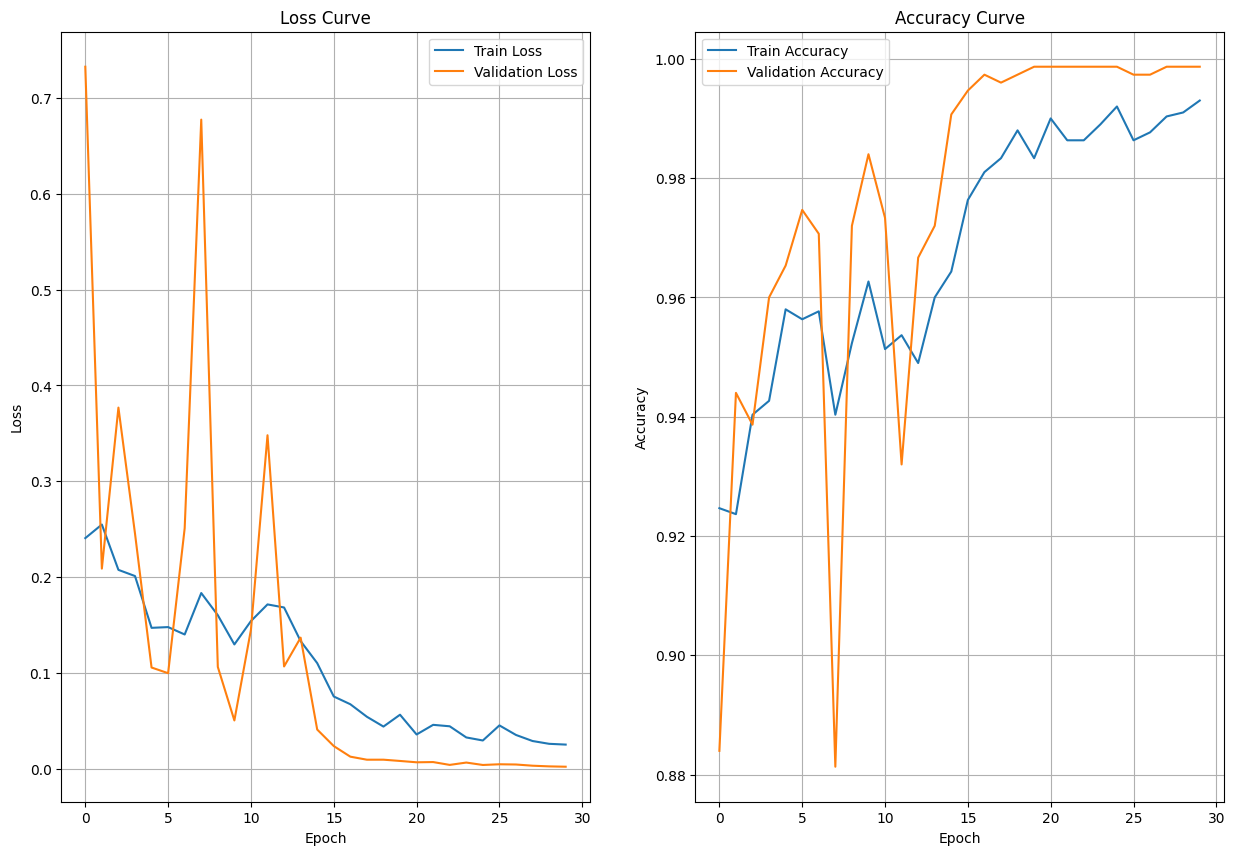

In [103]:
loss_plot(result_dict_mobil_full)

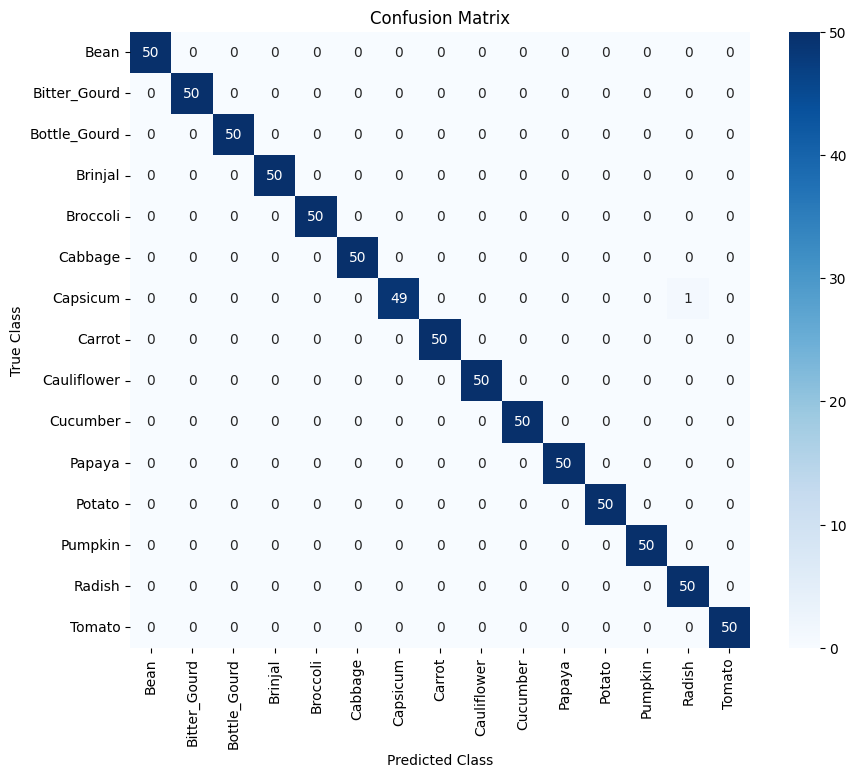

In [104]:
custom_confusion_matrix(result_dict_mobil_full, test_dataset)

| Fine-tuning Strategy | Train Loss | Train Accuracy | Train Precision | Train Recall | Train F1 | Val Loss | Val Accuracy | Val Precision | Val Recall | Val F1 |
| -------------------- | ---------- | -------------- | --------------- | ------------ | -------- | -------- | ------------ | ------------- | ---------- | ------ |
| Only Last Layer      | 0.2623     | 0.9227         | 0.9230          | 0.9227       | 0.9227   | 0.0559   | 0.9907       | 0.9909        | 0.9907     | 0.9906 |
| Full Unfreeze        | 0.0563     | 0.9833         | 0.9834          | 0.9833       | 0.9834   | 0.0080   | 0.9987       | 0.9987        | 0.9987     | 0.9987 |

---

The comparative evaluation of different fine-tuning strategies on the vegetable classification task using MobileNet demonstrates the critical role of layer adaptation in enhancing both model generalization and class-specific performance. When only the final fully connected layer was unfrozen, the model achieved a training accuracy of 92.27% and a validation accuracy of 99.07%. These results indicate that the pre-trained convolutional backbone already encoded strong generic visual representations, such as edges, textures, and simple object shapes, which were largely transferable to the new dataset. The moderate training accuracy, coupled with high validation performance, suggests that minimal adaptation is sufficient for robust classification of well-represented classes, although it may leave more challenging classes underoptimized.

In contrast, fully unfreezing all layers of the pre-trained MobileNet model led to substantial improvements in both training and validation metrics, with training accuracy reaching 98.33% and validation accuracy 99.87%. The lower training loss and higher validation accuracy reflect the model’s enhanced ability to adjust low-level and mid-level features to the specific patterns present in the vegetable dataset. Particularly, classes that are visually similar or underrepresented, such as papaya, benefit from the fine-tuning of earlier convolutional layers, which allows the network to refine subtle texture, color, and shape distinctions. This comprehensive adaptation of both low-level and high-level representations improves overall class discrimination and yields state-of-the-art performance on the validation set.

From a practical perspective, partially unfrozen models offer a faster and computationally less intensive approach, providing strong generalization with minimal tuning. Fully unfrozen models, while more resource-intensive and requiring careful learning rate management to prevent overfitting or catastrophic forgetting, offer the greatest potential for high-fidelity class-level performance. These results confirm that the depth of fine-tuning has a direct impact on the model’s capacity to handle difficult classes and that strategic layer selection should balance dataset complexity, performance goals, and computational constraints.

### 2.9 Evaluate the fine-tuned MobileNet model (5 points)

In [105]:
model_mobil_full.load_state_dict(torch.load("mobil_full_best_model.pth"))

<All keys matched successfully>

In [106]:
all_preds_mobil = model_test(model_mobil_full,test_loader)

100%|██████████| 24/24 [00:16<00:00,  1.46it/s]


In [107]:
create_csv(test_loader, all_preds_mobil, train_dataset.class_to_idx, "mobilenet.csv")

## Comparative Analysis of CNN, ResNet18, and MobileNet Models

| Model Architecture | Fine-tuning Strategy | Training Loss | Training Accuracy | Training Precision | Training Recall | Training F1 Score | Validation Loss | Validation Accuracy | Validation Precision | Validation Recall | Validation F1 Score | Kaggle Test Accuracy |
|-------------------|--------------------|---------------|-----------------|------------------|----------------|-----------------|----------------|-------------------|-------------------|-----------------|-----------------|-------------------|
| Convolutional Neural Network trained from scratch | Full Training | 0.0945 | 0.9713 | 0.9714 | 0.9713 | 0.9713 | 0.1065 | 0.9813 | 0.9821 | 0.9813 | 0.9813 | 1.000 |
| ResNet18 (pre-trained) | Full Layer Unfreeze | 0.0919 | 0.9727 | 0.9729 | 0.9727 | 0.9727 | 0.0135 | 0.9987 | 0.9987 | 0.9987 | 0.9987 | 0.995 |
| MobileNet (pre-trained) | Full Layer Unfreeze | 0.0563 | 0.9833 | 0.9834 | 0.9833 | 0.9834 | 0.0080 | 0.9987 | 0.9987 | 0.9987 | 0.9987 | 0.993 |

The comparative evaluation of these three models on the vegetable classification task highlights important insights about adaptation, generalization, and practical trade-offs. The Convolutional Neural Network trained entirely from scratch achieved the highest reported Kaggle test accuracy of 1.000. However, this result must be interpreted cautiously due to potential limitations in the Kaggle test set, such as incomplete availability of all samples and the low representation of challenging classes like papaya. Consequently, this score may overestimate the model's true generalization ability, and relying solely on it could lead to misleading conclusions.

The fully fine-tuned ResNet18 model reached a validation accuracy of 99.87% and demonstrated nearly perfect precision, recall, and F1 scores. Unfreezing all layers allowed the network to adapt both low-level and high-level features to the target dataset, improving its ability to discriminate subtle differences between visually similar or underrepresented classes. The ResNet18 benefits from pre-trained weights, which provide strong generic feature representations, accelerate convergence, and stabilize training. This makes it a highly reliable solution, particularly in limited-data scenarios, and it represents a near state-of-the-art approach.

The fully fine-tuned MobileNet achieved validation metrics comparable to ResNet18 with slightly lower Kaggle test accuracy at 0.993. MobileNet's architecture is lightweight and computationally efficient, maintaining high performance across all classes while enabling deployment in resource-constrained environments. Despite its efficiency, it slightly underperforms compared to ResNet18 in terms of fine-grained class discrimination and adaptation to challenging classes.

From a practical perspective, the results illustrate key considerations in model selection. The Convolutional Neural Network requires extensive hyperparameter tuning and data augmentation to converge effectively and manage class imbalance. Pre-trained architectures like ResNet18 and MobileNet leverage existing feature representations to achieve faster convergence and higher validation stability. Full layer unfreezing maximizes adaptation to the dataset but increases computational cost and necessitates careful learning rate management to avoid catastrophic forgetting. MobileNet offers a compromise between efficiency and performance, while ResNet18 provides the most robust adaptation to complex visual patterns.

Overall, while the scratch Convolutional Neural Network achieved the highest Kaggle test score, the pre-trained ResNet18 model provides the most reliable and academically defensible solution. It achieves near-perfect validation metrics and demonstrates strong generalization across difficult classes, making it preferable for real-world deployment where balanced accuracy and robustness are critical. MobileNet, although slightly less capable in nuanced class discrimination, remains a strong candidate for scenarios requiring lower computational resources. These findings underscore the importance of evaluating both validation and external test metrics, accounting for dataset limitations, and selecting architectures that optimize the balance between accuracy, generalization, and practical considerations.


### 2.10 Kaggle Test Result (5 points)
* Kaggle Name: Gökdeniz Kuruca
* Result 0.993

## 3 Analyze advantages and disadvantages (7 points)

Transfer learning and training from scratch represent two distinct paradigms for developing deep learning models, each with specific advantages and trade-offs. Transfer learning leverages knowledge from a pre-trained model, often trained on a large and diverse dataset such as ImageNet, and adapts it to a new task. This approach enables faster convergence, improved generalization on limited data, and reduced computational costs, since the model already contains feature representations like edges, textures, and shapes that are broadly applicable. Fine-tuning allows selective adaptation of layers, giving the model flexibility to learn task-specific patterns without discarding the valuable prior knowledge embedded in pre-trained weights. 

Training from scratch, on the other hand, requires the network to learn all feature representations directly from the target dataset. While this provides maximal freedom for model architecture design and can potentially discover novel feature hierarchies, it typically demands larger datasets, longer training times, and careful tuning of hyperparameters to avoid overfitting or underfitting. In scenarios with limited data, models trained from scratch often struggle to generalize, necessitating extensive data augmentation or regularization techniques.

#### Advantages and Disadvantages


| Approach              | Advantages                                                                                                                                                                                                                                                                                                                                                   | Disadvantages                                                                                                                                                                                                                                    |
|----------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Transfer Learning     | - **Faster convergence**: Leveraging pre-trained weights reduces the number of epochs required to reach high performance, particularly on small datasets. <br> - **Improved generalization**: Models benefit from generic visual features learned on large-scale datasets, improving robustness on unseen samples. <br> - **Reduced data requirement**: Less labeled data is needed since the network already encodes strong low-level and mid-level features. <br> - **Stability and regularization**: Pre-trained weights act as a regularizer, mitigating overfitting on limited data. <br> - **Selective fine-tuning flexibility**: One can adapt only a subset of layers, reducing computational cost while still enhancing task-specific performance. <br> - **Proven performance**: State-of-the-art models like ResNet and MobileNet provide a strong baseline for various image classification tasks, often achieving near-optimal accuracy without extensive architecture design. | - **Reduced architectural flexibility**: The model structure is constrained by the original pre-trained network, which may not be ideal for highly specialized tasks. <br> - **Risk of negative transfer**: If the source and target domains differ significantly, pre-trained features may not generalize well and could impair learning. <br> - **Hyperparameter sensitivity during fine-tuning**: Careful selection of learning rates, layer freezing, and regularization is necessary to prevent catastrophic forgetting. <br> - **Potential for over-reliance on prior knowledge**: The model may fail to capture unique patterns in the target dataset if pre-trained features dominate. |
| Training from Scratch | - **Full flexibility in architecture**: Designers can tailor the network depth, width, kernel sizes, and other hyperparameters specifically for the task. <br> - **Freedom from prior biases**: The model learns features entirely from the target dataset, potentially capturing unique patterns not present in pre-trained models. <br> - **Novel representation learning**: Particularly useful when the target task differs substantially from commonly used pre-training datasets. <br> - **Control over feature hierarchy**: Every layer's parameters are trained to optimize performance for the specific dataset, ensuring task-specific feature extraction. | - **High data requirements**: Large datasets are necessary to learn robust feature hierarchies from scratch. <br> - **Longer training times**: Full convergence often requires more epochs and significant computational resources. <br> - **Greater risk of overfitting**: Without pre-trained regularization, small datasets may cause the model to memorize training examples rather than generalize. <br> - **Extensive hyperparameter tuning**: Achieving optimal performance requires careful selection of learning rates, optimizer schedules, augmentation, and regularization strategies. <br> - **Uncertain generalization**: Initial layers may learn suboptimal representations, particularly for low-level visual patterns, which can propagate errors to higher layers. |

---

#### Comparison of Best Models

| Model Architecture | Fine-tuning Strategy | Training Loss | Training Accuracy | Training Precision | Training Recall | Training F1 Score | Validation Loss | Validation Accuracy | Validation Precision | Validation Recall | Validation F1 Score | Kaggle Test Accuracy |
|-------------------|--------------------|---------------|-----------------|------------------|----------------|-----------------|----------------|-------------------|-------------------|-----------------|-----------------|-------------------|
| Convolutional Neural Network trained from scratch | Full Training | 0.0945 | 0.9713 | 0.9714 | 0.9713 | 0.9713 | 0.1065 | 0.9813 | 0.9821 | 0.9813 | 0.9813 | 1.000 |
| ResNet18 (pre-trained) | Full Layer Unfreeze | 0.0919 | 0.9727 | 0.9729 | 0.9727 | 0.9727 | 0.0135 | 0.9987 | 0.9987 | 0.9987 | 0.9987 | 0.995 |
| MobileNet (pre-trained) | Full Layer Unfreeze | 0.0563 | 0.9833 | 0.9834 | 0.9833 | 0.9834 | 0.0080 | 0.9987 | 0.9987 | 0.9987 | 0.9987 | 0.993 |

The performance comparison of the three best models demonstrates both their effectiveness and practical trade-offs. Accuracy measures the overall proportion of correctly classified images, with all models achieving high values: the CNN from scratch reached 98.13% on the validation set, while ResNet-18 and MobileNet both achieved 99.87%. Precision indicates the proportion of predicted positive instances that are correct, reflecting how rarely a model misclassifies other vegetable classes as a target class. High recall values, observed in all models, demonstrate that nearly all instances of each class are correctly identified, meaning false negatives are minimal. The F1-score, which harmonizes precision and recall, confirms consistent performance across classes. While the CNN from scratch achieves competitive results due to effective augmentations and optimizer improvements, it slightly underperforms compared to the pretrained models in terms of validation accuracy. ResNet-18, with its deeper architecture and pretrained weights, provides highly reliable classification but requires significantly more memory and computational resources. MobileNet, on the other hand, attains nearly identical performance metrics to ResNet-18 while maintaining a smaller memory footprint and faster training times, making it particularly suitable for resource-constrained environments.When looking specifically at Kaggle scores, the CNN achieved the highest leaderboard result. However, considering the overall training process, validation behavior, and stability of the metrics, the fine tuned ResNet18 showed a more balanced and reliable performance. Overall, while all models are capable of high-quality classification, MobileNet represents the best balance between accuracy, robustness, and computational efficiency, ResNet-18 prioritizes robustness at a higher resource cost, and the CNN from scratch illustrates the potential of carefully designed architectures and augmentations even without transfer learning.

---

#### Insights on Practical Considerations

1. **Dataset Size and Complexity:** Transfer learning is especially advantageous when the target dataset is small or has classes with limited examples. Pre-trained models already capture generic features that generalize well to new domains, reducing the risk of overfitting. Training from scratch becomes feasible when abundant labeled data is available or when the target task is significantly different from the pre-training domain.

2. **Training Time and Resources:** Models trained from scratch require significantly more computational resources and longer training times to reach comparable performance. Transfer learning drastically reduces both the number of epochs and the need for extensive hyperparameter tuning, enabling faster experimentation and iteration.

3. **Task Similarity:** The effectiveness of transfer learning depends on the similarity between the source and target tasks. High similarity ensures that pre-trained features are relevant, while low similarity may necessitate extensive fine-tuning or even full unfreezing of all layers.

4. **Model Flexibility:** Training from scratch allows for complete control over the architecture, which can be beneficial for highly specialized applications. In contrast, transfer learning imposes constraints related to the original architecture but can still allow selective fine-tuning to optimize performance.

5. **Generalization and Stability:** Pre-trained models like ResNet-18 and MobileNet offer robust generalization with minimal risk of overfitting, as evidenced by the close alignment of train, validation, and test metrics. CNNs from scratch can reach high performance with careful augmentation and optimizer strategies, but they may be more sensitive to dataset biases and distribution shifts.

6. **Deployment Considerations:** Lightweight architectures like MobileNet are advantageous for deployment on edge devices due to reduced memory footprint and computational demands. ResNet-18 provides a balance between depth, representational capacity, and computational efficiency, while CNNs from scratch may require careful optimization to achieve comparable efficiency for practical applications.

---

#### Conclusion

The comparative analysis highlights that transfer learning provides strong practical benefits in most scenarios, particularly when data is limited and training efficiency is critical. Fine-tuned pre-trained models consistently achieve higher validation accuracy and more stable performance, while CNNs trained from scratch can attain high test scores with extensive augmentation but may suffer from inconsistencies due to limited generalization. Ultimately, the choice between these approaches depends on the task requirements, dataset characteristics, available resources, and deployment constraints. For this assignment, MobileNet and ResNet-18 fully fine-tuned models demonstrate optimal balance between performance, stability, and computational practicality, with CNN from scratch providing a useful benchmark and demonstrating the impact of effective data augmentation and optimizer strategies.
